In [3]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [5]:
#path = '../disk/Data/Training/원천데이터/'
path = '../../disk/data/car_dataset_sample/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  1897
Image_labels: 1897


In [6]:
from sklearn.preprocessing import LabelEncoder

# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(img_labels)

# 인코딩한 데이터로 변환
le_encoded = le.transform(img_labels)

# 결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])

# 아래 코드를 실행시키면 인코딩된 class를 확인할 수 있습니다.
new_cat


,result
0,0
1,0
2,0
3,0
4,0
...,...
1892,143
1893,143
1894,143
1895,143


In [7]:
first = le.inverse_transform([360])
first

array(['VO_078_18'], dtype='<U9')

In [7]:
trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = new_cat
train = trn_df
train

,image_id,dir,label
0,C_211222_AU_006_17_BK_A_P_01_054.jpg,../../disk/data/car_dataset_sample/AU_아우디/006_...,0
1,C_211222_AU_006_17_BK_A_P_01_061.jpg,../../disk/data/car_dataset_sample/AU_아우디/006_...,0
2,C_211222_AU_006_17_BK_A_T_03_021.jpg,../../disk/data/car_dataset_sample/AU_아우디/006_...,0
3,C_211223_AU_006_17_BK_B_P_01_003.jpg,../../disk/data/car_dataset_sample/AU_아우디/006_...,0
4,C_211223_AU_006_17_BK_B_P_01_048.jpg,../../disk/data/car_dataset_sample/AU_아우디/006_...,0
...,...,...,...
1892,C_211111_SS_097_21_RE_A_P_01_031.jpg,../../disk/data/car_dataset_sample/SS_쌍용/097_티...,143
1893,C_211111_SS_097_21_RE_A_P_01_057.jpg,../../disk/data/car_dataset_sample/SS_쌍용/097_티...,143
1894,C_211111_SS_097_21_RE_B_P_01_031.jpg,../../disk/data/car_dataset_sample/SS_쌍용/097_티...,143
1895,C_211111_SS_097_21_RE_B_P_01_058.jpg,../../disk/data/car_dataset_sample/SS_쌍용/097_티...,143


In [6]:
train.label.value_counts()

23     69
10     51
18     45
43     42
95     39
       ..
28      3
29      3
111     3
34      3
33      3
Name: label, Length: 144, dtype: int64

In [8]:
print(len(train.label))

257740


In [10]:
train.dir.values

array(['Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       'Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       'Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       ...,
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A',
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A',
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A'],
      dtype=object)

In [62]:
print(train.dir.values[0])

Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B


In [60]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
folds_split = folds.split(np.arange(train.shape[0]), train.label.values)
for fold, (trn_idx, val_idx) in enumerate(folds_split):
#print(f'trn_idx:{trn_idx}, val_idx: {val_idx}, fold: {fold}')
    print(f'{fold}st : trn: {trn_idx}')
    print(f'{fold}st : val: {val_idx}')

train_ = train.loc[trn_idx,:].reset_index(drop=True)
valid_ = train.loc[val_idx,:].reset_index(drop=True)
train_data_root = train.dir.values[trn_idx] #trn_idx에 맞는 dir 뽑기
valid_data_root = train.dir.values[val_idx]
#print(train_)


0st : trn: [     0      1      2 ... 257734 257735 257739]
0st : val: [     6      7     26 ... 257736 257737 257738]
1st : trn: [     0      2      4 ... 257737 257738 257739]
1st : val: [     1      3      5 ... 257728 257733 257735]
2st : trn: [     0      1      2 ... 257737 257738 257739]
2st : val: [     4      8     11 ... 257713 257723 257729]
3st : trn: [     0      1      3 ... 257736 257737 257738]
3st : val: [     2     20     21 ... 257732 257734 257739]
4st : trn: [     1      2      3 ... 257737 257738 257739]
4st : val: [     0      9     12 ... 257716 257717 257724]


array(['Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       'Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       'Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       ...,
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A',
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A',
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A'],
      dtype=object)

In [10]:
train.label.nunique()

370

In [50]:
print(train.shape[0])
k = np.arange(train.shape[0])
k

257740


array([     0,      1,      2, ..., 257737, 257738, 257739])

In [33]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
X = np.array([[10, 20], [30, 40], [11, 22], [33, 44]])
y = np.array([1, 1, 0, 0])
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

print(skf.get_n_splits(X, y))

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

2
TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]


In [20]:
folds

<generator object _BaseKFold.split at 0x7f91a06f2ce0>

In [74]:
type(train.label)

pandas.core.series.Series

In [20]:
#train['label'].max()+1
temp = np.eye(train['label'].max()+1)
len(temp)

370

In [78]:
train.labels = np.eye(train['label'].max()+1)


TypeError: can only concatenate str (not "int") to str

In [8]:
project_name = 'test40_car_classification'
user = 'hojunking'
run_name = 'test40_car_classification_efficientnet_lite0_size192'

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_lite0_ra-37913777.pth" to /home/hojun/.cache/torch/hub/checkpoints/efficientnet_lite0_ra-37913777.pth
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/hojun/.netrc


start training!
wandb settings
Training start with epoch 50 

after loaddataset


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


before gradscaler
loss
start epochs!


  0%|                                                                        | 0/80 [00:00<?, ?it/s]

111
222


epoch 0 loss: 4.9921:   2%|█                                         | 2/80 [00:16<08:41,  6.69s/it]

111
222


epoch 0 loss: 4.9922:   4%|█▌                                        | 3/80 [00:16<04:46,  3.72s/it]

111
222
111
222


epoch 0 loss: 4.9921:   6%|██▋                                       | 5/80 [00:16<01:56,  1.55s/it]

111
222
111
222


epoch 0 loss: 4.9917:   9%|███▋                                      | 7/80 [00:17<00:58,  1.25it/s]

111
222
111
222


epoch 0 loss: 4.9911:  11%|████▋                                     | 9/80 [00:17<00:33,  2.12it/s]

111
222
111
222


epoch 0 loss: 4.9905:  14%|█████▋                                   | 11/80 [00:17<00:21,  3.14it/s]

111
222
111
222


epoch 0 loss: 4.9897:  16%|██████▋                                  | 13/80 [00:21<01:24,  1.26s/it]

111
222


epoch 0 loss: 4.9895:  18%|███████▏                                 | 14/80 [00:22<01:24,  1.28s/it]

111
222


epoch 0 loss: 4.9886:  19%|███████▋                                 | 15/80 [00:23<01:02,  1.05it/s]

111
222
111
222


epoch 0 loss: 4.9879:  21%|████████▋                                | 17/80 [00:23<00:35,  1.77it/s]

111
222
111
222


epoch 0 loss: 4.9874:  24%|█████████▋                               | 19/80 [00:26<01:07,  1.11s/it]

111
222


epoch 0 loss: 4.9871:  25%|██████████▎                              | 20/80 [00:27<01:09,  1.16s/it]

111
222


epoch 0 loss: 4.9867:  26%|██████████▊                              | 21/80 [00:27<00:51,  1.15it/s]

111
222
111
222


epoch 0 loss: 4.9857:  29%|███████████▊                             | 23/80 [00:28<00:29,  1.91it/s]

111
222
111
222


epoch 0 loss: 4.9846:  31%|████████████▊                            | 25/80 [00:30<00:58,  1.06s/it]

111
222


epoch 0 loss: 4.9843:  32%|█████████████▎                           | 26/80 [00:31<00:57,  1.07s/it]

111
222


epoch 0 loss: 4.9836:  34%|█████████████▊                           | 27/80 [00:32<00:42,  1.24it/s]

111
222
111
222


epoch 0 loss: 4.9824:  36%|██████████████▊                          | 29/80 [00:32<00:24,  2.05it/s]

111
222
111
222


epoch 0 loss: 4.9811:  39%|███████████████▉                         | 31/80 [00:35<01:02,  1.27s/it]

111
222


epoch 0 loss: 4.9805:  40%|████████████████▍                        | 32/80 [00:36<00:54,  1.14s/it]

111
222


epoch 0 loss: 4.9792:  41%|████████████████▉                        | 33/80 [00:37<00:40,  1.16it/s]

111
222
111
222


epoch 0 loss: 4.9772:  44%|█████████████████▉                       | 35/80 [00:37<00:23,  1.95it/s]

111
222
111
222


epoch 0 loss: 4.9756:  46%|██████████████████▉                      | 37/80 [00:41<01:04,  1.49s/it]

111
222


epoch 0 loss: 4.9743:  48%|███████████████████▍                     | 38/80 [00:41<00:47,  1.12s/it]

111
222


epoch 0 loss: 4.9734:  49%|███████████████████▉                     | 39/80 [00:42<00:37,  1.09it/s]

111
222
111
222


epoch 0 loss: 4.9715:  51%|█████████████████████                    | 41/80 [00:42<00:21,  1.83it/s]

111
222
111
222


epoch 0 loss: 4.9694:  54%|██████████████████████                   | 43/80 [00:45<00:42,  1.16s/it]

111
222


epoch 0 loss: 4.9688:  55%|██████████████████████▌                  | 44/80 [00:46<00:34,  1.05it/s]

111
222


epoch 0 loss: 4.9676:  56%|███████████████████████                  | 45/80 [00:46<00:28,  1.21it/s]

111
222
111
222


epoch 0 loss: 4.9656:  59%|████████████████████████                 | 47/80 [00:47<00:16,  2.01it/s]

111
222
111
222


epoch 0 loss: 4.9629:  61%|█████████████████████████                | 49/80 [00:50<00:39,  1.27s/it]

111
222
111
222


epoch 0 loss: 4.9606:  64%|██████████████████████████▏              | 51/80 [00:52<00:32,  1.12s/it]

111
222
111
222


epoch 0 loss: 4.9588:  66%|███████████████████████████▏             | 53/80 [00:52<00:17,  1.56it/s]

111
222
111
222


epoch 0 loss: 4.9569:  69%|████████████████████████████▏            | 55/80 [00:55<00:29,  1.17s/it]

111
222
111
222


epoch 0 loss: 4.9549:  71%|█████████████████████████████▏           | 57/80 [00:57<00:24,  1.05s/it]

111
222
111
222


epoch 0 loss: 4.9522:  74%|██████████████████████████████▏          | 59/80 [00:57<00:12,  1.64it/s]

111
222
111
222


epoch 0 loss: 4.9500:  76%|███████████████████████████████▎         | 61/80 [00:59<00:18,  1.05it/s]

111
222
111
222


epoch 0 loss: 4.9470:  79%|████████████████████████████████▎        | 63/80 [01:01<00:16,  1.05it/s]

111
222
111
222


epoch 0 loss: 4.9443:  81%|█████████████████████████████████▎       | 65/80 [01:01<00:08,  1.78it/s]

111
222
111
222


epoch 0 loss: 4.9417:  84%|██████████████████████████████████▎      | 67/80 [01:03<00:11,  1.10it/s]

111
222


epoch 0 loss: 4.9402:  85%|██████████████████████████████████▊      | 68/80 [01:04<00:09,  1.32it/s]

111
222


epoch 0 loss: 4.9386:  86%|███████████████████████████████████▎     | 69/80 [01:06<00:11,  1.03s/it]

111
222
111
222


epoch 0 loss: 4.9352:  89%|████████████████████████████████████▍    | 71/80 [01:06<00:05,  1.66it/s]

111
222
111
222


epoch 0 loss: 4.9325:  91%|█████████████████████████████████████▍   | 73/80 [01:07<00:04,  1.41it/s]

111
222


epoch 0 loss: 4.9309:  92%|█████████████████████████████████████▉   | 74/80 [01:08<00:04,  1.28it/s]

111
222


epoch 0 loss: 4.9295:  94%|██████████████████████████████████████▍  | 75/80 [01:11<00:06,  1.31s/it]

111
222
111
222


epoch 0 loss: 4.9262:  96%|███████████████████████████████████████▍ | 77/80 [01:11<00:02,  1.37it/s]

111
222
111
222


epoch 0 loss: 4.9229:  99%|████████████████████████████████████████▍| 79/80 [01:12<00:00,  2.02it/s]

111
222
111
222


epoch 0 loss: 4.9216: 100%|█████████████████████████████████████████| 80/80 [01:14<00:00,  1.08it/s]

333
train accuracy = 0.05833
[[ 3  0  0 ...  0  0  2]
 [ 1  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 1  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  1]
 [ 0  0  0 ...  0  0 16]]



epoch 0 loss: 4.9357: 100%|█████████████████████████████████████████| 38/38 [00:07<00:00,  5.02it/s]


validation accuracy = 0.00526
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


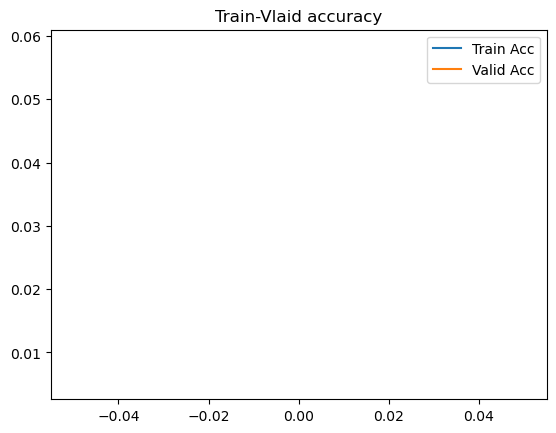

epoch 1 loss: 4.7629:   1%|▌                                         | 1/80 [00:05<06:39,  5.05s/it]

111
222
111
222


epoch 1 loss: 4.7620:   4%|█▌                                        | 3/80 [00:05<01:38,  1.28s/it]

111
222
111
222


epoch 1 loss: 4.7613:   6%|██▋                                       | 5/80 [00:05<00:45,  1.64it/s]

111
222
111
222


epoch 1 loss: 4.7607:   9%|███▋                                      | 7/80 [00:09<01:42,  1.40s/it]

111
222
111
222


epoch 1 loss: 4.7591:  11%|████▋                                     | 9/80 [00:09<00:53,  1.32it/s]

111
222
111
222


epoch 1 loss: 4.7575:  14%|█████▋                                   | 11/80 [00:10<00:31,  2.18it/s]

111
222
111
222


epoch 1 loss: 4.7564:  16%|██████▋                                  | 13/80 [00:13<01:25,  1.27s/it]

111
222
111
222


epoch 1 loss: 4.7542:  19%|███████▋                                 | 15/80 [00:13<00:46,  1.39it/s]

111
222
111
222


epoch 1 loss: 4.7525:  21%|████████▋                                | 17/80 [00:14<00:28,  2.22it/s]

111
222


epoch 1 loss: 4.7518:  22%|█████████▏                               | 18/80 [00:14<00:30,  2.00it/s]

111
222


epoch 1 loss: 4.7511:  24%|█████████▋                               | 19/80 [00:17<01:14,  1.22s/it]

111
222
111
222


epoch 1 loss: 4.7492:  26%|██████████▊                              | 21/80 [00:18<00:40,  1.44it/s]

111
222
111
222


epoch 1 loss: 4.7475:  29%|███████████▊                             | 23/80 [00:18<00:24,  2.28it/s]

111
222


epoch 1 loss: 4.7462:  30%|████████████▎                            | 24/80 [00:19<00:23,  2.39it/s]

111
222


epoch 1 loss: 4.7453:  31%|████████████▊                            | 25/80 [00:22<01:08,  1.25s/it]

111
222


epoch 1 loss: 4.7447:  32%|█████████████▎                           | 26/80 [00:22<00:51,  1.04it/s]

111
222


epoch 1 loss: 4.7435:  34%|█████████████▊                           | 27/80 [00:22<00:38,  1.37it/s]

111
222
111
222


epoch 1 loss: 4.7414:  36%|██████████████▊                          | 29/80 [00:23<00:22,  2.23it/s]

111
222
111
222


epoch 1 loss: 4.7383:  39%|███████████████▉                         | 31/80 [00:26<00:57,  1.17s/it]

111
222


epoch 1 loss: 4.7375:  40%|████████████████▍                        | 32/80 [00:26<00:44,  1.09it/s]

111
222


epoch 1 loss: 4.7362:  41%|████████████████▉                        | 33/80 [00:26<00:32,  1.43it/s]

111
222
111
222


epoch 1 loss: 4.7342:  44%|█████████████████▉                       | 35/80 [00:27<00:19,  2.28it/s]

111
222
111
222


epoch 1 loss: 4.7318:  46%|██████████████████▉                      | 37/80 [00:31<01:01,  1.43s/it]

111
222
111
222


epoch 1 loss: 4.7289:  49%|███████████████████▉                     | 39/80 [00:31<00:32,  1.25it/s]

111
222
111
222


epoch 1 loss: 4.7258:  51%|█████████████████████                    | 41/80 [00:31<00:18,  2.06it/s]

111
222
111
222


epoch 1 loss: 4.7213:  54%|██████████████████████                   | 43/80 [00:35<00:48,  1.30s/it]

111
222
111
222


epoch 1 loss: 4.7178:  56%|███████████████████████                  | 45/80 [00:35<00:25,  1.36it/s]

111
222
111
222


epoch 1 loss: 4.7149:  59%|████████████████████████                 | 47/80 [00:36<00:15,  2.19it/s]

111
222
111
222


epoch 1 loss: 4.7129:  61%|█████████████████████████                | 49/80 [00:39<00:36,  1.18s/it]

111
222
111
222


epoch 1 loss: 4.7099:  64%|██████████████████████████▏              | 51/80 [00:39<00:19,  1.47it/s]

111
222
111
222


epoch 1 loss: 4.7069:  66%|███████████████████████████▏             | 53/80 [00:40<00:11,  2.33it/s]

111
222
111
222


epoch 1 loss: 4.7035:  69%|████████████████████████████▏            | 55/80 [00:43<00:31,  1.25s/it]

111
222
111
222


epoch 1 loss: 4.6989:  71%|█████████████████████████████▏           | 57/80 [00:44<00:16,  1.40it/s]

111
222
111
222


epoch 1 loss: 4.6945:  74%|██████████████████████████████▏          | 59/80 [00:44<00:09,  2.23it/s]

111
222
111
222


epoch 1 loss: 4.6913:  76%|███████████████████████████████▎         | 61/80 [00:47<00:22,  1.20s/it]

111
222
111
222


epoch 1 loss: 4.6865:  79%|████████████████████████████████▎        | 63/80 [00:48<00:11,  1.45it/s]

111
222
111
222


epoch 1 loss: 4.6831:  81%|█████████████████████████████████▎       | 65/80 [00:48<00:06,  2.32it/s]

111
222
111
222


epoch 1 loss: 4.6789:  84%|██████████████████████████████████▎      | 67/80 [00:52<00:15,  1.21s/it]

111
222
111
222


epoch 1 loss: 4.6750:  86%|███████████████████████████████████▎     | 69/80 [00:52<00:08,  1.30it/s]

111
222
111
222


epoch 1 loss: 4.6690:  89%|████████████████████████████████████▍    | 71/80 [00:53<00:04,  2.10it/s]

111
222
111
222


epoch 1 loss: 4.6633:  91%|█████████████████████████████████████▍   | 73/80 [00:56<00:07,  1.13s/it]

111
222
111
222


epoch 1 loss: 4.6584:  94%|██████████████████████████████████████▍  | 75/80 [00:56<00:03,  1.36it/s]

111
222
111
222


epoch 1 loss: 4.6545:  96%|███████████████████████████████████████▍ | 77/80 [00:57<00:01,  2.24it/s]

111
222
111
222


epoch 1 loss: 4.6494:  99%|████████████████████████████████████████▍| 79/80 [00:59<00:01,  1.01s/it]

111
222
111
222


epoch 1 loss: 4.6485: 100%|█████████████████████████████████████████| 80/80 [01:00<00:00,  1.33it/s]

333
train accuracy = 0.23081
[[ 6  0  0 ...  0  0  1]
 [ 1  9  0 ...  0  0  0]
 [ 2  0  5 ...  0  0  0]
 ...
 [ 0  1  0 ...  2  0  1]
 [ 0  0  0 ...  0  5  8]
 [ 0  0  0 ...  0  0 32]]



epoch 1 loss: 4.8691: 100%|█████████████████████████████████████████| 38/38 [00:02<00:00, 13.29it/s]


validation accuracy = 0.01842
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


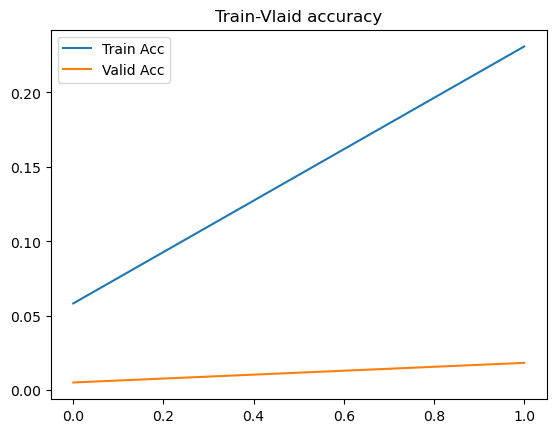

epoch 2 loss: 4.3438:   1%|▌                                         | 1/80 [00:04<05:42,  4.33s/it]

111
222
111
222


epoch 2 loss: 4.3450:   4%|█▌                                        | 3/80 [00:04<01:26,  1.12s/it]

111
222
111
222


epoch 2 loss: 4.3459:   6%|██▋                                       | 5/80 [00:05<00:41,  1.82it/s]

111
222
111
222


epoch 2 loss: 4.3459:   9%|███▋                                      | 7/80 [00:08<01:36,  1.32s/it]

111
222


epoch 2 loss: 4.3456:  10%|████▏                                     | 8/80 [00:08<01:15,  1.04s/it]

111
222


epoch 2 loss: 4.3450:  11%|████▋                                     | 9/80 [00:09<00:55,  1.29it/s]

111
222
111
222


epoch 2 loss: 4.3469:  14%|█████▋                                   | 11/80 [00:09<00:32,  2.11it/s]

111
222
111
222


epoch 2 loss: 4.3472:  16%|██████▋                                  | 13/80 [00:12<01:15,  1.12s/it]

111
222


epoch 2 loss: 4.3477:  18%|███████▏                                 | 14/80 [00:13<01:09,  1.05s/it]

111
222


epoch 2 loss: 4.3481:  19%|███████▋                                 | 15/80 [00:13<00:51,  1.26it/s]

111
222
111
222


epoch 2 loss: 4.3469:  21%|████████▋                                | 17/80 [00:13<00:30,  2.05it/s]

111
222
111
222


epoch 2 loss: 4.3473:  24%|█████████▋                               | 19/80 [00:16<01:03,  1.05s/it]

111
222


epoch 2 loss: 4.3473:  25%|██████████▎                              | 20/80 [00:17<00:56,  1.06it/s]

111
222


epoch 2 loss: 4.3468:  26%|██████████▊                              | 21/80 [00:17<00:42,  1.39it/s]

111
222
111
222


epoch 2 loss: 4.3469:  29%|███████████▊                             | 23/80 [00:17<00:25,  2.22it/s]

111
222
111
222


epoch 2 loss: 4.3440:  31%|████████████▊                            | 25/80 [00:20<00:58,  1.06s/it]

111
222


epoch 2 loss: 4.3433:  32%|█████████████▎                           | 26/80 [00:21<00:52,  1.03it/s]

111
222


epoch 2 loss: 4.3414:  34%|█████████████▊                           | 27/80 [00:21<00:39,  1.36it/s]

111
222
111
222


epoch 2 loss: 4.3389:  36%|██████████████▊                          | 29/80 [00:22<00:23,  2.19it/s]

111
222
111
222


epoch 2 loss: 4.3361:  39%|███████████████▉                         | 31/80 [00:25<00:54,  1.12s/it]

111
222


epoch 2 loss: 4.3340:  40%|████████████████▍                        | 32/80 [00:25<00:44,  1.08it/s]

111
222


epoch 2 loss: 4.3323:  41%|████████████████▉                        | 33/80 [00:25<00:33,  1.42it/s]

111
222
111
222


epoch 2 loss: 4.3295:  44%|█████████████████▉                       | 35/80 [00:26<00:19,  2.26it/s]

111
222
111
222


epoch 2 loss: 4.3277:  46%|██████████████████▉                      | 37/80 [00:29<00:52,  1.21s/it]

111
222
111


epoch 2 loss: 4.3256:  48%|███████████████████▍                     | 38/80 [00:29<00:38,  1.10it/s]

222
111


epoch 2 loss: 4.3244:  49%|███████████████████▉                     | 39/80 [00:30<00:28,  1.44it/s]

222
111
222


epoch 2 loss: 4.3193:  51%|█████████████████████                    | 41/80 [00:30<00:17,  2.26it/s]

111
222
111
222


epoch 2 loss: 4.3162:  54%|██████████████████████                   | 43/80 [00:33<00:45,  1.22s/it]

111
222
111
222


epoch 2 loss: 4.3130:  56%|███████████████████████                  | 45/80 [00:34<00:24,  1.43it/s]

111
222
111
222


epoch 2 loss: 4.3099:  59%|████████████████████████                 | 47/80 [00:34<00:14,  2.26it/s]

111
222
111
222


epoch 2 loss: 4.3055:  61%|█████████████████████████                | 49/80 [00:37<00:37,  1.21s/it]

111
222
111
222


epoch 2 loss: 4.3005:  64%|██████████████████████████▏              | 51/80 [00:38<00:19,  1.45it/s]

111
222
111


epoch 2 loss: 4.2988:  65%|██████████████████████████▋              | 52/80 [00:38<00:15,  1.83it/s]

222
111


epoch 2 loss: 4.2973:  66%|███████████████████████████▏             | 53/80 [00:38<00:11,  2.27it/s]

222
111
222


epoch 2 loss: 4.2922:  69%|████████████████████████████▏            | 55/80 [00:42<00:29,  1.19s/it]

111
222


epoch 2 loss: 4.2892:  70%|████████████████████████████▋            | 56/80 [00:42<00:21,  1.09it/s]

111
222


epoch 2 loss: 4.2869:  71%|█████████████████████████████▏           | 57/80 [00:42<00:16,  1.43it/s]

111
222


epoch 2 loss: 4.2841:  72%|█████████████████████████████▋           | 58/80 [00:42<00:13,  1.61it/s]

111
222


epoch 2 loss: 4.2812:  74%|██████████████████████████████▏          | 59/80 [00:43<00:10,  2.03it/s]

111
222
111
222


epoch 2 loss: 4.2764:  76%|███████████████████████████████▎         | 61/80 [00:46<00:21,  1.12s/it]

111
222


epoch 2 loss: 4.2740:  78%|███████████████████████████████▊         | 62/80 [00:46<00:18,  1.00s/it]

111
222


epoch 2 loss: 4.2710:  79%|████████████████████████████████▎        | 63/80 [00:47<00:12,  1.32it/s]

111
222


epoch 2 loss: 4.2694:  80%|████████████████████████████████▊        | 64/80 [00:47<00:10,  1.54it/s]

111
222


epoch 2 loss: 4.2681:  81%|█████████████████████████████████▎       | 65/80 [00:47<00:07,  1.95it/s]

111
222
111
222


epoch 2 loss: 4.2639:  84%|██████████████████████████████████▎      | 67/80 [00:50<00:13,  1.04s/it]

111
222


epoch 2 loss: 4.2620:  85%|██████████████████████████████████▊      | 68/80 [00:50<00:10,  1.11it/s]

111
222


epoch 2 loss: 4.2597:  86%|███████████████████████████████████▎     | 69/80 [00:51<00:07,  1.45it/s]

111
222


epoch 2 loss: 4.2565:  88%|███████████████████████████████████▉     | 70/80 [00:51<00:06,  1.47it/s]

111
222


epoch 2 loss: 4.2536:  89%|████████████████████████████████████▍    | 71/80 [00:51<00:04,  1.87it/s]

111
222
111
222


epoch 2 loss: 4.2465:  91%|█████████████████████████████████████▍   | 73/80 [00:54<00:06,  1.02it/s]

111
222


epoch 2 loss: 4.2447:  92%|█████████████████████████████████████▉   | 74/80 [00:54<00:04,  1.21it/s]

111
222
111


epoch 2 loss: 4.2406:  94%|██████████████████████████████████████▍  | 75/80 [00:55<00:03,  1.58it/s]

222


epoch 2 loss: 4.2368:  95%|██████████████████████████████████████▉  | 76/80 [00:55<00:02,  1.52it/s]

111
222
111


epoch 2 loss: 4.2317:  96%|███████████████████████████████████████▍ | 77/80 [00:55<00:01,  1.93it/s]

222
111
222


epoch 2 loss: 4.2246:  99%|████████████████████████████████████████▍| 79/80 [00:58<00:00,  1.14it/s]

111
222
111
222


epoch 2 loss: 4.2198: 100%|█████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.34053
[[16  0  0 ...  0  0  0]
 [ 0 29  0 ...  0  0  0]
 [ 4  0 21 ...  0  0  0]
 ...
 [ 0  1  0 ...  7  0  3]
 [ 2  1  0 ...  0  3 12]
 [ 0  0  0 ...  0  0 52]]



epoch 2 loss: 4.7772: 100%|█████████████████████████████████████████| 38/38 [00:02<00:00, 13.24it/s]


validation accuracy = 0.02895
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


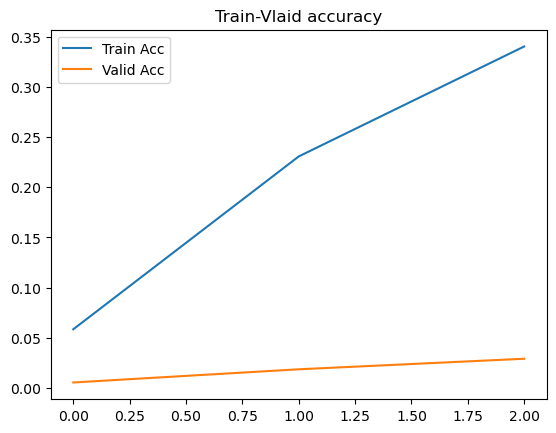

epoch 3 loss: 3.9128:   1%|▌                                         | 1/80 [00:04<05:59,  4.55s/it]

111
222
111
222


epoch 3 loss: 3.9120:   4%|█▌                                        | 3/80 [00:04<01:30,  1.17s/it]

111
222
111
222


epoch 3 loss: 3.9119:   6%|██▋                                       | 5/80 [00:05<00:42,  1.76it/s]

111
222
111
222


epoch 3 loss: 3.9131:   9%|███▋                                      | 7/80 [00:08<01:37,  1.33s/it]

111
222
111
222


epoch 3 loss: 3.9115:  11%|████▋                                     | 9/80 [00:09<00:51,  1.37it/s]

111
222
111
222


epoch 3 loss: 3.9111:  14%|█████▋                                   | 11/80 [00:09<00:30,  2.23it/s]

111
222
111
222


epoch 3 loss: 3.9102:  16%|██████▋                                  | 13/80 [00:12<01:23,  1.24s/it]

111
222
111
222


epoch 3 loss: 3.9082:  19%|███████▋                                 | 15/80 [00:13<00:45,  1.43it/s]

111
222
111
222


epoch 3 loss: 3.9054:  21%|████████▋                                | 17/80 [00:13<00:27,  2.26it/s]

111
222
111
222


epoch 3 loss: 3.9006:  24%|█████████▋                               | 19/80 [00:16<01:13,  1.20s/it]

111
222
111
222


epoch 3 loss: 3.8984:  26%|██████████▊                              | 21/80 [00:17<00:40,  1.46it/s]

111
222
111
222


epoch 3 loss: 3.8962:  29%|███████████▊                             | 23/80 [00:17<00:24,  2.29it/s]

111
222
111
222


epoch 3 loss: 3.8936:  31%|████████████▊                            | 25/80 [00:21<01:06,  1.20s/it]

111
222
111
222


epoch 3 loss: 3.8913:  34%|█████████████▊                           | 27/80 [00:21<00:36,  1.45it/s]

111
222
111
222


epoch 3 loss: 3.8892:  36%|██████████████▊                          | 29/80 [00:21<00:22,  2.30it/s]

111
222
111
222


epoch 3 loss: 3.8862:  39%|███████████████▉                         | 31/80 [00:25<00:59,  1.22s/it]

111
222
111
222


epoch 3 loss: 3.8826:  41%|████████████████▉                        | 33/80 [00:25<00:32,  1.45it/s]

111
222
111
222


epoch 3 loss: 3.8792:  44%|█████████████████▉                       | 35/80 [00:26<00:19,  2.30it/s]

111
222
111
222


epoch 3 loss: 3.8746:  46%|██████████████████▉                      | 37/80 [00:29<00:51,  1.20s/it]

111
222
111
222


epoch 3 loss: 3.8705:  49%|███████████████████▉                     | 39/80 [00:29<00:28,  1.46it/s]

111
222
111
222


epoch 3 loss: 3.8646:  51%|█████████████████████                    | 41/80 [00:30<00:17,  2.29it/s]

111
222
111
222


epoch 3 loss: 3.8591:  54%|██████████████████████                   | 43/80 [00:33<00:46,  1.26s/it]

111
222
111
222


epoch 3 loss: 3.8548:  56%|███████████████████████                  | 45/80 [00:34<00:25,  1.40it/s]

111
222
111
222


epoch 3 loss: 3.8498:  59%|████████████████████████                 | 47/80 [00:34<00:14,  2.21it/s]

111
222
111
222


epoch 3 loss: 3.8462:  61%|█████████████████████████                | 49/80 [00:37<00:37,  1.21s/it]

111
222
111
222


epoch 3 loss: 3.8412:  64%|██████████████████████████▏              | 51/80 [00:38<00:19,  1.46it/s]

111
222
111
222


epoch 3 loss: 3.8364:  66%|███████████████████████████▏             | 53/80 [00:38<00:11,  2.29it/s]

111
222
111
222


epoch 3 loss: 3.8320:  69%|████████████████████████████▏            | 55/80 [00:42<00:31,  1.24s/it]

111
222
111
222


epoch 3 loss: 3.8282:  71%|█████████████████████████████▏           | 57/80 [00:42<00:16,  1.41it/s]

111
222
111
222


epoch 3 loss: 3.8203:  74%|██████████████████████████████▏          | 59/80 [00:42<00:09,  2.24it/s]

111
222
111
222


epoch 3 loss: 3.8140:  76%|███████████████████████████████▎         | 61/80 [00:46<00:22,  1.18s/it]

111
222
111
222


epoch 3 loss: 3.8084:  79%|████████████████████████████████▎        | 63/80 [00:46<00:11,  1.47it/s]

111
222
111
222


epoch 3 loss: 3.8053:  81%|█████████████████████████████████▎       | 65/80 [00:46<00:06,  2.32it/s]

111
222
111
222


epoch 3 loss: 3.7998:  84%|██████████████████████████████████▎      | 67/80 [00:50<00:16,  1.27s/it]

111
222


epoch 3 loss: 3.7962:  85%|██████████████████████████████████▊      | 68/80 [00:50<00:11,  1.03it/s]

111
222
111


epoch 3 loss: 3.7937:  86%|███████████████████████████████████▎     | 69/80 [00:50<00:08,  1.36it/s]

222
111
222


epoch 3 loss: 3.7870:  89%|████████████████████████████████████▍    | 71/80 [00:51<00:04,  2.16it/s]

111
222
111
222


epoch 3 loss: 3.7817:  91%|█████████████████████████████████████▍   | 73/80 [00:54<00:08,  1.19s/it]

111
222


epoch 3 loss: 3.7788:  92%|█████████████████████████████████████▉   | 74/80 [00:55<00:06,  1.05s/it]

111
222
111


epoch 3 loss: 3.7755:  94%|██████████████████████████████████████▍  | 75/80 [00:55<00:03,  1.27it/s]

222
111
222


epoch 3 loss: 3.7684:  96%|███████████████████████████████████████▍ | 77/80 [00:55<00:01,  2.11it/s]

111
222
111
222


epoch 3 loss: 3.7613:  99%|████████████████████████████████████████▍| 79/80 [00:58<00:00,  1.06it/s]

111
222
111
222


epoch 3 loss: 3.7610: 100%|█████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.37210
[[25  0  0 ...  0  1  0]
 [ 0 28  0 ...  0  0  0]
 [ 5  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  1]
 [ 1  0  0 ...  0  3 11]
 [ 0  0  0 ...  0  0 54]]



epoch 3 loss: 4.6489: 100%|█████████████████████████████████████████| 38/38 [00:02<00:00, 13.28it/s]


validation accuracy = 0.03947
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


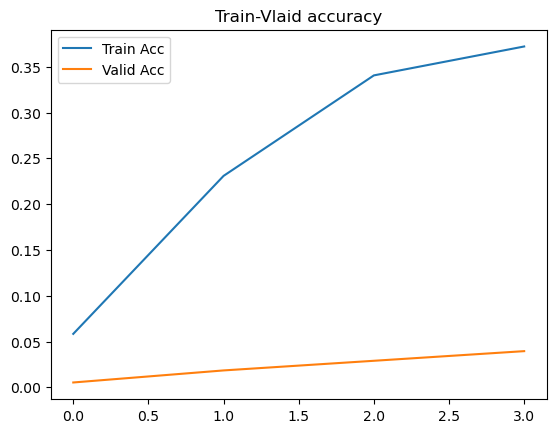

epoch 4 loss: 3.4505:   1%|▌                                         | 1/80 [00:04<05:33,  4.22s/it]

111
222
111
222


epoch 4 loss: 3.4478:   4%|█▌                                        | 3/80 [00:04<01:24,  1.10s/it]

111
222
111
222


epoch 4 loss: 3.4447:   6%|██▋                                       | 5/80 [00:04<00:40,  1.85it/s]

111
222
111
222


epoch 4 loss: 3.4424:   9%|███▋                                      | 7/80 [00:08<01:34,  1.29s/it]

111
222
111
222


epoch 4 loss: 3.4412:  11%|████▋                                     | 9/80 [00:08<00:50,  1.41it/s]

111
222
111
222


epoch 4 loss: 3.4379:  14%|█████▋                                   | 11/80 [00:09<00:30,  2.27it/s]

111
222
111
222


epoch 4 loss: 3.4368:  16%|██████▋                                  | 13/80 [00:12<01:23,  1.24s/it]

111
222
111
222


epoch 4 loss: 3.4319:  19%|███████▋                                 | 15/80 [00:12<00:45,  1.41it/s]

111
222
111
222


epoch 4 loss: 3.4287:  21%|████████▋                                | 17/80 [00:13<00:28,  2.24it/s]

111
222
111
222


epoch 4 loss: 3.4315:  24%|█████████▋                               | 19/80 [00:16<01:13,  1.21s/it]

111
222


epoch 4 loss: 3.4311:  25%|██████████▎                              | 20/80 [00:16<00:56,  1.07it/s]

111
222


epoch 4 loss: 3.4285:  26%|██████████▊                              | 21/80 [00:17<00:42,  1.40it/s]

111
222
111
222


epoch 4 loss: 3.4293:  29%|███████████▊                             | 23/80 [00:17<00:25,  2.22it/s]

111
222
111
222


epoch 4 loss: 3.4289:  31%|████████████▊                            | 25/80 [00:20<01:06,  1.22s/it]

111
222


epoch 4 loss: 3.4256:  32%|█████████████▎                           | 26/80 [00:21<00:49,  1.09it/s]

111
222


epoch 4 loss: 3.4250:  34%|█████████████▊                           | 27/80 [00:21<00:37,  1.42it/s]

111
222
111
222


epoch 4 loss: 3.4238:  36%|██████████████▊                          | 29/80 [00:21<00:22,  2.27it/s]

111
222
111
222


epoch 4 loss: 3.4197:  39%|███████████████▉                         | 31/80 [00:25<01:00,  1.24s/it]

111
222
111
222


epoch 4 loss: 3.4139:  41%|████████████████▉                        | 33/80 [00:25<00:33,  1.42it/s]

111
222
111
222


epoch 4 loss: 3.4077:  44%|█████████████████▉                       | 35/80 [00:25<00:20,  2.25it/s]

111
222
111
222


epoch 4 loss: 3.4045:  46%|██████████████████▉                      | 37/80 [00:29<00:50,  1.18s/it]

111
222


epoch 4 loss: 3.4018:  48%|███████████████████▍                     | 38/80 [00:29<00:38,  1.08it/s]

111
222


epoch 4 loss: 3.3999:  49%|███████████████████▉                     | 39/80 [00:29<00:28,  1.42it/s]

111
222
111
222


epoch 4 loss: 3.3951:  51%|█████████████████████                    | 41/80 [00:30<00:17,  2.25it/s]

111
222
111
222


epoch 4 loss: 3.3900:  54%|██████████████████████                   | 43/80 [00:33<00:43,  1.17s/it]

111
222


epoch 4 loss: 3.3882:  55%|██████████████████████▌                  | 44/80 [00:33<00:34,  1.03it/s]

111
222


epoch 4 loss: 3.3854:  56%|███████████████████████                  | 45/80 [00:34<00:25,  1.36it/s]

111
222
111
222


epoch 4 loss: 3.3794:  59%|████████████████████████                 | 47/80 [00:34<00:15,  2.17it/s]

111
222
111
222


epoch 4 loss: 3.3733:  61%|█████████████████████████                | 49/80 [00:37<00:35,  1.14s/it]

111
222


epoch 4 loss: 3.3699:  62%|█████████████████████████▋               | 50/80 [00:37<00:27,  1.11it/s]

111
222


epoch 4 loss: 3.3676:  64%|██████████████████████████▏              | 51/80 [00:38<00:20,  1.44it/s]

111
222
111
222


epoch 4 loss: 3.3627:  66%|███████████████████████████▏             | 53/80 [00:38<00:11,  2.28it/s]

111
222
111
222


epoch 4 loss: 3.3602:  69%|████████████████████████████▏            | 55/80 [00:41<00:29,  1.20s/it]

111
222


epoch 4 loss: 3.3573:  70%|████████████████████████████▋            | 56/80 [00:42<00:24,  1.03s/it]

111
222


epoch 4 loss: 3.3559:  71%|█████████████████████████████▏           | 57/80 [00:42<00:17,  1.28it/s]

111
222
111
222


epoch 4 loss: 3.3533:  74%|██████████████████████████████▏          | 59/80 [00:42<00:10,  2.10it/s]

111
222
111
222


epoch 4 loss: 3.3464:  76%|███████████████████████████████▎         | 61/80 [00:45<00:20,  1.08s/it]

111
222


epoch 4 loss: 3.3437:  78%|███████████████████████████████▊         | 62/80 [00:46<00:17,  1.03it/s]

111
222


epoch 4 loss: 3.3430:  79%|████████████████████████████████▎        | 63/80 [00:46<00:12,  1.35it/s]

111
222
111
222


epoch 4 loss: 3.3358:  81%|█████████████████████████████████▎       | 65/80 [00:47<00:06,  2.17it/s]

111
222
111
222


epoch 4 loss: 3.3292:  84%|██████████████████████████████████▎      | 67/80 [00:50<00:13,  1.06s/it]

111
222


epoch 4 loss: 3.3281:  85%|██████████████████████████████████▊      | 68/80 [00:50<00:11,  1.01it/s]

111
222


epoch 4 loss: 3.3247:  86%|███████████████████████████████████▎     | 69/80 [00:51<00:08,  1.33it/s]

111
222
111
222


epoch 4 loss: 3.3182:  89%|████████████████████████████████████▍    | 71/80 [00:51<00:04,  2.14it/s]

111
222
111
222


epoch 4 loss: 3.3126:  91%|█████████████████████████████████████▍   | 73/80 [00:54<00:07,  1.02s/it]

111
222


epoch 4 loss: 3.3074:  92%|█████████████████████████████████████▉   | 74/80 [00:55<00:05,  1.00it/s]

111
222
111


epoch 4 loss: 3.3051:  94%|██████████████████████████████████████▍  | 75/80 [00:55<00:03,  1.33it/s]

222
111
222


epoch 4 loss: 3.2976:  96%|███████████████████████████████████████▍ | 77/80 [00:55<00:01,  2.19it/s]

111
222
111
222


epoch 4 loss: 3.2896:  99%|████████████████████████████████████████▍| 79/80 [00:57<00:00,  1.14it/s]

111
222
111
222


epoch 4 loss: 3.2864: 100%|█████████████████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]

333
train accuracy = 0.44710
[[37  0  0 ...  0  0  0]
 [ 0 41  0 ...  0  0  0]
 [ 0  0 44 ...  0  0  0]
 ...
 [ 2  1  0 ...  6  0  2]
 [ 0  0  0 ...  0 10 18]
 [ 0  0  0 ...  0  0 54]]



epoch 4 loss: 4.5201: 100%|█████████████████████████████████████████| 38/38 [00:02<00:00, 13.16it/s]


validation accuracy = 0.05000
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


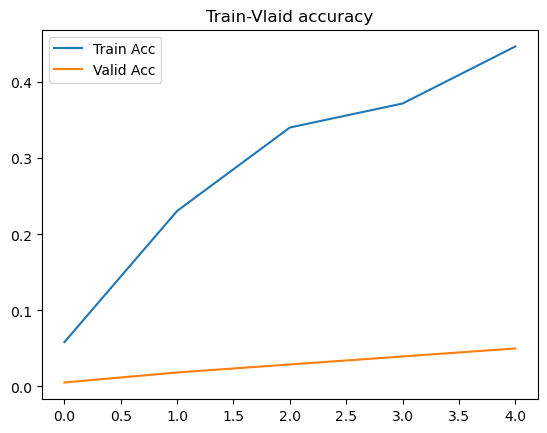

epoch 5 loss: 2.9102:   1%|▌                                         | 1/80 [00:04<05:23,  4.10s/it]

111
222
111
222


epoch 5 loss: 2.9106:   4%|█▌                                        | 3/80 [00:04<01:22,  1.07s/it]

111
222
111
222


epoch 5 loss: 2.9111:   6%|██▋                                       | 5/80 [00:04<00:39,  1.90it/s]

111
222
111
222


epoch 5 loss: 2.9105:   9%|███▋                                      | 7/80 [00:08<01:43,  1.42s/it]

111
222
111
222


epoch 5 loss: 2.9126:  11%|████▋                                     | 9/80 [00:08<00:54,  1.30it/s]

111
222
111
222


epoch 5 loss: 2.9104:  14%|█████▋                                   | 11/80 [00:09<00:32,  2.13it/s]

111
222
111
222


epoch 5 loss: 2.9118:  16%|██████▋                                  | 13/80 [00:12<01:21,  1.21s/it]

111
222


epoch 5 loss: 2.9126:  18%|███████▏                                 | 14/80 [00:13<01:04,  1.02it/s]

111
222


epoch 5 loss: 2.9142:  19%|███████▋                                 | 15/80 [00:13<00:48,  1.34it/s]

111
222
111
222


epoch 5 loss: 2.9088:  21%|████████▋                                | 17/80 [00:13<00:28,  2.18it/s]

111
222
111
222


epoch 5 loss: 2.9090:  24%|█████████▋                               | 19/80 [00:16<01:13,  1.21s/it]

111
222
111
222


epoch 5 loss: 2.9070:  26%|██████████▊                              | 21/80 [00:17<00:40,  1.45it/s]

111
222
111
222


epoch 5 loss: 2.9083:  29%|███████████▊                             | 23/80 [00:17<00:24,  2.30it/s]

111
222
111
222


epoch 5 loss: 2.9071:  31%|████████████▊                            | 25/80 [00:21<01:05,  1.19s/it]

111
222


epoch 5 loss: 2.9069:  32%|█████████████▎                           | 26/80 [00:21<00:50,  1.07it/s]

111
222


epoch 5 loss: 2.9050:  34%|█████████████▊                           | 27/80 [00:21<00:37,  1.41it/s]

111
222
111
222


epoch 5 loss: 2.9034:  36%|██████████████▊                          | 29/80 [00:21<00:22,  2.25it/s]

111
222
111
222


epoch 5 loss: 2.9027:  39%|███████████████▉                         | 31/80 [00:25<00:56,  1.16s/it]

111
222


epoch 5 loss: 2.9023:  40%|████████████████▍                        | 32/80 [00:25<00:47,  1.02it/s]

111
222


epoch 5 loss: 2.9001:  41%|████████████████▉                        | 33/80 [00:25<00:34,  1.34it/s]

111
222
111
222


epoch 5 loss: 2.9002:  44%|█████████████████▉                       | 35/80 [00:26<00:20,  2.15it/s]

111
222
111
222


epoch 5 loss: 2.9004:  46%|██████████████████▉                      | 37/80 [00:29<00:53,  1.24s/it]

111
222


epoch 5 loss: 2.8970:  48%|███████████████████▍                     | 38/80 [00:29<00:39,  1.06it/s]

111
222


epoch 5 loss: 2.8975:  49%|███████████████████▉                     | 39/80 [00:30<00:29,  1.40it/s]

111
222
111
222


epoch 5 loss: 2.8948:  51%|█████████████████████                    | 41/80 [00:30<00:17,  2.24it/s]

111
222
111
222


epoch 5 loss: 2.8932:  54%|██████████████████████                   | 43/80 [00:34<00:46,  1.27s/it]

111
222
111
222


epoch 5 loss: 2.8865:  56%|███████████████████████                  | 45/80 [00:34<00:25,  1.40it/s]

111
222
111
222


epoch 5 loss: 2.8840:  59%|████████████████████████                 | 47/80 [00:34<00:14,  2.25it/s]

111
222
111
222


epoch 5 loss: 2.8795:  61%|█████████████████████████                | 49/80 [00:38<00:38,  1.24s/it]

111
222
111
222


epoch 5 loss: 2.8710:  64%|██████████████████████████▏              | 51/80 [00:38<00:20,  1.41it/s]

111
222
111
222


epoch 5 loss: 2.8651:  66%|███████████████████████████▏             | 53/80 [00:39<00:12,  2.23it/s]

111
222
111
222


epoch 5 loss: 2.8616:  69%|████████████████████████████▏            | 55/80 [00:42<00:29,  1.19s/it]

111
222
111
222


epoch 5 loss: 2.8550:  71%|█████████████████████████████▏           | 57/80 [00:42<00:15,  1.47it/s]

111
222
111
222


epoch 5 loss: 2.8487:  74%|██████████████████████████████▏          | 59/80 [00:43<00:09,  2.30it/s]

111
222
111
222


epoch 5 loss: 2.8488:  76%|███████████████████████████████▎         | 61/80 [00:46<00:23,  1.22s/it]

111
222
111
222


epoch 5 loss: 2.8436:  79%|████████████████████████████████▎        | 63/80 [00:46<00:11,  1.43it/s]

111
222
111
222


epoch 5 loss: 2.8379:  81%|█████████████████████████████████▎       | 65/80 [00:47<00:06,  2.22it/s]

111
222
111
222


epoch 5 loss: 2.8330:  84%|██████████████████████████████████▎      | 67/80 [00:50<00:14,  1.15s/it]

111
222


epoch 5 loss: 2.8332:  85%|██████████████████████████████████▊      | 68/80 [00:50<00:11,  1.09it/s]

111
222


epoch 5 loss: 2.8319:  86%|███████████████████████████████████▎     | 69/80 [00:51<00:07,  1.42it/s]

111
222
111
222


epoch 5 loss: 2.8259:  89%|████████████████████████████████████▍    | 71/80 [00:51<00:04,  2.22it/s]

111
222
111
222


epoch 5 loss: 2.8229:  91%|█████████████████████████████████████▍   | 73/80 [00:54<00:08,  1.20s/it]

111
222
111
222


epoch 5 loss: 2.8201:  94%|██████████████████████████████████████▍  | 75/80 [00:55<00:03,  1.47it/s]

111
222
111
222


epoch 5 loss: 2.8153:  96%|███████████████████████████████████████▍ | 77/80 [00:55<00:01,  2.19it/s]

111
222
111
222


epoch 5 loss: 2.8051:  99%|████████████████████████████████████████▍| 79/80 [00:58<00:01,  1.08s/it]

111
222
111
222


epoch 5 loss: 2.8075: 100%|█████████████████████████████████████████| 80/80 [00:58<00:00,  1.36it/s]

333
train accuracy = 0.52260
[[39  0  0 ...  0  0  0]
 [ 0 53  0 ...  0  0  0]
 [ 0  0 54 ...  0  0  0]
 ...
 [ 1  5  0 ... 11  0  2]
 [ 0  0  1 ...  0 14 13]
 [ 0  0  0 ...  0  0 55]]



epoch 5 loss: 4.4174: 100%|█████████████████████████████████████████| 38/38 [00:02<00:00, 13.50it/s]


validation accuracy = 0.05789
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


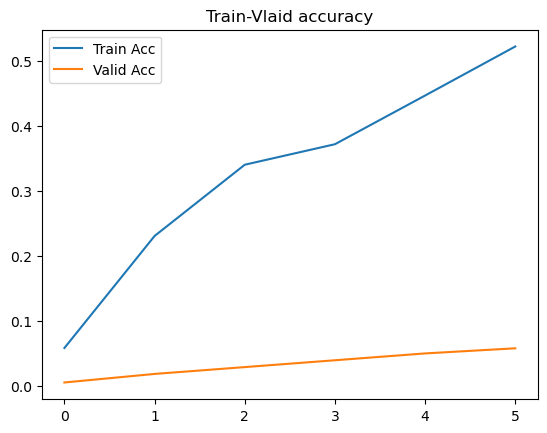

epoch 6 loss: 2.4911:   1%|▌                                         | 1/80 [00:04<05:39,  4.30s/it]

111
222
111
222


epoch 6 loss: 2.4926:   4%|█▌                                        | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 6 loss: 2.4932:   6%|██▋                                       | 5/80 [00:05<00:41,  1.81it/s]

111
222
111
222


epoch 6 loss: 2.4927:   9%|███▋                                      | 7/80 [00:08<01:40,  1.38s/it]

111
222
111
222


epoch 6 loss: 2.4940:  11%|████▋                                     | 9/80 [00:08<00:53,  1.34it/s]

111
222
111
222


epoch 6 loss: 2.4947:  14%|█████▋                                   | 11/80 [00:09<00:31,  2.19it/s]

111
222
111
222


epoch 6 loss: 2.4977:  16%|██████▋                                  | 13/80 [00:12<01:25,  1.27s/it]

111
222
111
222


epoch 6 loss: 2.4975:  19%|███████▋                                 | 15/80 [00:13<00:46,  1.39it/s]

111
222
111
222


epoch 6 loss: 2.4973:  21%|████████▋                                | 17/80 [00:13<00:28,  2.22it/s]

111
222
111
222


epoch 6 loss: 2.4948:  24%|█████████▋                               | 19/80 [00:17<01:14,  1.22s/it]

111
222
111
222


epoch 6 loss: 2.4936:  26%|██████████▊                              | 21/80 [00:17<00:41,  1.44it/s]

111
222
111
222


epoch 6 loss: 2.4931:  29%|███████████▊                             | 23/80 [00:17<00:25,  2.26it/s]

111
222
111
222


epoch 6 loss: 2.4926:  31%|████████████▊                            | 25/80 [00:21<01:10,  1.28s/it]

111
222
111
222


epoch 6 loss: 2.4898:  34%|█████████████▊                           | 27/80 [00:21<00:38,  1.38it/s]

111
222
111
222


epoch 6 loss: 2.4917:  36%|██████████████▊                          | 29/80 [00:22<00:23,  2.21it/s]

111
222
111
222


epoch 6 loss: 2.4907:  39%|███████████████▉                         | 31/80 [00:25<00:58,  1.19s/it]

111
222
111
222


epoch 6 loss: 2.4893:  41%|████████████████▉                        | 33/80 [00:25<00:31,  1.47it/s]

111
222
111
222


epoch 6 loss: 2.4850:  44%|█████████████████▉                       | 35/80 [00:26<00:19,  2.35it/s]

111
222
111
222


epoch 6 loss: 2.4836:  46%|██████████████████▉                      | 37/80 [00:29<00:52,  1.23s/it]

111
222
111
222


epoch 6 loss: 2.4799:  49%|███████████████████▉                     | 39/80 [00:30<00:28,  1.43it/s]

111
222
111
222


epoch 6 loss: 2.4786:  51%|█████████████████████                    | 41/80 [00:30<00:17,  2.28it/s]

111
222
111
222


epoch 6 loss: 2.4765:  54%|██████████████████████                   | 43/80 [00:33<00:44,  1.20s/it]

111
222
111
222


epoch 6 loss: 2.4753:  56%|███████████████████████                  | 45/80 [00:34<00:24,  1.41it/s]

111
222
111
222


epoch 6 loss: 2.4747:  59%|████████████████████████                 | 47/80 [00:34<00:14,  2.25it/s]

111
222
111
222


epoch 6 loss: 2.4745:  61%|█████████████████████████                | 49/80 [00:38<00:38,  1.25s/it]

111
222
111
222


epoch 6 loss: 2.4706:  64%|██████████████████████████▏              | 51/80 [00:38<00:20,  1.40it/s]

111
222
111
222


epoch 6 loss: 2.4678:  66%|███████████████████████████▏             | 53/80 [00:38<00:12,  2.22it/s]

111
222
111
222


epoch 6 loss: 2.4661:  69%|████████████████████████████▏            | 55/80 [00:42<00:29,  1.20s/it]

111
222
111
222


epoch 6 loss: 2.4631:  71%|█████████████████████████████▏           | 57/80 [00:42<00:16,  1.43it/s]

111
222
111
222


epoch 6 loss: 2.4601:  74%|██████████████████████████████▏          | 59/80 [00:43<00:09,  2.26it/s]

111
222
111
222


epoch 6 loss: 2.4545:  76%|███████████████████████████████▎         | 61/80 [00:46<00:22,  1.18s/it]

111
222
111
222


epoch 6 loss: 2.4490:  79%|████████████████████████████████▎        | 63/80 [00:46<00:11,  1.47it/s]

111
222
111
222


epoch 6 loss: 2.4451:  81%|█████████████████████████████████▎       | 65/80 [00:47<00:06,  2.30it/s]

111
222
111
222


epoch 6 loss: 2.4357:  84%|██████████████████████████████████▎      | 67/80 [00:50<00:16,  1.26s/it]

111
222
111
222


epoch 6 loss: 2.4328:  86%|███████████████████████████████████▎     | 69/80 [00:50<00:07,  1.40it/s]

111
222
111
222


epoch 6 loss: 2.4255:  89%|████████████████████████████████████▍    | 71/80 [00:51<00:04,  2.23it/s]

111
222
111
222


epoch 6 loss: 2.4214:  91%|█████████████████████████████████████▍   | 73/80 [00:54<00:08,  1.19s/it]

111
222


epoch 6 loss: 2.4179:  92%|█████████████████████████████████████▉   | 74/80 [00:54<00:05,  1.11it/s]

111
222
111


epoch 6 loss: 2.4137:  94%|██████████████████████████████████████▍  | 75/80 [00:55<00:03,  1.47it/s]

222
111
222


epoch 6 loss: 2.4086:  96%|███████████████████████████████████████▍ | 77/80 [00:55<00:01,  2.35it/s]

111
222
111
222


epoch 6 loss: 2.4053:  99%|████████████████████████████████████████▍| 79/80 [00:58<00:01,  1.05s/it]

111
222
111
222


epoch 6 loss: 2.4074: 100%|█████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.60354
[[41  0  0 ...  0  0  0]
 [ 0 53  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 2  1  0 ... 20  0  0]
 [ 0  0  0 ...  0 16 11]
 [ 0  0  0 ...  0  0 55]]



epoch 6 loss: 4.3284: 100%|█████████████████████████████████████████| 38/38 [00:02<00:00, 13.33it/s]


validation accuracy = 0.07368
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


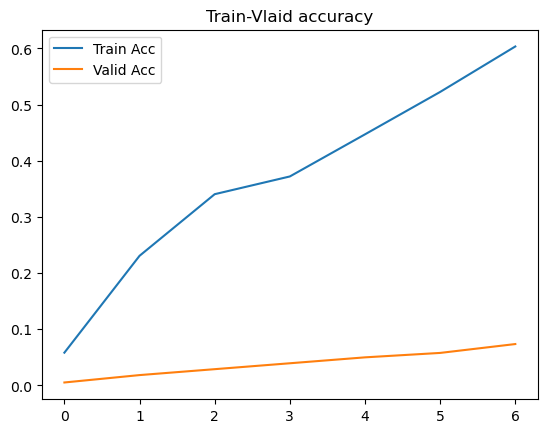

epoch 7 loss: 2.1312:   1%|▌                                         | 1/80 [00:04<05:26,  4.13s/it]

111
222


epoch 7 loss: 2.1319:   2%|█                                         | 2/80 [00:04<02:25,  1.87s/it]

111
222


epoch 7 loss: 2.1333:   4%|█▌                                        | 3/80 [00:04<01:25,  1.11s/it]

111
222
111


epoch 7 loss: 2.1355:   5%|██                                        | 4/80 [00:05<01:04,  1.18it/s]

222
111
222


epoch 7 loss: 2.1327:   8%|███▏                                      | 6/80 [00:05<00:34,  2.14it/s]

111
222


epoch 7 loss: 2.1358:   9%|███▋                                      | 7/80 [00:08<01:33,  1.29s/it]

111
222
111
222


epoch 7 loss: 2.1353:  11%|████▋                                     | 9/80 [00:08<00:50,  1.42it/s]

111
222
111
222


epoch 7 loss: 2.1386:  14%|█████▋                                   | 11/80 [00:09<00:30,  2.29it/s]

111
222
111
222


epoch 7 loss: 2.1387:  16%|██████▋                                  | 13/80 [00:12<01:21,  1.22s/it]

111
222


epoch 7 loss: 2.1396:  18%|███████▏                                 | 14/80 [00:12<01:04,  1.03it/s]

111
222


epoch 7 loss: 2.1372:  19%|███████▋                                 | 15/80 [00:13<00:51,  1.27it/s]

111
222
111
222


epoch 7 loss: 2.1358:  21%|████████▋                                | 17/80 [00:13<00:30,  2.09it/s]

111
222
111
222


epoch 7 loss: 2.1350:  24%|█████████▋                               | 19/80 [00:16<01:10,  1.15s/it]

111
222


epoch 7 loss: 2.1351:  25%|██████████▎                              | 20/80 [00:17<01:02,  1.05s/it]

111
222


epoch 7 loss: 2.1346:  26%|██████████▊                              | 21/80 [00:17<00:46,  1.27it/s]

111
222
111
222


epoch 7 loss: 2.1307:  29%|███████████▊                             | 23/80 [00:18<00:27,  2.07it/s]

111
222
111
222


epoch 7 loss: 2.1282:  31%|████████████▊                            | 25/80 [00:20<00:55,  1.01s/it]

111
222


epoch 7 loss: 2.1274:  32%|█████████████▎                           | 26/80 [00:21<00:57,  1.06s/it]

111
222
111


epoch 7 loss: 2.1256:  34%|█████████████▊                           | 27/80 [00:22<00:42,  1.25it/s]

222
111
222


epoch 7 loss: 2.1249:  36%|██████████████▊                          | 29/80 [00:22<00:24,  2.05it/s]

111
222
111
222


epoch 7 loss: 2.1242:  39%|███████████████▉                         | 31/80 [00:25<00:47,  1.04it/s]

111
222


epoch 7 loss: 2.1229:  40%|████████████████▍                        | 32/80 [00:26<00:48,  1.00s/it]

111
222


epoch 7 loss: 2.1209:  41%|████████████████▉                        | 33/80 [00:26<00:35,  1.31it/s]

111
222
111
222


epoch 7 loss: 2.1179:  44%|█████████████████▉                       | 35/80 [00:26<00:21,  2.10it/s]

111
222
111
222


epoch 7 loss: 2.1139:  46%|██████████████████▉                      | 37/80 [00:29<00:41,  1.04it/s]

111
222


epoch 7 loss: 2.1128:  48%|███████████████████▍                     | 38/80 [00:30<00:41,  1.01it/s]

111
222


epoch 7 loss: 2.1099:  49%|███████████████████▉                     | 39/80 [00:30<00:30,  1.33it/s]

111
222
111
222


epoch 7 loss: 2.1077:  51%|█████████████████████                    | 41/80 [00:30<00:18,  2.14it/s]

111
222
111
222


epoch 7 loss: 2.1081:  54%|██████████████████████                   | 43/80 [00:33<00:34,  1.06it/s]

111
222


epoch 7 loss: 2.1052:  55%|██████████████████████▌                  | 44/80 [00:34<00:35,  1.03it/s]

111
222


epoch 7 loss: 2.1050:  56%|███████████████████████                  | 45/80 [00:34<00:25,  1.35it/s]

111
222
111
222


epoch 7 loss: 2.0993:  59%|████████████████████████                 | 47/80 [00:34<00:15,  2.17it/s]

111
222
111
222


epoch 7 loss: 2.0955:  61%|█████████████████████████                | 49/80 [00:37<00:30,  1.02it/s]

111
222


epoch 7 loss: 2.0939:  62%|█████████████████████████▋               | 50/80 [00:38<00:29,  1.01it/s]

111
222


epoch 7 loss: 2.0929:  64%|██████████████████████████▏              | 51/80 [00:38<00:21,  1.33it/s]

111
222
111
222


epoch 7 loss: 2.0897:  66%|███████████████████████████▏             | 53/80 [00:39<00:12,  2.13it/s]

111
222
111
222


epoch 7 loss: 2.0891:  69%|████████████████████████████▏            | 55/80 [00:41<00:23,  1.05it/s]

111
222


epoch 7 loss: 2.0880:  70%|████████████████████████████▋            | 56/80 [00:42<00:23,  1.03it/s]

111
222


epoch 7 loss: 2.0845:  71%|█████████████████████████████▏           | 57/80 [00:42<00:17,  1.35it/s]

111
222
111
222


epoch 7 loss: 2.0841:  74%|██████████████████████████████▏          | 59/80 [00:43<00:09,  2.17it/s]

111
222
111
222


epoch 7 loss: 2.0822:  76%|███████████████████████████████▎         | 61/80 [00:45<00:18,  1.03it/s]

111
222


epoch 7 loss: 2.0802:  78%|███████████████████████████████▊         | 62/80 [00:46<00:17,  1.04it/s]

111
222


epoch 7 loss: 2.0781:  79%|████████████████████████████████▎        | 63/80 [00:46<00:12,  1.36it/s]

111
222
111
222


epoch 7 loss: 2.0757:  81%|█████████████████████████████████▎       | 65/80 [00:47<00:07,  1.98it/s]

111
222
111
222


epoch 7 loss: 2.0699:  84%|██████████████████████████████████▎      | 67/80 [00:49<00:12,  1.04it/s]

111
222


epoch 7 loss: 2.0677:  85%|██████████████████████████████████▊      | 68/80 [00:50<00:11,  1.01it/s]

111
222


epoch 7 loss: 2.0663:  86%|███████████████████████████████████▎     | 69/80 [00:51<00:08,  1.32it/s]

111
222
111
222


epoch 7 loss: 2.0622:  89%|████████████████████████████████████▍    | 71/80 [00:51<00:04,  2.00it/s]

111
222
111
222


epoch 7 loss: 2.0624:  91%|█████████████████████████████████████▍   | 73/80 [00:53<00:06,  1.12it/s]

111
222


epoch 7 loss: 2.0596:  92%|█████████████████████████████████████▉   | 74/80 [00:54<00:05,  1.05it/s]

111
222


epoch 7 loss: 2.0595:  94%|██████████████████████████████████████▍  | 75/80 [00:55<00:03,  1.39it/s]

111
222
111
222


epoch 7 loss: 2.0575:  96%|███████████████████████████████████████▍ | 77/80 [00:55<00:01,  1.91it/s]

111
222
111
222


epoch 7 loss: 2.0585:  99%|████████████████████████████████████████▍| 79/80 [00:57<00:00,  1.25it/s]

111
222
111
222


epoch 7 loss: 2.0585: 100%|█████████████████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]

333
train accuracy = 0.66679
[[49  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 2  0  0 ... 21  0  0]
 [ 0  0  2 ...  1 12 14]
 [ 0  0  0 ...  0  0 55]]



epoch 7 loss: 4.2243: 100%|█████████████████████████████████████████| 38/38 [00:02<00:00, 13.33it/s]


validation accuracy = 0.10526
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


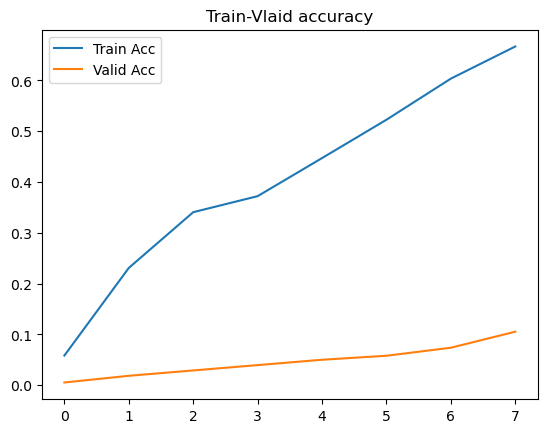

epoch 8 loss: 2.2128:   1%|▌                                         | 1/80 [00:04<05:42,  4.33s/it]

111
222
111
222


epoch 8 loss: 2.2059:   4%|█▌                                        | 3/80 [00:04<01:26,  1.12s/it]

111
222
111
222


epoch 8 loss: 2.1969:   6%|██▋                                       | 5/80 [00:05<00:40,  1.83it/s]

111
222
111
222


epoch 8 loss: 2.1944:   9%|███▋                                      | 7/80 [00:08<01:32,  1.27s/it]

111
222
111
222


epoch 8 loss: 2.1877:  11%|████▋                                     | 9/80 [00:08<00:57,  1.24it/s]

111
222
111
222


epoch 8 loss: 2.1796:  14%|█████▋                                   | 11/80 [00:09<00:33,  2.06it/s]

111
222
111
222


epoch 8 loss: 2.1726:  16%|██████▋                                  | 13/80 [00:12<01:16,  1.14s/it]

111
222
111
222


epoch 8 loss: 2.1641:  19%|███████▋                                 | 15/80 [00:13<00:50,  1.30it/s]

111
222
111
222


epoch 8 loss: 2.1560:  21%|████████▋                                | 17/80 [00:13<00:29,  2.10it/s]

111
222
111
222


epoch 8 loss: 2.1488:  24%|█████████▋                               | 19/80 [00:16<01:07,  1.11s/it]

111
222


epoch 8 loss: 2.1442:  25%|██████████▎                              | 20/80 [00:16<00:51,  1.15it/s]

111
222


epoch 8 loss: 2.1396:  26%|██████████▊                              | 21/80 [00:17<00:47,  1.24it/s]

111
222
111
222


epoch 8 loss: 2.1315:  29%|███████████▊                             | 23/80 [00:17<00:28,  2.03it/s]

111
222
111
222


epoch 8 loss: 2.1269:  31%|████████████▊                            | 25/80 [00:20<00:57,  1.05s/it]

111
222


epoch 8 loss: 2.1220:  32%|█████████████▎                           | 26/80 [00:21<00:52,  1.03it/s]

111
222


epoch 8 loss: 2.1200:  34%|█████████████▊                           | 27/80 [00:21<00:40,  1.29it/s]

111
222
111
222


epoch 8 loss: 2.1125:  36%|██████████████▊                          | 29/80 [00:22<00:24,  2.10it/s]

111
222
111
222


epoch 8 loss: 2.1065:  39%|███████████████▉                         | 31/80 [00:24<00:48,  1.01it/s]

111
222


epoch 8 loss: 2.1018:  40%|████████████████▍                        | 32/80 [00:25<00:47,  1.00it/s]

111
222


epoch 8 loss: 2.0988:  41%|████████████████▉                        | 33/80 [00:25<00:35,  1.32it/s]

111
222
111
222


epoch 8 loss: 2.0873:  44%|█████████████████▉                       | 35/80 [00:26<00:21,  2.14it/s]

111
222
111
222


epoch 8 loss: 2.0815:  46%|██████████████████▉                      | 37/80 [00:28<00:40,  1.05it/s]

111
222


epoch 8 loss: 2.0752:  48%|███████████████████▍                     | 38/80 [00:30<00:46,  1.10s/it]

111
222
111


epoch 8 loss: 2.0718:  49%|███████████████████▉                     | 39/80 [00:30<00:33,  1.21it/s]

222
111
222


epoch 8 loss: 2.0682:  51%|█████████████████████                    | 41/80 [00:30<00:19,  2.00it/s]

111
222
111
222


epoch 8 loss: 2.0631:  54%|██████████████████████                   | 43/80 [00:32<00:31,  1.17it/s]

111
222


epoch 8 loss: 2.0580:  55%|██████████████████████▌                  | 44/80 [00:34<00:36,  1.02s/it]

111
222


epoch 8 loss: 2.0551:  56%|███████████████████████                  | 45/80 [00:34<00:26,  1.30it/s]

111
222
111
222


epoch 8 loss: 2.0432:  59%|████████████████████████                 | 47/80 [00:34<00:15,  2.10it/s]

111
222
111
222


epoch 8 loss: 2.0351:  61%|█████████████████████████                | 49/80 [00:37<00:28,  1.09it/s]

111
222


epoch 8 loss: 2.0318:  62%|█████████████████████████▋               | 50/80 [00:38<00:29,  1.01it/s]

111
222


epoch 8 loss: 2.0256:  64%|██████████████████████████▏              | 51/80 [00:38<00:21,  1.33it/s]

111
222
111
222


epoch 8 loss: 2.0185:  66%|███████████████████████████▏             | 53/80 [00:38<00:12,  2.15it/s]

111
222
111
222


epoch 8 loss: 2.0113:  69%|████████████████████████████▏            | 55/80 [00:41<00:23,  1.09it/s]

111
222
111


epoch 8 loss: 2.0081:  70%|████████████████████████████▋            | 56/80 [00:42<00:25,  1.07s/it]

222
111
222


epoch 8 loss: 2.0020:  72%|█████████████████████████████▋           | 58/80 [00:43<00:13,  1.61it/s]

111
222


epoch 8 loss: 1.9971:  74%|██████████████████████████████▏          | 59/80 [00:43<00:10,  2.02it/s]

111
222
111
222


epoch 8 loss: 1.9915:  76%|███████████████████████████████▎         | 61/80 [00:45<00:17,  1.10it/s]

111
222


epoch 8 loss: 1.9873:  78%|███████████████████████████████▊         | 62/80 [00:46<00:17,  1.03it/s]

111
222


epoch 8 loss: 1.9838:  79%|████████████████████████████████▎        | 63/80 [00:46<00:12,  1.35it/s]

111
222
111
222


epoch 8 loss: 1.9762:  81%|█████████████████████████████████▎       | 65/80 [00:47<00:06,  2.19it/s]

111
222
111
222


epoch 8 loss: 1.9671:  84%|██████████████████████████████████▎      | 67/80 [00:49<00:12,  1.07it/s]

111
222


epoch 8 loss: 1.9619:  85%|██████████████████████████████████▊      | 68/80 [00:51<00:13,  1.12s/it]

111
222


epoch 8 loss: 1.9585:  86%|███████████████████████████████████▎     | 69/80 [00:51<00:09,  1.19it/s]

111
222
111
222


epoch 8 loss: 1.9533:  89%|████████████████████████████████████▍    | 71/80 [00:51<00:04,  1.96it/s]

111
222
111
222


epoch 8 loss: 1.9479:  91%|█████████████████████████████████████▍   | 73/80 [00:54<00:06,  1.09it/s]

111
222


epoch 8 loss: 1.9446:  92%|█████████████████████████████████████▉   | 74/80 [00:55<00:06,  1.08s/it]

111
222
111


epoch 8 loss: 1.9391:  94%|██████████████████████████████████████▍  | 75/80 [00:55<00:04,  1.23it/s]

222
111
222


epoch 8 loss: 1.9339:  96%|███████████████████████████████████████▍ | 77/80 [00:56<00:01,  2.06it/s]

111
222
111
222


epoch 8 loss: 1.9242:  99%|████████████████████████████████████████▍| 79/80 [00:57<00:00,  1.40it/s]

111
222
111
222


epoch 8 loss: 1.9242: 100%|█████████████████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]

333
train accuracy = 0.72045
[[47  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 2  0  0 ... 21  0  0]
 [ 0  0  0 ...  0 16 12]
 [ 0  0  0 ...  0  0 55]]



epoch 8 loss: 4.1227: 100%|█████████████████████████████████████████| 38/38 [00:02<00:00, 13.61it/s]


validation accuracy = 0.11316
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


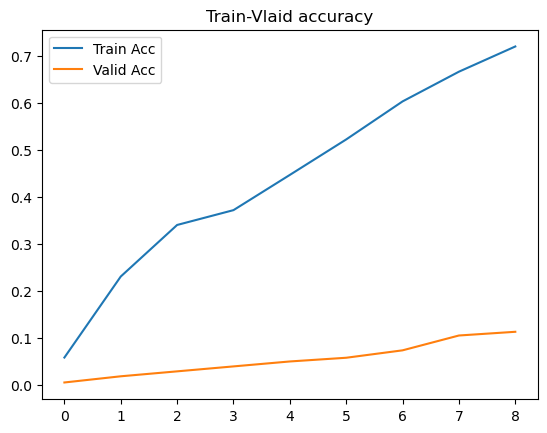

epoch 9 loss: 1.3717:   1%|▌                                         | 1/80 [00:04<05:40,  4.31s/it]

111
222
111
222


epoch 9 loss: 1.3790:   4%|█▌                                        | 3/80 [00:04<01:25,  1.12s/it]

111
222
111
222


epoch 9 loss: 1.3820:   6%|██▋                                       | 5/80 [00:05<00:41,  1.82it/s]

111
222
111
222


epoch 9 loss: 1.3842:   9%|███▋                                      | 7/80 [00:08<01:37,  1.34s/it]

111
222
111
222


epoch 9 loss: 1.3888:  11%|████▋                                     | 9/80 [00:08<00:51,  1.37it/s]

111
222
111
222


epoch 9 loss: 1.3912:  14%|█████▋                                   | 11/80 [00:09<00:31,  2.22it/s]

111
222
111
222


epoch 9 loss: 1.3923:  16%|██████▋                                  | 13/80 [00:12<01:23,  1.25s/it]

111
222
111
222


epoch 9 loss: 1.3939:  19%|███████▋                                 | 15/80 [00:13<00:45,  1.42it/s]

111
222
111
222


epoch 9 loss: 1.3958:  21%|████████▋                                | 17/80 [00:13<00:27,  2.28it/s]

111
222
111
222


epoch 9 loss: 1.3953:  24%|█████████▋                               | 19/80 [00:17<01:21,  1.34s/it]

111
222
111
222


epoch 9 loss: 1.3992:  26%|██████████▊                              | 21/80 [00:17<00:44,  1.33it/s]

111
222
111
222


epoch 9 loss: 1.3989:  29%|███████████▊                             | 23/80 [00:18<00:26,  2.14it/s]

111
222
111
222


epoch 9 loss: 1.4009:  31%|████████████▊                            | 25/80 [00:21<01:05,  1.18s/it]

111
222
111
222


epoch 9 loss: 1.4030:  34%|█████████████▊                           | 27/80 [00:21<00:35,  1.48it/s]

111
222


epoch 9 loss: 1.4053:  35%|██████████████▎                          | 28/80 [00:21<00:28,  1.81it/s]

111
222


epoch 9 loss: 1.4035:  36%|██████████████▊                          | 29/80 [00:22<00:22,  2.24it/s]

111
222
111
222


epoch 9 loss: 1.4043:  39%|███████████████▉                         | 31/80 [00:25<00:57,  1.17s/it]

111
222
111
222


epoch 9 loss: 1.4054:  41%|████████████████▉                        | 33/80 [00:25<00:31,  1.49it/s]

111
222


epoch 9 loss: 1.4051:  42%|█████████████████▍                       | 34/80 [00:25<00:24,  1.86it/s]

111
222


epoch 9 loss: 1.4045:  44%|█████████████████▉                       | 35/80 [00:26<00:19,  2.29it/s]

111
222
111
222


epoch 9 loss: 1.4074:  46%|██████████████████▉                      | 37/80 [00:29<00:51,  1.20s/it]

111
222
111
222


epoch 9 loss: 1.4065:  49%|███████████████████▉                     | 39/80 [00:29<00:28,  1.45it/s]

111
222


epoch 9 loss: 1.4078:  50%|████████████████████▌                    | 40/80 [00:30<00:21,  1.82it/s]

111
222


epoch 9 loss: 1.4083:  51%|█████████████████████                    | 41/80 [00:30<00:17,  2.25it/s]

111
222
111
222


epoch 9 loss: 1.4090:  54%|██████████████████████                   | 43/80 [00:33<00:45,  1.22s/it]

111
222
111
222


epoch 9 loss: 1.4073:  56%|███████████████████████                  | 45/80 [00:34<00:24,  1.44it/s]

111
222
111
222


epoch 9 loss: 1.4074:  59%|████████████████████████                 | 47/80 [00:34<00:14,  2.28it/s]

111
222
111
222


epoch 9 loss: 1.4066:  61%|█████████████████████████                | 49/80 [00:37<00:38,  1.25s/it]

111
222
111
222


epoch 9 loss: 1.4039:  64%|██████████████████████████▏              | 51/80 [00:38<00:20,  1.40it/s]

111
222
111
222


epoch 9 loss: 1.4021:  66%|███████████████████████████▏             | 53/80 [00:38<00:11,  2.25it/s]

111
222
111
222


epoch 9 loss: 1.4013:  69%|████████████████████████████▏            | 55/80 [00:42<00:32,  1.29s/it]

111
222
111
222


epoch 9 loss: 1.4037:  71%|█████████████████████████████▏           | 57/80 [00:42<00:16,  1.37it/s]

111
222
111
222


epoch 9 loss: 1.4015:  74%|██████████████████████████████▏          | 59/80 [00:43<00:09,  2.20it/s]

111
222
111
222


epoch 9 loss: 1.4021:  76%|███████████████████████████████▎         | 61/80 [00:46<00:23,  1.23s/it]

111
222
111
222


epoch 9 loss: 1.4019:  79%|████████████████████████████████▎        | 63/80 [00:46<00:11,  1.43it/s]

111
222
111
222


epoch 9 loss: 1.4001:  81%|█████████████████████████████████▎       | 65/80 [00:47<00:06,  2.25it/s]

111
222
111
222


epoch 9 loss: 1.3954:  84%|██████████████████████████████████▎      | 67/80 [00:50<00:15,  1.23s/it]

111
222
111
222


epoch 9 loss: 1.3950:  86%|███████████████████████████████████▎     | 69/80 [00:51<00:07,  1.43it/s]

111
222
111
222


epoch 9 loss: 1.3905:  89%|████████████████████████████████████▍    | 71/80 [00:51<00:03,  2.27it/s]

111
222
111
222


epoch 9 loss: 1.3895:  91%|█████████████████████████████████████▍   | 73/80 [00:54<00:08,  1.16s/it]

111
222
111
222


epoch 9 loss: 1.3885:  94%|██████████████████████████████████████▍  | 75/80 [00:55<00:03,  1.52it/s]

111
222
111
222


epoch 9 loss: 1.3891:  96%|███████████████████████████████████████▍ | 77/80 [00:55<00:01,  2.43it/s]

111
222
111
222


epoch 9 loss: 1.3891:  99%|████████████████████████████████████████▍| 79/80 [00:58<00:01,  1.04s/it]

111
222
111
222


epoch 9 loss: 1.3940: 100%|█████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.78056
[[54  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 6  0  0 ... 30  0  0]
 [ 0  0  0 ...  0 28  7]
 [ 0  0  0 ...  0  0 55]]



epoch 9 loss: 4.0456: 100%|█████████████████████████████████████████| 38/38 [00:02<00:00, 13.13it/s]


validation accuracy = 0.12368
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


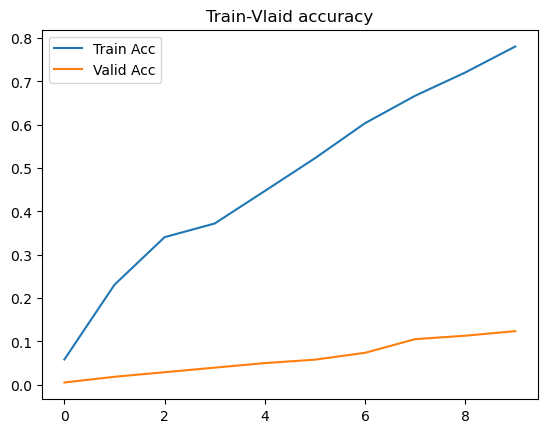

epoch 10 loss: 1.3727:   1%|▌                                        | 1/80 [00:04<05:32,  4.20s/it]

111
222
111
222


epoch 10 loss: 1.3729:   4%|█▌                                       | 3/80 [00:04<01:24,  1.09s/it]

111
222
111
222


epoch 10 loss: 1.3690:   6%|██▌                                      | 5/80 [00:04<00:40,  1.84it/s]

111
222
111
222


epoch 10 loss: 1.3687:   9%|███▌                                     | 7/80 [00:08<01:36,  1.32s/it]

111
222
111


epoch 10 loss: 1.3661:  10%|████                                     | 8/80 [00:08<01:09,  1.04it/s]

222
111


epoch 10 loss: 1.3657:  11%|████▌                                    | 9/80 [00:08<00:51,  1.39it/s]

222
111
222


epoch 10 loss: 1.3657:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.25it/s]

111
222
111
222


epoch 10 loss: 1.3641:  16%|██████▌                                 | 13/80 [00:12<01:19,  1.18s/it]

111
222


epoch 10 loss: 1.3637:  18%|███████                                 | 14/80 [00:12<01:07,  1.02s/it]

111
222


epoch 10 loss: 1.3634:  19%|███████▌                                | 15/80 [00:13<00:49,  1.30it/s]

111
222


epoch 10 loss: 1.3626:  20%|████████                                | 16/80 [00:13<00:39,  1.60it/s]

111
222


epoch 10 loss: 1.3601:  21%|████████▌                               | 17/80 [00:13<00:31,  2.02it/s]

111
222
111
222


epoch 10 loss: 1.3583:  24%|█████████▌                              | 19/80 [00:16<01:04,  1.06s/it]

111
222


epoch 10 loss: 1.3569:  25%|██████████                              | 20/80 [00:17<01:00,  1.01s/it]

111
222


epoch 10 loss: 1.3563:  26%|██████████▌                             | 21/80 [00:17<00:45,  1.31it/s]

111
222
111
222


epoch 10 loss: 1.3548:  29%|███████████▌                            | 23/80 [00:17<00:27,  2.10it/s]

111
222
111
222


epoch 10 loss: 1.3532:  31%|████████████▌                           | 25/80 [00:20<00:55,  1.01s/it]

111
222


epoch 10 loss: 1.3518:  32%|█████████████                           | 26/80 [00:21<00:55,  1.02s/it]

111
222


epoch 10 loss: 1.3517:  34%|█████████████▌                          | 27/80 [00:21<00:41,  1.29it/s]

111
222
111
222


epoch 10 loss: 1.3492:  36%|██████████████▌                         | 29/80 [00:22<00:24,  2.09it/s]

111
222
111
222


epoch 10 loss: 1.3462:  39%|███████████████▌                        | 31/80 [00:24<00:49,  1.00s/it]

111
222


epoch 10 loss: 1.3437:  40%|████████████████                        | 32/80 [00:25<00:48,  1.01s/it]

111
222


epoch 10 loss: 1.3433:  41%|████████████████▌                       | 33/80 [00:26<00:35,  1.31it/s]

111
222
111
222


epoch 10 loss: 1.3385:  44%|█████████████████▌                      | 35/80 [00:26<00:21,  2.11it/s]

111
222
111
222


epoch 10 loss: 1.3338:  46%|██████████████████▌                     | 37/80 [00:28<00:41,  1.04it/s]

111
222


epoch 10 loss: 1.3331:  48%|███████████████████                     | 38/80 [00:30<00:42,  1.02s/it]

111
222


epoch 10 loss: 1.3307:  49%|███████████████████▌                    | 39/80 [00:30<00:31,  1.29it/s]

111
222
111
222


epoch 10 loss: 1.3297:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.08it/s]

111
222
111
222


epoch 10 loss: 1.3244:  54%|█████████████████████▌                  | 43/80 [00:33<00:37,  1.02s/it]

111
222


epoch 10 loss: 1.3231:  55%|██████████████████████                  | 44/80 [00:34<00:34,  1.06it/s]

111
222


epoch 10 loss: 1.3221:  56%|██████████████████████▌                 | 45/80 [00:34<00:25,  1.38it/s]

111
222
111
222


epoch 10 loss: 1.3196:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.22it/s]

111
222
111
222


epoch 10 loss: 1.3148:  61%|████████████████████████▌               | 49/80 [00:37<00:34,  1.12s/it]

111
222


epoch 10 loss: 1.3137:  62%|█████████████████████████               | 50/80 [00:38<00:28,  1.06it/s]

111
222


epoch 10 loss: 1.3115:  64%|█████████████████████████▌              | 51/80 [00:38<00:20,  1.39it/s]

111
222
111
222


epoch 10 loss: 1.3102:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.23it/s]

111
222
111
222


epoch 10 loss: 1.3072:  69%|███████████████████████████▌            | 55/80 [00:42<00:29,  1.19s/it]

111
222


epoch 10 loss: 1.3051:  70%|████████████████████████████            | 56/80 [00:42<00:21,  1.11it/s]

111
222


epoch 10 loss: 1.3025:  71%|████████████████████████████▌           | 57/80 [00:42<00:15,  1.45it/s]

111
222
111
222


epoch 10 loss: 1.2970:  74%|█████████████████████████████▌          | 59/80 [00:43<00:10,  2.10it/s]

111
222
111
222


epoch 10 loss: 1.2927:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.16s/it]

111
222
111
222


epoch 10 loss: 1.2901:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.49it/s]

111
222
111
222


epoch 10 loss: 1.2841:  81%|████████████████████████████████▌       | 65/80 [00:47<00:09,  1.58it/s]

111
222
111
222


epoch 10 loss: 1.2804:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:13,  1.07s/it]

111
222


epoch 10 loss: 1.2787:  85%|██████████████████████████████████      | 68/80 [00:50<00:10,  1.19it/s]

111
222


epoch 10 loss: 1.2776:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.54it/s]

111
222
111
222


epoch 10 loss: 1.2744:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:05,  1.73it/s]

111
222
111
222


epoch 10 loss: 1.2702:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:07,  1.08s/it]

111
222


epoch 10 loss: 1.2673:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.19it/s]

111
222
111


epoch 10 loss: 1.2646:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.55it/s]

222
111
222


epoch 10 loss: 1.2620:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  1.77it/s]

111
222
111


epoch 10 loss: 1.2617:  98%|███████████████████████████████████████ | 78/80 [00:56<00:00,  2.18it/s]

222


epoch 10 loss: 1.2594:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:00,  1.03it/s]

111
222
111
222


epoch 10 loss: 1.2630: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.82285
[[53  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 2  0  0 ... 35  0  0]
 [ 0  0  0 ...  0 33  7]
 [ 0  0  0 ...  0  0 55]]



epoch 10 loss: 3.9728: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.06it/s]


validation accuracy = 0.13947
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


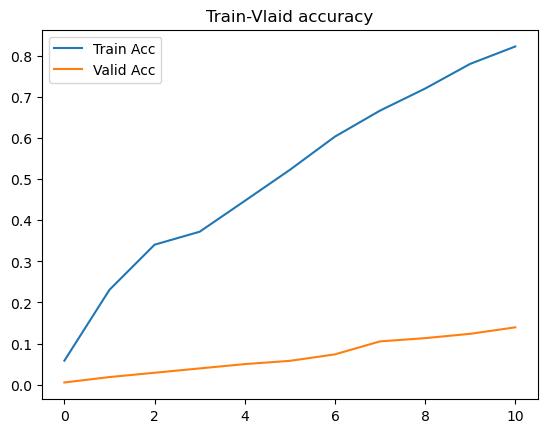

epoch 11 loss: 1.1064:   1%|▌                                        | 1/80 [00:04<05:37,  4.27s/it]

111
222
111
222


epoch 11 loss: 1.1040:   4%|█▌                                       | 3/80 [00:04<01:24,  1.10s/it]

111
222
111
222


epoch 11 loss: 1.1054:   6%|██▌                                      | 5/80 [00:05<00:40,  1.83it/s]

111
222
111
222


epoch 11 loss: 1.1030:   9%|███▌                                     | 7/80 [00:08<01:40,  1.38s/it]

111
222
111
222


epoch 11 loss: 1.0997:  11%|████▌                                    | 9/80 [00:08<00:53,  1.34it/s]

111
222
111
222


epoch 11 loss: 1.0990:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.19it/s]

111
222
111
222


epoch 11 loss: 1.0974:  16%|██████▌                                 | 13/80 [00:12<01:18,  1.18s/it]

111
222


epoch 11 loss: 1.0970:  18%|███████                                 | 14/80 [00:12<00:59,  1.11it/s]

111
222


epoch 11 loss: 1.0971:  19%|███████▌                                | 15/80 [00:13<00:49,  1.30it/s]

111
222
111
222


epoch 11 loss: 1.0943:  21%|████████▌                               | 17/80 [00:13<00:29,  2.11it/s]

111
222
111
222


epoch 11 loss: 1.0937:  24%|█████████▌                              | 19/80 [00:16<01:11,  1.17s/it]

111
222
111
222


epoch 11 loss: 1.0903:  26%|██████████▌                             | 21/80 [00:17<00:41,  1.41it/s]

111
222
111
222


epoch 11 loss: 1.0880:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.22it/s]

111
222
111
222


epoch 11 loss: 1.0860:  31%|████████████▌                           | 25/80 [00:20<01:04,  1.18s/it]

111
222
111
222


epoch 11 loss: 1.0835:  34%|█████████████▌                          | 27/80 [00:21<00:38,  1.37it/s]

111
222
111
222


epoch 11 loss: 1.0801:  36%|██████████████▌                         | 29/80 [00:21<00:23,  2.19it/s]

111
222
111
222


epoch 11 loss: 1.0782:  39%|███████████████▌                        | 31/80 [00:25<00:58,  1.19s/it]

111
222
111
222


epoch 11 loss: 1.0769:  41%|████████████████▌                       | 33/80 [00:25<00:36,  1.30it/s]

111
222
111
222


epoch 11 loss: 1.0764:  44%|█████████████████▌                      | 35/80 [00:26<00:21,  2.10it/s]

111
222
111
222


epoch 11 loss: 1.0769:  46%|██████████████████▌                     | 37/80 [00:29<00:49,  1.14s/it]

111
222
111
222


epoch 11 loss: 1.0756:  49%|███████████████████▌                    | 39/80 [00:30<00:31,  1.31it/s]

111
222
111
222


epoch 11 loss: 1.0722:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.12it/s]

111
222
111
222


epoch 11 loss: 1.0683:  54%|█████████████████████▌                  | 43/80 [00:33<00:41,  1.13s/it]

111
222


epoch 11 loss: 1.0662:  55%|██████████████████████                  | 44/80 [00:33<00:30,  1.17it/s]

111
222


epoch 11 loss: 1.0635:  56%|██████████████████████▌                 | 45/80 [00:34<00:26,  1.31it/s]

111
222
111
222


epoch 11 loss: 1.0631:  59%|███████████████████████▌                | 47/80 [00:34<00:15,  2.13it/s]

111
222
111
222


epoch 11 loss: 1.0620:  61%|████████████████████████▌               | 49/80 [00:37<00:34,  1.11s/it]

111
222


epoch 11 loss: 1.0600:  62%|█████████████████████████               | 50/80 [00:38<00:27,  1.10it/s]

111
222


epoch 11 loss: 1.0568:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.37it/s]

111
222
111
222


epoch 11 loss: 1.0546:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.18it/s]

111
222
111
222


epoch 11 loss: 1.0524:  69%|███████████████████████████▌            | 55/80 [00:41<00:28,  1.12s/it]

111
222


epoch 11 loss: 1.0538:  70%|████████████████████████████            | 56/80 [00:42<00:22,  1.07it/s]

111
222


epoch 11 loss: 1.0505:  71%|████████████████████████████▌           | 57/80 [00:42<00:17,  1.30it/s]

111
222
111
222


epoch 11 loss: 1.0477:  74%|█████████████████████████████▌          | 59/80 [00:43<00:10,  2.10it/s]

111
222
111
222


epoch 11 loss: 1.0460:  76%|██████████████████████████████▌         | 61/80 [00:46<00:21,  1.11s/it]

111
222


epoch 11 loss: 1.0448:  78%|███████████████████████████████         | 62/80 [00:46<00:17,  1.04it/s]

111
222


epoch 11 loss: 1.0443:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.34it/s]

111
222
111
222


epoch 11 loss: 1.0420:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.17it/s]

111
222
111
222


epoch 11 loss: 1.0384:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:14,  1.13s/it]

111
222


epoch 11 loss: 1.0365:  85%|██████████████████████████████████      | 68/80 [00:50<00:11,  1.08it/s]

111
222


epoch 11 loss: 1.0358:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.39it/s]

111
222
111
222


epoch 11 loss: 1.0334:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.20it/s]

111
222
111
222


epoch 11 loss: 1.0300:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.19s/it]

111
222


epoch 11 loss: 1.0285:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.12it/s]

111
222


epoch 11 loss: 1.0287:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.34it/s]

111
222
111
222


epoch 11 loss: 1.0237:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.19it/s]

111
222
111
222


epoch 11 loss: 1.0239:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.02s/it]

111
222
111
222


epoch 11 loss: 1.0239: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.86742
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 2  0  0 ... 40  0  0]
 [ 0  0  1 ...  0 32 13]
 [ 0  0  0 ...  0  0 55]]



epoch 11 loss: 3.9270: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.63it/s]


validation accuracy = 0.15263
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


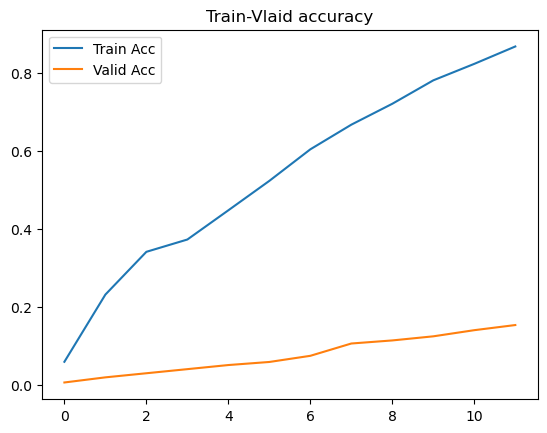

epoch 12 loss: 0.7441:   1%|▌                                        | 1/80 [00:04<05:31,  4.20s/it]

111
222
111
222


epoch 12 loss: 0.7473:   4%|█▌                                       | 3/80 [00:04<01:23,  1.08s/it]

111
222
111
222


epoch 12 loss: 0.7492:   6%|██▌                                      | 5/80 [00:04<00:40,  1.87it/s]

111
222
111
222


epoch 12 loss: 0.7543:   9%|███▌                                     | 7/80 [00:08<01:34,  1.29s/it]

111
222


epoch 12 loss: 0.7558:  10%|████                                     | 8/80 [00:08<01:10,  1.02it/s]

111
222


epoch 12 loss: 0.7561:  11%|████▌                                    | 9/80 [00:08<00:52,  1.36it/s]

111
222
111
222


epoch 12 loss: 0.7565:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.20it/s]

111
222
111
222


epoch 12 loss: 0.7598:  16%|██████▌                                 | 13/80 [00:12<01:17,  1.15s/it]

111
222


epoch 12 loss: 0.7601:  18%|███████                                 | 14/80 [00:12<01:02,  1.06it/s]

111
222


epoch 12 loss: 0.7616:  19%|███████▌                                | 15/80 [00:12<00:47,  1.38it/s]

111
222


epoch 12 loss: 0.7609:  20%|████████                                | 16/80 [00:13<00:37,  1.69it/s]

111
222


epoch 12 loss: 0.7618:  21%|████████▌                               | 17/80 [00:13<00:29,  2.12it/s]

111
222
111
222


epoch 12 loss: 0.7640:  24%|█████████▌                              | 19/80 [00:16<01:11,  1.16s/it]

111
222


epoch 12 loss: 0.7643:  25%|██████████                              | 20/80 [00:16<00:54,  1.11it/s]

111
222


epoch 12 loss: 0.7641:  26%|██████████▌                             | 21/80 [00:17<00:40,  1.44it/s]

111
222


epoch 12 loss: 0.7622:  28%|███████████                             | 22/80 [00:17<00:37,  1.53it/s]

111
222


epoch 12 loss: 0.7625:  29%|███████████▌                            | 23/80 [00:17<00:29,  1.93it/s]

111
222
111
222


epoch 12 loss: 0.7640:  31%|████████████▌                           | 25/80 [00:20<01:02,  1.14s/it]

111
222


epoch 12 loss: 0.7638:  32%|█████████████                           | 26/80 [00:21<00:47,  1.13it/s]

111
222


epoch 12 loss: 0.7620:  34%|█████████████▌                          | 27/80 [00:21<00:36,  1.47it/s]

111
222


epoch 12 loss: 0.7615:  35%|██████████████                          | 28/80 [00:21<00:31,  1.63it/s]

111
222


epoch 12 loss: 0.7619:  36%|██████████████▌                         | 29/80 [00:21<00:24,  2.05it/s]

111
222
111
222


epoch 12 loss: 0.7617:  39%|███████████████▌                        | 31/80 [00:25<00:57,  1.17s/it]

111
222


epoch 12 loss: 0.7629:  40%|████████████████                        | 32/80 [00:25<00:44,  1.07it/s]

111
222


epoch 12 loss: 0.7628:  41%|████████████████▌                       | 33/80 [00:25<00:33,  1.41it/s]

111
222


epoch 12 loss: 0.7633:  42%|█████████████████                       | 34/80 [00:26<00:30,  1.50it/s]

111
222


epoch 12 loss: 0.7639:  44%|█████████████████▌                      | 35/80 [00:26<00:23,  1.91it/s]

111
222
111
222


epoch 12 loss: 0.7647:  46%|██████████████████▌                     | 37/80 [00:29<00:46,  1.08s/it]

111
222


epoch 12 loss: 0.7649:  48%|███████████████████                     | 38/80 [00:29<00:35,  1.18it/s]

111
222


epoch 12 loss: 0.7648:  49%|███████████████████▌                    | 39/80 [00:29<00:26,  1.54it/s]

111
222
111
222


epoch 12 loss: 0.7632:  51%|████████████████████▌                   | 41/80 [00:30<00:22,  1.70it/s]

111
222
111
222


epoch 12 loss: 0.7625:  54%|█████████████████████▌                  | 43/80 [00:33<00:39,  1.08s/it]

111
222
111
222


epoch 12 loss: 0.7617:  56%|██████████████████████▌                 | 45/80 [00:34<00:21,  1.60it/s]

111
222


epoch 12 loss: 0.7625:  57%|███████████████████████                 | 46/80 [00:34<00:23,  1.43it/s]

111
222


epoch 12 loss: 0.7625:  59%|███████████████████████▌                | 47/80 [00:35<00:18,  1.82it/s]

111
222
111
222


epoch 12 loss: 0.7640:  61%|████████████████████████▌               | 49/80 [00:38<00:36,  1.17s/it]

111
222
111
222


epoch 12 loss: 0.7629:  64%|█████████████████████████▌              | 51/80 [00:38<00:19,  1.49it/s]

111
222


epoch 12 loss: 0.7620:  65%|██████████████████████████              | 52/80 [00:39<00:17,  1.63it/s]

111
222


epoch 12 loss: 0.7606:  66%|██████████████████████████▌             | 53/80 [00:39<00:13,  2.04it/s]

111
222
111
222


epoch 12 loss: 0.7585:  69%|███████████████████████████▌            | 55/80 [00:42<00:28,  1.14s/it]

111
222
111
222


epoch 12 loss: 0.7593:  71%|████████████████████████████▌           | 57/80 [00:42<00:15,  1.53it/s]

111
222


epoch 12 loss: 0.7597:  72%|█████████████████████████████           | 58/80 [00:43<00:14,  1.57it/s]

111
222


epoch 12 loss: 0.7599:  74%|█████████████████████████████▌          | 59/80 [00:43<00:10,  1.98it/s]

111
222
111
222


epoch 12 loss: 0.7588:  76%|██████████████████████████████▌         | 61/80 [00:46<00:21,  1.15s/it]

111
222
111
222


epoch 12 loss: 0.7583:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.50it/s]

111
222


epoch 12 loss: 0.7598:  80%|████████████████████████████████        | 64/80 [00:47<00:09,  1.63it/s]

111
222


epoch 12 loss: 0.7593:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  2.05it/s]

111
222
111
222


epoch 12 loss: 0.7574:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:14,  1.10s/it]

111
222
111
222


epoch 12 loss: 0.7576:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.57it/s]

111
222


epoch 12 loss: 0.7568:  88%|███████████████████████████████████     | 70/80 [00:51<00:06,  1.66it/s]

111
222


epoch 12 loss: 0.7567:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.07it/s]

111
222
111
222


epoch 12 loss: 0.7577:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.18s/it]

111
222
111
222


epoch 12 loss: 0.7557:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.48it/s]

111
222


epoch 12 loss: 0.7540:  95%|██████████████████████████████████████  | 76/80 [00:55<00:02,  1.79it/s]

111
222
111
222


epoch 12 loss: 0.7549:  98%|███████████████████████████████████████ | 78/80 [00:55<00:00,  2.77it/s]

111
222


epoch 12 loss: 0.7540:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.02s/it]

111
222
111
222


epoch 12 loss: 0.7540: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.90480
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 48  0  0]
 [ 0  0  0 ...  0 43  5]
 [ 0  0  0 ...  0  0 55]]



epoch 12 loss: 3.8853: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.01it/s]


validation accuracy = 0.16579
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


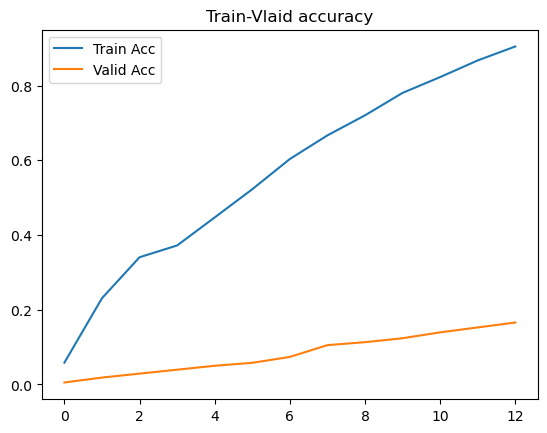

epoch 13 loss: 0.9119:   1%|▌                                        | 1/80 [00:04<05:43,  4.35s/it]

111
222
111
222


epoch 13 loss: 0.9083:   4%|█▌                                       | 3/80 [00:04<01:26,  1.13s/it]

111
222
111
222


epoch 13 loss: 0.9042:   6%|██▌                                      | 5/80 [00:05<00:41,  1.80it/s]

111
222
111
222


epoch 13 loss: 0.8992:   9%|███▌                                     | 7/80 [00:08<01:38,  1.35s/it]

111
222
111
222


epoch 13 loss: 0.8959:  11%|████▌                                    | 9/80 [00:08<00:52,  1.36it/s]

111
222
111
222


epoch 13 loss: 0.8934:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.21it/s]

111
222
111
222


epoch 13 loss: 0.8877:  16%|██████▌                                 | 13/80 [00:12<01:23,  1.24s/it]

111
222
111
222


epoch 13 loss: 0.8840:  19%|███████▌                                | 15/80 [00:13<00:45,  1.43it/s]

111
222
111
222


epoch 13 loss: 0.8783:  21%|████████▌                               | 17/80 [00:13<00:27,  2.28it/s]

111
222
111
222


epoch 13 loss: 0.8746:  24%|█████████▌                              | 19/80 [00:17<01:18,  1.29s/it]

111
222
111
222


epoch 13 loss: 0.8718:  26%|██████████▌                             | 21/80 [00:17<00:43,  1.37it/s]

111
222
111
222


epoch 13 loss: 0.8674:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.20it/s]

111
222
111
222


epoch 13 loss: 0.8616:  31%|████████████▌                           | 25/80 [00:21<01:09,  1.26s/it]

111
222
111
222


epoch 13 loss: 0.8552:  34%|█████████████▌                          | 27/80 [00:21<00:37,  1.40it/s]

111
222
111
222


epoch 13 loss: 0.8508:  36%|██████████████▌                         | 29/80 [00:22<00:22,  2.23it/s]

111
222
111
222


epoch 13 loss: 0.8454:  39%|███████████████▌                        | 31/80 [00:25<00:58,  1.19s/it]

111
222
111
222


epoch 13 loss: 0.8411:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.46it/s]

111
222
111
222


epoch 13 loss: 0.8381:  44%|█████████████████▌                      | 35/80 [00:26<00:19,  2.32it/s]

111
222
111
222


epoch 13 loss: 0.8348:  46%|██████████████████▌                     | 37/80 [00:29<00:54,  1.27s/it]

111
222
111
222


epoch 13 loss: 0.8313:  49%|███████████████████▌                    | 39/80 [00:30<00:29,  1.39it/s]

111
222
111
222


epoch 13 loss: 0.8274:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.21it/s]

111
222
111
222


epoch 13 loss: 0.8249:  54%|█████████████████████▌                  | 43/80 [00:33<00:45,  1.23s/it]

111
222
111
222


epoch 13 loss: 0.8206:  56%|██████████████████████▌                 | 45/80 [00:34<00:24,  1.43it/s]

111
222
111
222


epoch 13 loss: 0.8185:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.26it/s]

111
222
111
222


epoch 13 loss: 0.8136:  61%|████████████████████████▌               | 49/80 [00:38<00:38,  1.24s/it]

111
222
111
222


epoch 13 loss: 0.8081:  64%|█████████████████████████▌              | 51/80 [00:38<00:20,  1.42it/s]

111
222
111
222


epoch 13 loss: 0.8031:  66%|██████████████████████████▌             | 53/80 [00:38<00:11,  2.25it/s]

111
222
111
222


epoch 13 loss: 0.8004:  69%|███████████████████████████▌            | 55/80 [00:42<00:31,  1.24s/it]

111
222
111
222


epoch 13 loss: 0.7976:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.42it/s]

111
222
111
222


epoch 13 loss: 0.7943:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.25it/s]

111
222
111
222


epoch 13 loss: 0.7896:  76%|██████████████████████████████▌         | 61/80 [00:46<00:23,  1.23s/it]

111
222
111
222


epoch 13 loss: 0.7854:  79%|███████████████████████████████▌        | 63/80 [00:47<00:11,  1.43it/s]

111
222
111
222


epoch 13 loss: 0.7804:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.25it/s]

111
222
111
222


epoch 13 loss: 0.7766:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:15,  1.18s/it]

111
222
111
222


epoch 13 loss: 0.7728:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.48it/s]

111
222
111
222


epoch 13 loss: 0.7677:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:03,  2.33it/s]

111
222
111
222


epoch 13 loss: 0.7638:  91%|████████████████████████████████████▌   | 73/80 [00:55<00:09,  1.31s/it]

111
222
111
222


epoch 13 loss: 0.7607:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.37it/s]

111
222
111
222


epoch 13 loss: 0.7595:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.25it/s]

111
222
111
222


epoch 13 loss: 0.7547:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.08s/it]

111
222
111
222


epoch 13 loss: 0.7559: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.36it/s]

333
train accuracy = 0.92222
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 44  1  0]
 [ 0  0  0 ...  0 47  7]
 [ 0  0  0 ...  0  0 55]]



epoch 13 loss: 3.8446: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.07it/s]


validation accuracy = 0.18684
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


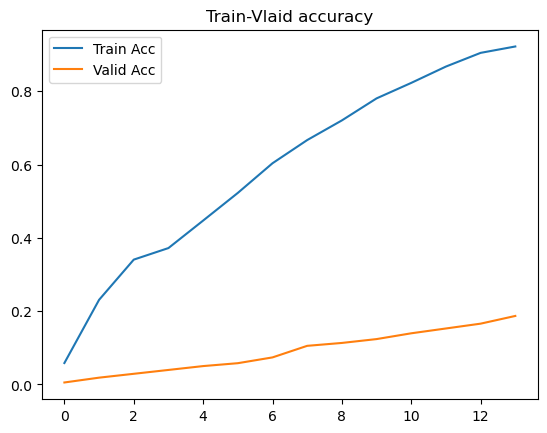

epoch 14 loss: 0.5975:   1%|▌                                        | 1/80 [00:04<05:33,  4.22s/it]

111
222
111
222


epoch 14 loss: 0.5982:   4%|█▌                                       | 3/80 [00:04<01:24,  1.10s/it]

111
222
111
222


epoch 14 loss: 0.5992:   6%|██▌                                      | 5/80 [00:04<00:40,  1.84it/s]

111
222
111
222


epoch 14 loss: 0.5976:   9%|███▌                                     | 7/80 [00:08<01:33,  1.28s/it]

111
222


epoch 14 loss: 0.5975:  10%|████                                     | 8/80 [00:08<01:08,  1.06it/s]

111
222


epoch 14 loss: 0.5973:  11%|████▌                                    | 9/80 [00:08<00:50,  1.40it/s]

111
222
111
222


epoch 14 loss: 0.5963:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.26it/s]

111
222
111
222


epoch 14 loss: 0.5941:  16%|██████▌                                 | 13/80 [00:12<01:23,  1.24s/it]

111
222
111
222


epoch 14 loss: 0.5944:  19%|███████▌                                | 15/80 [00:13<00:50,  1.30it/s]

111
222
111
222


epoch 14 loss: 0.5935:  21%|████████▌                               | 17/80 [00:13<00:29,  2.10it/s]

111
222
111
222


epoch 14 loss: 0.5903:  24%|█████████▌                              | 19/80 [00:16<01:10,  1.16s/it]

111
222
111


epoch 14 loss: 0.5890:  25%|██████████                              | 20/80 [00:16<00:52,  1.15it/s]

222


epoch 14 loss: 0.5891:  26%|██████████▌                             | 21/80 [00:17<00:43,  1.36it/s]

111
222
111
222


epoch 14 loss: 0.5898:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.17it/s]

111
222
111
222


epoch 14 loss: 0.5901:  31%|████████████▌                           | 25/80 [00:20<01:03,  1.16s/it]

111
222
111
222


epoch 14 loss: 0.5881:  34%|█████████████▌                          | 27/80 [00:21<00:38,  1.37it/s]

111
222
111
222


epoch 14 loss: 0.5874:  36%|██████████████▌                         | 29/80 [00:21<00:23,  2.19it/s]

111
222
111
222


epoch 14 loss: 0.5843:  39%|███████████████▌                        | 31/80 [00:25<00:59,  1.22s/it]

111
222
111
222


epoch 14 loss: 0.5826:  41%|████████████████▌                       | 33/80 [00:25<00:33,  1.40it/s]

111
222
111
222


epoch 14 loss: 0.5828:  44%|█████████████████▌                      | 35/80 [00:25<00:20,  2.23it/s]

111
222
111
222


epoch 14 loss: 0.5803:  46%|██████████████████▌                     | 37/80 [00:29<00:51,  1.19s/it]

111
222
111
222


epoch 14 loss: 0.5785:  49%|███████████████████▌                    | 39/80 [00:29<00:28,  1.42it/s]

111
222
111
222


epoch 14 loss: 0.5777:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.26it/s]

111
222
111
222


epoch 14 loss: 0.5773:  54%|█████████████████████▌                  | 43/80 [00:33<00:42,  1.15s/it]

111
222
111
222


epoch 14 loss: 0.5760:  56%|██████████████████████▌                 | 45/80 [00:33<00:25,  1.39it/s]

111
222
111
222


epoch 14 loss: 0.5740:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.21it/s]

111
222
111
222


epoch 14 loss: 0.5718:  61%|████████████████████████▌               | 49/80 [00:37<00:35,  1.15s/it]

111
222


epoch 14 loss: 0.5723:  62%|█████████████████████████               | 50/80 [00:37<00:27,  1.08it/s]

111
222


epoch 14 loss: 0.5709:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.37it/s]

111
222
111
222


epoch 14 loss: 0.5688:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.20it/s]

111
222


epoch 14 loss: 0.5674:  68%|███████████████████████████             | 54/80 [00:38<00:11,  2.23it/s]

111
222


epoch 14 loss: 0.5658:  69%|███████████████████████████▌            | 55/80 [00:41<00:26,  1.07s/it]

111
222


epoch 14 loss: 0.5646:  70%|████████████████████████████            | 56/80 [00:42<00:23,  1.04it/s]

111
222


epoch 14 loss: 0.5662:  71%|████████████████████████████▌           | 57/80 [00:42<00:17,  1.32it/s]

111
222
111
222


epoch 14 loss: 0.5645:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.12it/s]

111
222


epoch 14 loss: 0.5632:  75%|██████████████████████████████          | 60/80 [00:43<00:09,  2.04it/s]

111
222


epoch 14 loss: 0.5643:  76%|██████████████████████████████▌         | 61/80 [00:45<00:18,  1.02it/s]

111
222


epoch 14 loss: 0.5644:  78%|███████████████████████████████         | 62/80 [00:46<00:16,  1.10it/s]

111
222


epoch 14 loss: 0.5636:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.32it/s]

111
222
111
222


epoch 14 loss: 0.5628:  81%|████████████████████████████████▌       | 65/80 [00:46<00:07,  2.13it/s]

111
222


epoch 14 loss: 0.5628:  82%|█████████████████████████████████       | 66/80 [00:47<00:07,  1.89it/s]

111
222


epoch 14 loss: 0.5606:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:12,  1.03it/s]

111
222


epoch 14 loss: 0.5593:  85%|██████████████████████████████████      | 68/80 [00:50<00:10,  1.15it/s]

111
222


epoch 14 loss: 0.5588:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:08,  1.23it/s]

111
222
111
222


epoch 14 loss: 0.5562:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.03it/s]

111
222


epoch 14 loss: 0.5541:  90%|████████████████████████████████████    | 72/80 [00:51<00:04,  1.93it/s]

111
222


epoch 14 loss: 0.5531:  91%|████████████████████████████████████▌   | 73/80 [00:53<00:06,  1.08it/s]

111
222


epoch 14 loss: 0.5520:  92%|█████████████████████████████████████   | 74/80 [00:54<00:04,  1.26it/s]

111
222


epoch 14 loss: 0.5501:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:04,  1.24it/s]

111
222
111
222


epoch 14 loss: 0.5482:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.07it/s]

111
222


epoch 14 loss: 0.5475:  98%|███████████████████████████████████████ | 78/80 [00:55<00:00,  2.17it/s]

111
222


epoch 14 loss: 0.5459:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.21it/s]

111
222
111
222


epoch 14 loss: 0.5497: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]

333
train accuracy = 0.94141
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 48  0  0]
 [ 0  0  0 ...  0 54  0]
 [ 0  0  0 ...  0  0 55]]



epoch 14 loss: 3.8151: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.82it/s]


validation accuracy = 0.18684
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 1]]


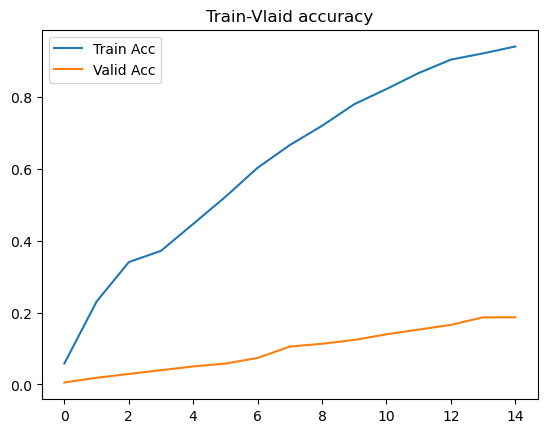

epoch 15 loss: 0.4329:   1%|▌                                        | 1/80 [00:04<05:31,  4.20s/it]

111
222
111


epoch 15 loss: 0.4323:   2%|█                                        | 2/80 [00:04<02:24,  1.85s/it]

222
111

epoch 15 loss: 0.4319:   4%|█▌                                       | 3/80 [00:04<01:24,  1.10s/it]


222
111
222


epoch 15 loss: 0.4327:   6%|██▌                                      | 5/80 [00:04<00:40,  1.84it/s]

111
222
111
222


epoch 15 loss: 0.4313:   9%|███▌                                     | 7/80 [00:08<01:34,  1.30s/it]

111
222
111
222


epoch 15 loss: 0.4329:  11%|████▌                                    | 9/80 [00:08<00:53,  1.33it/s]

111
222


epoch 15 loss: 0.4331:  12%|█████                                   | 10/80 [00:09<00:44,  1.57it/s]

111
222


epoch 15 loss: 0.4328:  14%|█████▌                                  | 11/80 [00:09<00:34,  1.99it/s]

111
222
111
222


epoch 15 loss: 0.4331:  16%|██████▌                                 | 13/80 [00:12<01:16,  1.14s/it]

111
222
111
222


epoch 15 loss: 0.4331:  19%|███████▌                                | 15/80 [00:12<00:46,  1.39it/s]

111
222


epoch 15 loss: 0.4333:  20%|████████                                | 16/80 [00:13<00:41,  1.54it/s]

111
222


epoch 15 loss: 0.4340:  21%|████████▌                               | 17/80 [00:13<00:32,  1.95it/s]

111
222
111
222


epoch 15 loss: 0.4356:  24%|█████████▌                              | 19/80 [00:16<01:11,  1.17s/it]

111
222
111
222


epoch 15 loss: 0.4359:  26%|██████████▌                             | 21/80 [00:17<00:39,  1.49it/s]

111
222


epoch 15 loss: 0.4349:  28%|███████████                             | 22/80 [00:17<00:33,  1.72it/s]

111
222


epoch 15 loss: 0.4353:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.15it/s]

111
222
111
222


epoch 15 loss: 0.4347:  31%|████████████▌                           | 25/80 [00:20<01:04,  1.17s/it]

111
222
111
222


epoch 15 loss: 0.4357:  34%|█████████████▌                          | 27/80 [00:21<00:35,  1.49it/s]

111
222


epoch 15 loss: 0.4363:  35%|██████████████                          | 28/80 [00:21<00:30,  1.72it/s]

111
222


epoch 15 loss: 0.4356:  36%|██████████████▌                         | 29/80 [00:21<00:23,  2.14it/s]

111
222
111
222


epoch 15 loss: 0.4364:  39%|███████████████▌                        | 31/80 [00:25<00:56,  1.15s/it]

111
222
111
222


epoch 15 loss: 0.4353:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.45it/s]

111
222


epoch 15 loss: 0.4363:  42%|█████████████████                       | 34/80 [00:25<00:27,  1.69it/s]

111
222


epoch 15 loss: 0.4358:  44%|█████████████████▌                      | 35/80 [00:26<00:21,  2.11it/s]

111
222
111
222


epoch 15 loss: 0.4347:  46%|██████████████████▌                     | 37/80 [00:29<00:48,  1.13s/it]

111
222
111
222


epoch 15 loss: 0.4352:  49%|███████████████████▌                    | 39/80 [00:29<00:28,  1.42it/s]

111
222


epoch 15 loss: 0.4354:  50%|████████████████████                    | 40/80 [00:29<00:23,  1.73it/s]

111
222


epoch 15 loss: 0.4354:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.15it/s]

111
222
111
222


epoch 15 loss: 0.4354:  54%|█████████████████████▌                  | 43/80 [00:33<00:43,  1.17s/it]

111
222
111
222


epoch 15 loss: 0.4362:  56%|██████████████████████▌                 | 45/80 [00:33<00:24,  1.42it/s]

111
222
111
222


epoch 15 loss: 0.4355:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.26it/s]

111
222
111
222


epoch 15 loss: 0.4335:  61%|████████████████████████▌               | 49/80 [00:37<00:36,  1.17s/it]

111
222
111


epoch 15 loss: 0.4336:  62%|█████████████████████████               | 50/80 [00:37<00:26,  1.14it/s]

222


epoch 15 loss: 0.4326:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.36it/s]

111
222
111
222


epoch 15 loss: 0.4318:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.19it/s]

111
222
111
222


epoch 15 loss: 0.4309:  69%|███████████████████████████▌            | 55/80 [00:41<00:28,  1.15s/it]

111
222
111
222


epoch 15 loss: 0.4312:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.40it/s]

111
222


epoch 15 loss: 0.4304:  72%|█████████████████████████████           | 58/80 [00:42<00:13,  1.66it/s]

111
222


epoch 15 loss: 0.4297:  74%|█████████████████████████████▌          | 59/80 [00:42<00:10,  2.07it/s]

111
222
111
222


epoch 15 loss: 0.4291:  76%|██████████████████████████████▌         | 61/80 [00:45<00:21,  1.14s/it]

111
222
111


epoch 15 loss: 0.4287:  78%|███████████████████████████████         | 62/80 [00:45<00:15,  1.17it/s]

222


epoch 15 loss: 0.4292:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.45it/s]

111
222


epoch 15 loss: 0.4280:  80%|████████████████████████████████        | 64/80 [00:46<00:09,  1.64it/s]

111
222


epoch 15 loss: 0.4280:  81%|████████████████████████████████▌       | 65/80 [00:46<00:07,  2.05it/s]

111
222
111
222


epoch 15 loss: 0.4273:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:14,  1.11s/it]

111
222


epoch 15 loss: 0.4273:  85%|██████████████████████████████████      | 68/80 [00:50<00:10,  1.13it/s]

111
222


epoch 15 loss: 0.4260:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.48it/s]

111
222


epoch 15 loss: 0.4253:  88%|███████████████████████████████████     | 70/80 [00:50<00:05,  1.68it/s]

111
222


epoch 15 loss: 0.4251:  89%|███████████████████████████████████▌    | 71/80 [00:50<00:04,  2.10it/s]

111
222
111
222


epoch 15 loss: 0.4238:  91%|████████████████████████████████████▌   | 73/80 [00:53<00:07,  1.09s/it]

111
222


epoch 15 loss: 0.4223:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.11it/s]

111
222


epoch 15 loss: 0.4221:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.45it/s]

111
222


epoch 15 loss: 0.4214:  95%|██████████████████████████████████████  | 76/80 [00:54<00:02,  1.71it/s]

111
222


epoch 15 loss: 0.4215:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.14it/s]

111
222
111
222


epoch 15 loss: 0.4215:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.02it/s]

111
222
111
222


epoch 15 loss: 0.4229: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]

333
train accuracy = 0.95455
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 53  0  0]
 [ 0  0  0 ...  0 52  1]
 [ 0  0  0 ...  0  0 55]]



epoch 15 loss: 3.8056: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.56it/s]


validation accuracy = 0.20000
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 1]]


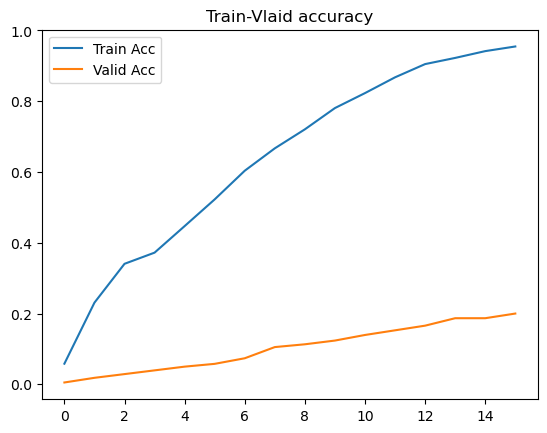

epoch 16 loss: 0.3143:   1%|▌                                        | 1/80 [00:04<05:39,  4.30s/it]

111
222
111
222


epoch 16 loss: 0.3157:   4%|█▌                                       | 3/80 [00:04<01:25,  1.12s/it]

111
222
111
222


epoch 16 loss: 0.3167:   6%|██▌                                      | 5/80 [00:05<00:41,  1.81it/s]

111
222
111
222


epoch 16 loss: 0.3178:   9%|███▌                                     | 7/80 [00:08<01:34,  1.29s/it]

111
222
111
222


epoch 16 loss: 0.3190:  11%|████▌                                    | 9/80 [00:08<00:50,  1.41it/s]

111
222
111
222


epoch 16 loss: 0.3188:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.26it/s]

111
222
111
222


epoch 16 loss: 0.3199:  16%|██████▌                                 | 13/80 [00:12<01:21,  1.22s/it]

111
222
111
222


epoch 16 loss: 0.3196:  19%|███████▌                                | 15/80 [00:12<00:44,  1.45it/s]

111
222
111
222


epoch 16 loss: 0.3197:  21%|████████▌                               | 17/80 [00:13<00:27,  2.31it/s]

111
222
111
222


epoch 16 loss: 0.3206:  24%|█████████▌                              | 19/80 [00:16<01:12,  1.19s/it]

111
222
111
222


epoch 16 loss: 0.3227:  26%|██████████▌                             | 21/80 [00:16<00:40,  1.47it/s]

111
222
111
222


epoch 16 loss: 0.3224:  29%|███████████▌                            | 23/80 [00:17<00:24,  2.31it/s]

111
222
111
222


epoch 16 loss: 0.3231:  31%|████████████▌                           | 25/80 [00:21<01:12,  1.32s/it]

111
222
111
222


epoch 16 loss: 0.3221:  34%|█████████████▌                          | 27/80 [00:21<00:39,  1.34it/s]

111
222
111
222


epoch 16 loss: 0.3220:  36%|██████████████▌                         | 29/80 [00:21<00:23,  2.16it/s]

111
222
111
222


epoch 16 loss: 0.3224:  39%|███████████████▌                        | 31/80 [00:25<00:57,  1.18s/it]

111
222


epoch 16 loss: 0.3214:  40%|████████████████                        | 32/80 [00:25<00:45,  1.04it/s]

111
222


epoch 16 loss: 0.3222:  41%|████████████████▌                       | 33/80 [00:25<00:34,  1.37it/s]

111
222
111
222


epoch 16 loss: 0.3213:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.18it/s]

111
222
111
222


epoch 16 loss: 0.3214:  46%|██████████████████▌                     | 37/80 [00:29<00:49,  1.16s/it]

111
222


epoch 16 loss: 0.3220:  48%|███████████████████                     | 38/80 [00:29<00:37,  1.11it/s]

111
222


epoch 16 loss: 0.3222:  49%|███████████████████▌                    | 39/80 [00:29<00:28,  1.45it/s]

111
222
111
222


epoch 16 loss: 0.3222:  51%|████████████████████▌                   | 41/80 [00:30<00:16,  2.30it/s]

111
222
111
222


epoch 16 loss: 0.3226:  54%|█████████████████████▌                  | 43/80 [00:33<00:42,  1.16s/it]

111
222


epoch 16 loss: 0.3234:  55%|██████████████████████                  | 44/80 [00:33<00:34,  1.05it/s]

111
222


epoch 16 loss: 0.3229:  56%|██████████████████████▌                 | 45/80 [00:34<00:25,  1.38it/s]

111
222
111
222


epoch 16 loss: 0.3229:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.21it/s]

111
222
111
222


epoch 16 loss: 0.3225:  61%|████████████████████████▌               | 49/80 [00:37<00:37,  1.21s/it]

111
222


epoch 16 loss: 0.3217:  62%|█████████████████████████               | 50/80 [00:38<00:30,  1.01s/it]

111
222


epoch 16 loss: 0.3209:  64%|█████████████████████████▌              | 51/80 [00:38<00:22,  1.31it/s]

111
222
111
222


epoch 16 loss: 0.3225:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.12it/s]

111
222
111
222


epoch 16 loss: 0.3221:  69%|███████████████████████████▌            | 55/80 [00:41<00:27,  1.10s/it]

111
222


epoch 16 loss: 0.3223:  70%|████████████████████████████            | 56/80 [00:42<00:23,  1.00it/s]

111
222


epoch 16 loss: 0.3223:  71%|████████████████████████████▌           | 57/80 [00:42<00:17,  1.32it/s]

111
222
111
222


epoch 16 loss: 0.3225:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.13it/s]

111
222
111
222


epoch 16 loss: 0.3226:  76%|██████████████████████████████▌         | 61/80 [00:45<00:19,  1.02s/it]

111
222


epoch 16 loss: 0.3222:  78%|███████████████████████████████         | 62/80 [00:46<00:17,  1.03it/s]

111
222


epoch 16 loss: 0.3220:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.36it/s]

111
222
111
222


epoch 16 loss: 0.3226:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.19it/s]

111
222
111
222


epoch 16 loss: 0.3218:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:13,  1.04s/it]

111
222


epoch 16 loss: 0.3213:  85%|██████████████████████████████████      | 68/80 [00:50<00:11,  1.05it/s]

111
222


epoch 16 loss: 0.3205:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.38it/s]

111
222
111
222


epoch 16 loss: 0.3195:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.20it/s]

111
222
111
222


epoch 16 loss: 0.3183:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:07,  1.00s/it]

111
222


epoch 16 loss: 0.3182:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.06it/s]

111
222
111


epoch 16 loss: 0.3183:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.40it/s]

222
111
222


epoch 16 loss: 0.3174:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.26it/s]

111
222
111
222


epoch 16 loss: 0.3213:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.11it/s]

111
222
111
222


epoch 16 loss: 0.3213: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]

333
train accuracy = 0.97159
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 54  1]
 [ 0  0  0 ...  0  0 55]]



epoch 16 loss: 3.8116: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.58it/s]


validation accuracy = 0.18158
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


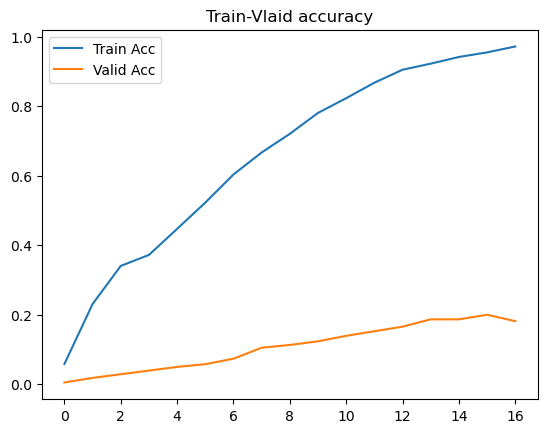

epoch 17 loss: 0.2588:   1%|▌                                        | 1/80 [00:04<05:33,  4.22s/it]

111
222
111
222


epoch 17 loss: 0.2589:   4%|█▌                                       | 3/80 [00:04<01:24,  1.10s/it]

111
222
111
222


epoch 17 loss: 0.2595:   6%|██▌                                      | 5/80 [00:04<00:40,  1.84it/s]

111
222
111
222


epoch 17 loss: 0.2593:   9%|███▌                                     | 7/80 [00:08<01:38,  1.35s/it]

111
222
111
222


epoch 17 loss: 0.2603:  11%|████▌                                    | 9/80 [00:08<00:52,  1.36it/s]

111
222
111
222


epoch 17 loss: 0.2607:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.21it/s]

111
222
111
222


epoch 17 loss: 0.2611:  16%|██████▌                                 | 13/80 [00:12<01:22,  1.23s/it]

111
222
111
222


epoch 17 loss: 0.2605:  19%|███████▌                                | 15/80 [00:13<00:48,  1.33it/s]

111
222
111
222


epoch 17 loss: 0.2609:  21%|████████▌                               | 17/80 [00:13<00:29,  2.16it/s]

111
222
111
222


epoch 17 loss: 0.2609:  24%|█████████▌                              | 19/80 [00:16<01:10,  1.16s/it]

111
222


epoch 17 loss: 0.2615:  25%|██████████                              | 20/80 [00:17<00:55,  1.07it/s]

111
222


epoch 17 loss: 0.2623:  26%|██████████▌                             | 21/80 [00:17<00:45,  1.30it/s]

111
222
111
222


epoch 17 loss: 0.2644:  29%|███████████▌                            | 23/80 [00:17<00:27,  2.10it/s]

111
222
111
222


epoch 17 loss: 0.2646:  31%|████████████▌                           | 25/80 [00:21<01:03,  1.16s/it]

111
222
111
222


epoch 17 loss: 0.2650:  34%|█████████████▌                          | 27/80 [00:21<00:42,  1.24it/s]

111
222
111
222


epoch 17 loss: 0.2644:  36%|██████████████▌                         | 29/80 [00:22<00:25,  2.03it/s]

111
222
111
222


epoch 17 loss: 0.2635:  39%|███████████████▌                        | 31/80 [00:24<00:51,  1.05s/it]

111
222


epoch 17 loss: 0.2634:  40%|████████████████                        | 32/80 [00:25<00:42,  1.14it/s]

111
222


epoch 17 loss: 0.2637:  41%|████████████████▌                       | 33/80 [00:26<00:38,  1.23it/s]

111
222
111
222


epoch 17 loss: 0.2655:  44%|█████████████████▌                      | 35/80 [00:26<00:22,  2.01it/s]

111
222
111
222


epoch 17 loss: 0.2660:  46%|██████████████████▌                     | 37/80 [00:29<00:45,  1.07s/it]

111
222


epoch 17 loss: 0.2660:  48%|███████████████████                     | 38/80 [00:29<00:35,  1.18it/s]

111
222


epoch 17 loss: 0.2657:  49%|███████████████████▌                    | 39/80 [00:30<00:31,  1.32it/s]

111
222
111
222


epoch 17 loss: 0.2664:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.13it/s]

111
222
111
222


epoch 17 loss: 0.2665:  54%|█████████████████████▌                  | 43/80 [00:33<00:42,  1.14s/it]

111
222
111
222


epoch 17 loss: 0.2662:  56%|██████████████████████▌                 | 45/80 [00:34<00:26,  1.30it/s]

111
222
111
222


epoch 17 loss: 0.2659:  59%|███████████████████████▌                | 47/80 [00:34<00:15,  2.11it/s]

111
222
111
222


epoch 17 loss: 0.2662:  61%|████████████████████████▌               | 49/80 [00:37<00:34,  1.12s/it]

111
222


epoch 17 loss: 0.2662:  62%|█████████████████████████               | 50/80 [00:38<00:28,  1.06it/s]

111
222


epoch 17 loss: 0.2662:  64%|█████████████████████████▌              | 51/80 [00:38<00:23,  1.26it/s]

111
222
111
222


epoch 17 loss: 0.2652:  66%|██████████████████████████▌             | 53/80 [00:39<00:13,  2.06it/s]

111
222
111
222


epoch 17 loss: 0.2659:  69%|███████████████████████████▌            | 55/80 [00:42<00:28,  1.13s/it]

111
222


epoch 17 loss: 0.2658:  70%|████████████████████████████            | 56/80 [00:42<00:20,  1.15it/s]

111
222


epoch 17 loss: 0.2659:  71%|████████████████████████████▌           | 57/80 [00:43<00:18,  1.22it/s]

111
222
111
222


epoch 17 loss: 0.2660:  74%|█████████████████████████████▌          | 59/80 [00:43<00:10,  2.00it/s]

111
222
111
222


epoch 17 loss: 0.2658:  76%|██████████████████████████████▌         | 61/80 [00:46<00:21,  1.13s/it]

111
222
111
222


epoch 17 loss: 0.2650:  79%|███████████████████████████████▌        | 63/80 [00:47<00:14,  1.20it/s]

111
222
111
222


epoch 17 loss: 0.2653:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  1.97it/s]

111
222
111
222


epoch 17 loss: 0.2650:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:13,  1.02s/it]

111
222


epoch 17 loss: 0.2645:  85%|██████████████████████████████████      | 68/80 [00:50<00:09,  1.22it/s]

111
222


epoch 17 loss: 0.2632:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:08,  1.23it/s]

111
222
111
222


epoch 17 loss: 0.2629:  89%|███████████████████████████████████▌    | 71/80 [00:52<00:04,  2.01it/s]

111
222
111
222


epoch 17 loss: 0.2617:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:07,  1.04s/it]

111
222


epoch 17 loss: 0.2618:  92%|█████████████████████████████████████   | 74/80 [00:55<00:04,  1.22it/s]

111
222


epoch 17 loss: 0.2616:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.28it/s]

111
222
111
222


epoch 17 loss: 0.2610:  96%|██████████████████████████████████████▌ | 77/80 [00:56<00:01,  2.12it/s]

111
222
111
222


epoch 17 loss: 0.2604:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:00,  1.09it/s]

111
222
111
222


epoch 17 loss: 0.2656: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.97588
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 51  4]
 [ 0  0  0 ...  0  0 55]]



epoch 17 loss: 3.8160: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.51it/s]


validation accuracy = 0.20526
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 1]]


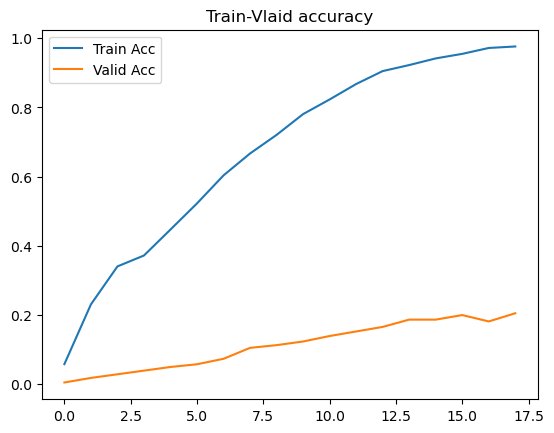

epoch 18 loss: 0.2503:   1%|▌                                        | 1/80 [00:04<05:38,  4.29s/it]

111
222
111
222


epoch 18 loss: 0.2492:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 18 loss: 0.2495:   6%|██▌                                      | 5/80 [00:05<00:41,  1.83it/s]

111
222
111
222


epoch 18 loss: 0.2500:   9%|███▌                                     | 7/80 [00:08<01:36,  1.33s/it]

111
222
111
222


epoch 18 loss: 0.2493:  11%|████▌                                    | 9/80 [00:08<00:51,  1.38it/s]

111
222
111
222


epoch 18 loss: 0.2489:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.24it/s]

111
222
111
222


epoch 18 loss: 0.2495:  16%|██████▌                                 | 13/80 [00:12<01:26,  1.30s/it]

111
222
111
222


epoch 18 loss: 0.2492:  19%|███████▌                                | 15/80 [00:13<00:47,  1.37it/s]

111
222
111
222


epoch 18 loss: 0.2481:  21%|████████▌                               | 17/80 [00:13<00:28,  2.20it/s]

111
222
111
222


epoch 18 loss: 0.2478:  24%|█████████▌                              | 19/80 [00:16<01:14,  1.21s/it]

111
222
111
222


epoch 18 loss: 0.2478:  26%|██████████▌                             | 21/80 [00:17<00:40,  1.44it/s]

111
222
111
222


epoch 18 loss: 0.2463:  29%|███████████▌                            | 23/80 [00:17<00:24,  2.29it/s]

111
222
111
222


epoch 18 loss: 0.2463:  31%|████████████▌                           | 25/80 [00:21<01:09,  1.26s/it]

111
222
111
222


epoch 18 loss: 0.2457:  34%|█████████████▌                          | 27/80 [00:21<00:39,  1.35it/s]

111
222
111
222


epoch 18 loss: 0.2445:  36%|██████████████▌                         | 29/80 [00:22<00:23,  2.16it/s]

111
222
111
222


epoch 18 loss: 0.2446:  39%|███████████████▌                        | 31/80 [00:25<00:58,  1.19s/it]

111
222
111
222


epoch 18 loss: 0.2452:  41%|████████████████▌                       | 33/80 [00:25<00:33,  1.41it/s]

111
222
111
222


epoch 18 loss: 0.2455:  44%|█████████████████▌                      | 35/80 [00:26<00:19,  2.25it/s]

111
222
111
222


epoch 18 loss: 0.2453:  46%|██████████████████▌                     | 37/80 [00:29<00:51,  1.19s/it]

111
222
111
222


epoch 18 loss: 0.2448:  49%|███████████████████▌                    | 39/80 [00:30<00:33,  1.22it/s]

111
222
111
222


epoch 18 loss: 0.2458:  51%|████████████████████▌                   | 41/80 [00:30<00:19,  2.00it/s]

111
222
111
222


epoch 18 loss: 0.2454:  54%|█████████████████████▌                  | 43/80 [00:33<00:39,  1.06s/it]

111
222
111
222


epoch 18 loss: 0.2443:  56%|██████████████████████▌                 | 45/80 [00:34<00:27,  1.26it/s]

111
222
111
222


epoch 18 loss: 0.2432:  59%|███████████████████████▌                | 47/80 [00:34<00:16,  2.06it/s]

111
222
111
222


epoch 18 loss: 0.2419:  61%|████████████████████████▌               | 49/80 [00:37<00:33,  1.08s/it]

111
222
111
222


epoch 18 loss: 0.2412:  64%|█████████████████████████▌              | 51/80 [00:38<00:23,  1.25it/s]

111
222
111
222


epoch 18 loss: 0.2404:  66%|██████████████████████████▌             | 53/80 [00:39<00:13,  2.04it/s]

111
222
111
222


epoch 18 loss: 0.2404:  69%|███████████████████████████▌            | 55/80 [00:42<00:28,  1.13s/it]

111
222
111
222


epoch 18 loss: 0.2400:  71%|████████████████████████████▌           | 57/80 [00:42<00:17,  1.35it/s]

111
222
111
222


epoch 18 loss: 0.2391:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.17it/s]

111
222
111
222


epoch 18 loss: 0.2390:  76%|██████████████████████████████▌         | 61/80 [00:46<00:21,  1.11s/it]

111
222
111
222


epoch 18 loss: 0.2381:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.31it/s]

111
222
111
222


epoch 18 loss: 0.2374:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  2.13it/s]

111
222
111
222


epoch 18 loss: 0.2370:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:15,  1.16s/it]

111
222
111
222


epoch 18 loss: 0.2362:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.38it/s]

111
222
111
222


epoch 18 loss: 0.2350:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.21it/s]

111
222
111
222


epoch 18 loss: 0.2346:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.25s/it]

111
222
111
222


epoch 18 loss: 0.2336:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.43it/s]

111
222
111
222


epoch 18 loss: 0.2331:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.32it/s]

111
222
111
222


epoch 18 loss: 0.2327:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.08s/it]

111
222
111
222


epoch 18 loss: 0.2368: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.36it/s]

333
train accuracy = 0.98220
[[54  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 53  1]
 [ 0  0  0 ...  0  0 55]]



epoch 18 loss: 3.8278: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.61it/s]


validation accuracy = 0.20263
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 1]]


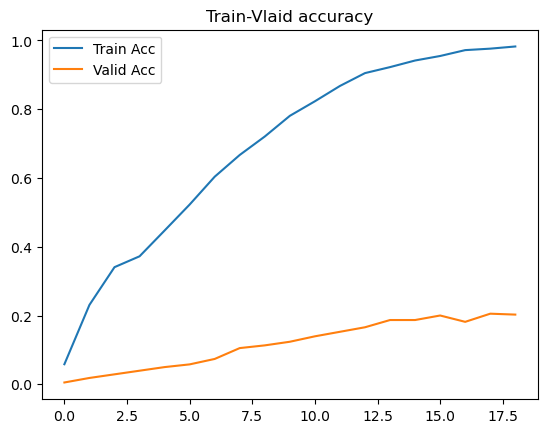

epoch 19 loss: 0.2425:   1%|▌                                        | 1/80 [00:04<05:33,  4.22s/it]

111
222
111
222


epoch 19 loss: 0.2419:   4%|█▌                                       | 3/80 [00:04<01:24,  1.09s/it]

111
222
111
222


epoch 19 loss: 0.2412:   6%|██▌                                      | 5/80 [00:04<00:40,  1.84it/s]

111
222
111
222


epoch 19 loss: 0.2399:   9%|███▌                                     | 7/80 [00:08<01:36,  1.32s/it]

111
222
111
222


epoch 19 loss: 0.2381:  11%|████▌                                    | 9/80 [00:08<00:51,  1.39it/s]

111
222
111
222


epoch 19 loss: 0.2364:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.24it/s]

111
222
111
222


epoch 19 loss: 0.2361:  16%|██████▌                                 | 13/80 [00:12<01:21,  1.22s/it]

111
222
111
222


epoch 19 loss: 0.2354:  19%|███████▌                                | 15/80 [00:12<00:44,  1.45it/s]

111
222
111
222


epoch 19 loss: 0.2346:  21%|████████▌                               | 17/80 [00:13<00:27,  2.28it/s]

111
222
111
222


epoch 19 loss: 0.2345:  24%|█████████▌                              | 19/80 [00:16<01:14,  1.22s/it]

111
222
111
222


epoch 19 loss: 0.2327:  26%|██████████▌                             | 21/80 [00:17<00:42,  1.38it/s]

111
222
111
222


epoch 19 loss: 0.2316:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.21it/s]

111
222
111
222


epoch 19 loss: 0.2303:  31%|████████████▌                           | 25/80 [00:20<01:05,  1.18s/it]

111
222
111
222


epoch 19 loss: 0.2293:  34%|█████████████▌                          | 27/80 [00:21<00:37,  1.42it/s]

111
222


epoch 19 loss: 0.2292:  35%|██████████████                          | 28/80 [00:21<00:31,  1.65it/s]

111
222


epoch 19 loss: 0.2289:  36%|██████████████▌                         | 29/80 [00:21<00:24,  2.06it/s]

111
222
111
222


epoch 19 loss: 0.2283:  39%|███████████████▌                        | 31/80 [00:25<00:59,  1.21s/it]

111
222
111
222


epoch 19 loss: 0.2270:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.45it/s]

111
222


epoch 19 loss: 0.2268:  42%|█████████████████                       | 34/80 [00:25<00:25,  1.81it/s]

111
222


epoch 19 loss: 0.2263:  44%|█████████████████▌                      | 35/80 [00:25<00:20,  2.24it/s]

111
222
111
222


epoch 19 loss: 0.2249:  46%|██████████████████▌                     | 37/80 [00:29<00:50,  1.17s/it]

111
222
111
222


epoch 19 loss: 0.2240:  49%|███████████████████▌                    | 39/80 [00:29<00:29,  1.38it/s]

111
222


epoch 19 loss: 0.2233:  50%|████████████████████                    | 40/80 [00:29<00:23,  1.73it/s]

111
222


epoch 19 loss: 0.2232:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.14it/s]

111
222
111
222


epoch 19 loss: 0.2225:  54%|█████████████████████▌                  | 43/80 [00:33<00:42,  1.15s/it]

111
222
111
222


epoch 19 loss: 0.2220:  56%|██████████████████████▌                 | 45/80 [00:34<00:27,  1.29it/s]

111
222
111
222


epoch 19 loss: 0.2207:  59%|███████████████████████▌                | 47/80 [00:34<00:15,  2.09it/s]

111
222
111
222


epoch 19 loss: 0.2194:  61%|████████████████████████▌               | 49/80 [00:37<00:36,  1.16s/it]

111
222
111
222


epoch 19 loss: 0.2185:  64%|█████████████████████████▌              | 51/80 [00:38<00:22,  1.26it/s]

111
222
111
222


epoch 19 loss: 0.2183:  66%|██████████████████████████▌             | 53/80 [00:38<00:13,  2.04it/s]

111
222
111
222


epoch 19 loss: 0.2175:  69%|███████████████████████████▌            | 55/80 [00:41<00:28,  1.13s/it]

111
222
111
222


epoch 19 loss: 0.2170:  71%|████████████████████████████▌           | 57/80 [00:42<00:17,  1.31it/s]

111
222
111
222


epoch 19 loss: 0.2165:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.11it/s]

111
222
111
222


epoch 19 loss: 0.2157:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.16s/it]

111
222
111
222


epoch 19 loss: 0.2146:  79%|███████████████████████████████▌        | 63/80 [00:46<00:13,  1.29it/s]

111
222
111
222


epoch 19 loss: 0.2141:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  2.09it/s]

111
222
111
222


epoch 19 loss: 0.2127:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:15,  1.17s/it]

111
222
111
222


epoch 19 loss: 0.2121:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:08,  1.36it/s]

111
222
111
222


epoch 19 loss: 0.2113:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.21it/s]

111
222
111
222


epoch 19 loss: 0.2111:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.15s/it]

111
222
111
222


epoch 19 loss: 0.2093:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.36it/s]

111
222
111
222


epoch 19 loss: 0.2078:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.23it/s]

111
222
111
222


epoch 19 loss: 0.2067:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.01s/it]

111
222
111
222


epoch 19 loss: 0.2089: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.98889
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 54  1]
 [ 0  0  0 ...  0  0 55]]



epoch 19 loss: 3.8602: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.38it/s]


validation accuracy = 0.18947
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]


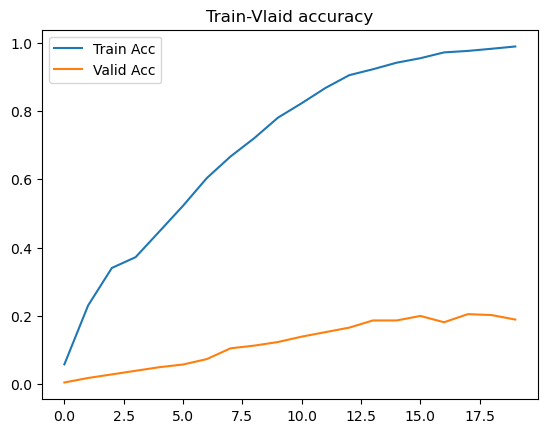

epoch 20 loss: 0.1362:   1%|▌                                        | 1/80 [00:04<05:36,  4.25s/it]

111
222
111
222


epoch 20 loss: 0.1361:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 20 loss: 0.1364:   6%|██▌                                      | 5/80 [00:05<00:40,  1.83it/s]

111
222
111
222


epoch 20 loss: 0.1372:   9%|███▌                                     | 7/80 [00:08<01:37,  1.34s/it]

111
222
111
222


epoch 20 loss: 0.1373:  11%|████▌                                    | 9/80 [00:08<00:51,  1.37it/s]

111
222
111
222


epoch 20 loss: 0.1383:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.23it/s]

111
222
111
222


epoch 20 loss: 0.1387:  16%|██████▌                                 | 13/80 [00:12<01:23,  1.25s/it]

111
222
111
222


epoch 20 loss: 0.1394:  19%|███████▌                                | 15/80 [00:13<00:45,  1.41it/s]

111
222
111
222


epoch 20 loss: 0.1397:  21%|████████▌                               | 17/80 [00:13<00:28,  2.25it/s]

111
222
111
222


epoch 20 loss: 0.1399:  24%|█████████▌                              | 19/80 [00:16<01:15,  1.24s/it]

111
222
111
222


epoch 20 loss: 0.1405:  26%|██████████▌                             | 21/80 [00:17<00:41,  1.41it/s]

111
222
111
222


epoch 20 loss: 0.1408:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.24it/s]

111
222
111
222


epoch 20 loss: 0.1418:  31%|████████████▌                           | 25/80 [00:21<01:11,  1.30s/it]

111
222
111
222


epoch 20 loss: 0.1419:  34%|█████████████▌                          | 27/80 [00:21<00:38,  1.36it/s]

111
222
111
222


epoch 20 loss: 0.1427:  36%|██████████████▌                         | 29/80 [00:22<00:23,  2.17it/s]

111
222
111
222


epoch 20 loss: 0.1435:  39%|███████████████▌                        | 31/80 [00:25<00:59,  1.21s/it]

111
222
111
222


epoch 20 loss: 0.1434:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.45it/s]

111
222
111
222


epoch 20 loss: 0.1431:  44%|█████████████████▌                      | 35/80 [00:26<00:19,  2.29it/s]

111
222
111
222


epoch 20 loss: 0.1432:  46%|██████████████████▌                     | 37/80 [00:29<00:53,  1.25s/it]

111
222
111
222


epoch 20 loss: 0.1429:  49%|███████████████████▌                    | 39/80 [00:30<00:29,  1.40it/s]

111
222
111
222


epoch 20 loss: 0.1423:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.24it/s]

111
222
111
222


epoch 20 loss: 0.1418:  54%|█████████████████████▌                  | 43/80 [00:33<00:44,  1.20s/it]

111
222
111
222


epoch 20 loss: 0.1420:  56%|██████████████████████▌                 | 45/80 [00:34<00:23,  1.46it/s]

111
222
111
222


epoch 20 loss: 0.1424:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.31it/s]

111
222
111
222


epoch 20 loss: 0.1427:  61%|████████████████████████▌               | 49/80 [00:37<00:37,  1.20s/it]

111
222
111
222


epoch 20 loss: 0.1425:  64%|█████████████████████████▌              | 51/80 [00:38<00:19,  1.46it/s]

111
222
111
222


epoch 20 loss: 0.1428:  66%|██████████████████████████▌             | 53/80 [00:38<00:11,  2.31it/s]

111
222
111
222


epoch 20 loss: 0.1438:  69%|███████████████████████████▌            | 55/80 [00:42<00:30,  1.20s/it]

111
222
111
222


epoch 20 loss: 0.1437:  71%|████████████████████████████▌           | 57/80 [00:42<00:15,  1.45it/s]

111
222
111
222


epoch 20 loss: 0.1433:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.27it/s]

111
222
111
222


epoch 20 loss: 0.1439:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.19s/it]

111
222
111
222


epoch 20 loss: 0.1447:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.47it/s]

111
222


epoch 20 loss: 0.1450:  80%|████████████████████████████████        | 64/80 [00:46<00:09,  1.70it/s]

111
222


epoch 20 loss: 0.1455:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  2.13it/s]

111
222
111
222


epoch 20 loss: 0.1458:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:15,  1.18s/it]

111
222
111
222


epoch 20 loss: 0.1450:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.48it/s]

111
222


epoch 20 loss: 0.1445:  88%|███████████████████████████████████     | 70/80 [00:51<00:06,  1.64it/s]

111
222


epoch 20 loss: 0.1440:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.06it/s]

111
222
111
222


epoch 20 loss: 0.1435:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.16s/it]

111
222
111
222


epoch 20 loss: 0.1432:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.51it/s]

111
222


epoch 20 loss: 0.1429:  95%|██████████████████████████████████████  | 76/80 [00:55<00:02,  1.61it/s]

111
222
111


epoch 20 loss: 0.1430:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.05it/s]

222
111
222


epoch 20 loss: 0.1433:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.01s/it]

111
222
111
222


epoch 20 loss: 0.1452: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.99078
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 54  1]
 [ 0  0  0 ...  0  0 55]]



epoch 20 loss: 3.8941: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.87it/s]


validation accuracy = 0.19474
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


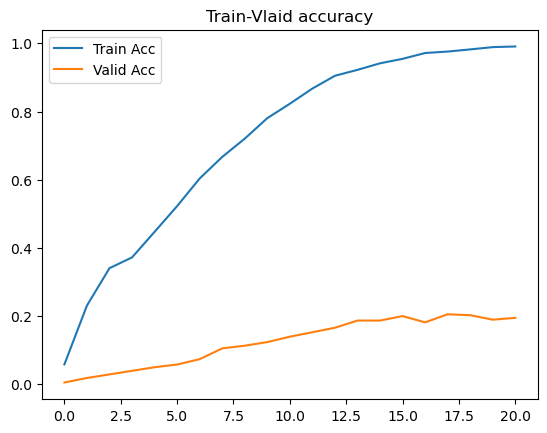

epoch 21 loss: 0.0853:   1%|▌                                        | 1/80 [00:04<05:38,  4.28s/it]

111
222


epoch 21 loss: 0.0858:   2%|█                                        | 2/80 [00:04<02:27,  1.90s/it]

111
222


epoch 21 loss: 0.0872:   4%|█▌                                       | 3/80 [00:04<01:26,  1.12s/it]

111
222
111
222


epoch 21 loss: 0.0880:   6%|██▌                                      | 5/80 [00:05<00:41,  1.80it/s]

111
222
111
222


epoch 21 loss: 0.0887:   9%|███▌                                     | 7/80 [00:08<01:38,  1.35s/it]

111
222
111
222


epoch 21 loss: 0.0894:  11%|████▌                                    | 9/80 [00:08<00:52,  1.36it/s]

111
222
111
222


epoch 21 loss: 0.0902:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.20it/s]

111
222
111
222


epoch 21 loss: 0.0908:  16%|██████▌                                 | 13/80 [00:12<01:23,  1.24s/it]

111
222
111
222


epoch 21 loss: 0.0917:  19%|███████▌                                | 15/80 [00:13<00:45,  1.42it/s]

111
222
111
222


epoch 21 loss: 0.0928:  21%|████████▌                               | 17/80 [00:13<00:27,  2.26it/s]

111
222
111
222


epoch 21 loss: 0.0933:  24%|█████████▌                              | 19/80 [00:17<01:20,  1.32s/it]

111
222
111
222


epoch 21 loss: 0.0942:  26%|██████████▌                             | 21/80 [00:17<00:43,  1.35it/s]

111
222
111
222


epoch 21 loss: 0.0953:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.19it/s]

111
222
111
222


epoch 21 loss: 0.0955:  31%|████████████▌                           | 25/80 [00:21<01:12,  1.32s/it]

111
222
111
222


epoch 21 loss: 0.0963:  34%|█████████████▌                          | 27/80 [00:22<00:39,  1.34it/s]

111
222
111
222


epoch 21 loss: 0.0967:  36%|██████████████▌                         | 29/80 [00:22<00:23,  2.14it/s]

111
222
111
222


epoch 21 loss: 0.0974:  39%|███████████████▌                        | 31/80 [00:25<00:59,  1.21s/it]

111
222
111
222


epoch 21 loss: 0.0979:  41%|████████████████▌                       | 33/80 [00:26<00:32,  1.45it/s]

111
222
111
222


epoch 21 loss: 0.0987:  44%|█████████████████▌                      | 35/80 [00:26<00:19,  2.28it/s]

111
222
111
222


epoch 21 loss: 0.0994:  46%|██████████████████▌                     | 37/80 [00:29<00:51,  1.20s/it]

111
222


epoch 21 loss: 0.0998:  48%|███████████████████                     | 38/80 [00:30<00:38,  1.10it/s]

111
222


epoch 21 loss: 0.1000:  49%|███████████████████▌                    | 39/80 [00:30<00:28,  1.43it/s]

111
222
111
222


epoch 21 loss: 0.1004:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.27it/s]

111
222
111
222


epoch 21 loss: 0.1011:  54%|█████████████████████▌                  | 43/80 [00:34<00:44,  1.20s/it]

111
222
111
222


epoch 21 loss: 0.1019:  56%|██████████████████████▌                 | 45/80 [00:34<00:24,  1.46it/s]

111
222
111
222


epoch 21 loss: 0.1021:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.31it/s]

111
222
111
222


epoch 21 loss: 0.1029:  61%|████████████████████████▌               | 49/80 [00:38<00:41,  1.33s/it]

111
222
111
222


epoch 21 loss: 0.1035:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.32it/s]

111
222
111
222


epoch 21 loss: 0.1035:  66%|██████████████████████████▌             | 53/80 [00:39<00:12,  2.14it/s]

111
222
111
222


epoch 21 loss: 0.1044:  69%|███████████████████████████▌            | 55/80 [00:42<00:30,  1.23s/it]

111
222
111
222


epoch 21 loss: 0.1044:  71%|████████████████████████████▌           | 57/80 [00:43<00:16,  1.43it/s]

111
222
111
222


epoch 21 loss: 0.1051:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.29it/s]

111
222
111
222


epoch 21 loss: 0.1056:  76%|██████████████████████████████▌         | 61/80 [00:47<00:25,  1.36s/it]

111
222
111
222


epoch 21 loss: 0.1058:  79%|███████████████████████████████▌        | 63/80 [00:47<00:13,  1.31it/s]

111
222
111
222


epoch 21 loss: 0.1060:  81%|████████████████████████████████▌       | 65/80 [00:48<00:07,  2.12it/s]

111
222
111
222


epoch 21 loss: 0.1068:  84%|█████████████████████████████████▌      | 67/80 [00:51<00:15,  1.21s/it]

111
222
111
222


epoch 21 loss: 0.1069:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.45it/s]

111
222
111
222


epoch 21 loss: 0.1070:  89%|███████████████████████████████████▌    | 71/80 [00:52<00:03,  2.31it/s]

111
222
111
222


epoch 21 loss: 0.1066:  91%|████████████████████████████████████▌   | 73/80 [00:55<00:08,  1.17s/it]

111
222
111
222


epoch 21 loss: 0.1069:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.51it/s]

111
222
111
222


epoch 21 loss: 0.1069:  96%|██████████████████████████████████████▌ | 77/80 [00:56<00:01,  2.42it/s]

111
222
111
222


epoch 21 loss: 0.1105:  99%|███████████████████████████████████████▌| 79/80 [00:59<00:01,  1.06s/it]

111
222
111
222


epoch 21 loss: 0.1105: 100%|████████████████████████████████████████| 80/80 [00:59<00:00,  1.35it/s]

333
train accuracy = 0.99369
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 54  0  0]
 [ 0  0  0 ...  0 53  2]
 [ 0  0  0 ...  0  0 55]]



epoch 21 loss: 3.8971: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.76it/s]


validation accuracy = 0.20000
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


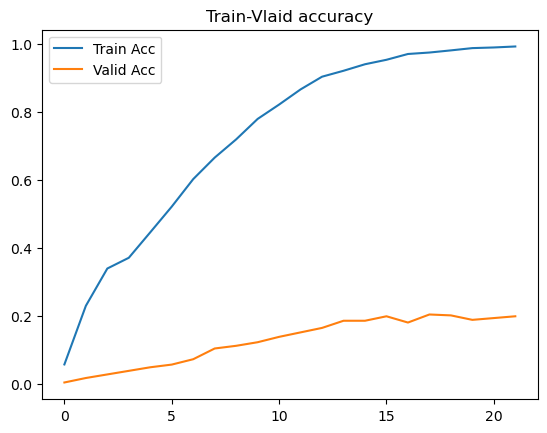

epoch 22 loss: 0.1235:   1%|▌                                        | 1/80 [00:04<05:37,  4.27s/it]

111
222
111
222


epoch 22 loss: 0.1231:   4%|█▌                                       | 3/80 [00:04<01:25,  1.10s/it]

111
222
111
222


epoch 22 loss: 0.1222:   6%|██▌                                      | 5/80 [00:05<00:40,  1.83it/s]

111
222
111
222


epoch 22 loss: 0.1220:   9%|███▌                                     | 7/80 [00:08<01:38,  1.35s/it]

111
222
111
222


epoch 22 loss: 0.1216:  11%|████▌                                    | 9/80 [00:08<00:52,  1.36it/s]

111
222
111
222


epoch 22 loss: 0.1223:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.22it/s]

111
222
111
222


epoch 22 loss: 0.1220:  16%|██████▌                                 | 13/80 [00:12<01:21,  1.22s/it]

111
222
111
222


epoch 22 loss: 0.1221:  19%|███████▌                                | 15/80 [00:12<00:45,  1.44it/s]

111
222
111
222


epoch 22 loss: 0.1224:  21%|████████▌                               | 17/80 [00:13<00:27,  2.28it/s]

111
222
111
222


epoch 22 loss: 0.1220:  24%|█████████▌                              | 19/80 [00:16<01:12,  1.20s/it]

111
222


epoch 22 loss: 0.1219:  25%|██████████                              | 20/80 [00:16<00:54,  1.10it/s]

111
222


epoch 22 loss: 0.1220:  26%|██████████▌                             | 21/80 [00:17<00:40,  1.44it/s]

111
222
111
222


epoch 22 loss: 0.1218:  29%|███████████▌                            | 23/80 [00:17<00:24,  2.28it/s]

111
222
111
222


epoch 22 loss: 0.1217:  31%|████████████▌                           | 25/80 [00:20<01:04,  1.18s/it]

111
222
111


epoch 22 loss: 0.1212:  32%|█████████████                           | 26/80 [00:20<00:47,  1.13it/s]

222


epoch 22 loss: 0.1213:  34%|█████████████▌                          | 27/80 [00:21<00:36,  1.47it/s]

111
222
111
222


epoch 22 loss: 0.1210:  36%|██████████████▌                         | 29/80 [00:21<00:21,  2.32it/s]

111
222
111
222


epoch 22 loss: 0.1203:  39%|███████████████▌                        | 31/80 [00:24<00:58,  1.20s/it]

111
222
111
222


epoch 22 loss: 0.1200:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.42it/s]

111
222
111
222


epoch 22 loss: 0.1200:  44%|█████████████████▌                      | 35/80 [00:25<00:20,  2.25it/s]

111
222
111
222


epoch 22 loss: 0.1196:  46%|██████████████████▌                     | 37/80 [00:29<00:55,  1.30s/it]

111
222
111
222


epoch 22 loss: 0.1189:  49%|███████████████████▌                    | 39/80 [00:29<00:30,  1.35it/s]

111
222
111
222


epoch 22 loss: 0.1184:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.17it/s]

111
222
111
222


epoch 22 loss: 0.1174:  54%|█████████████████████▌                  | 43/80 [00:33<00:44,  1.20s/it]

111
222


epoch 22 loss: 0.1170:  55%|██████████████████████                  | 44/80 [00:33<00:33,  1.07it/s]

111
222


epoch 22 loss: 0.1166:  56%|██████████████████████▌                 | 45/80 [00:34<00:25,  1.40it/s]

111
222
111
222


epoch 22 loss: 0.1173:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.23it/s]

111
222
111
222


epoch 22 loss: 0.1168:  61%|████████████████████████▌               | 49/80 [00:37<00:35,  1.16s/it]

111
222


epoch 22 loss: 0.1171:  62%|█████████████████████████               | 50/80 [00:37<00:27,  1.10it/s]

111
222


epoch 22 loss: 0.1167:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.36it/s]

111
222
111
222


epoch 22 loss: 0.1167:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.17it/s]

111
222
111
222


epoch 22 loss: 0.1170:  69%|███████████████████████████▌            | 55/80 [00:41<00:27,  1.10s/it]

111
222


epoch 22 loss: 0.1165:  70%|████████████████████████████            | 56/80 [00:41<00:20,  1.14it/s]

111
222


epoch 22 loss: 0.1163:  71%|████████████████████████████▌           | 57/80 [00:42<00:17,  1.35it/s]

111
222
111
222


epoch 22 loss: 0.1159:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.17it/s]

111
222
111
222


epoch 22 loss: 0.1157:  76%|██████████████████████████████▌         | 61/80 [00:45<00:21,  1.14s/it]

111
222
111
222


epoch 22 loss: 0.1154:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.33it/s]

111
222
111
222


epoch 22 loss: 0.1151:  81%|████████████████████████████████▌       | 65/80 [00:46<00:06,  2.15it/s]

111
222
111
222


epoch 22 loss: 0.1144:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:15,  1.16s/it]

111
222
111


epoch 22 loss: 0.1142:  85%|██████████████████████████████████      | 68/80 [00:50<00:10,  1.14it/s]

222


epoch 22 loss: 0.1144:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:08,  1.34it/s]

111
222
111
222


epoch 22 loss: 0.1142:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.16it/s]

111
222
111
222


epoch 22 loss: 0.1135:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.16s/it]

111
222
111
222


epoch 22 loss: 0.1132:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.38it/s]

111
222
111
222


epoch 22 loss: 0.1122:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.26it/s]

111
222
111
222


epoch 22 loss: 0.1123:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.05s/it]

111
222
111
222


epoch 22 loss: 0.1132: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.38it/s]

333
train accuracy = 0.99609
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 22 loss: 3.9502: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.87it/s]


validation accuracy = 0.20000
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


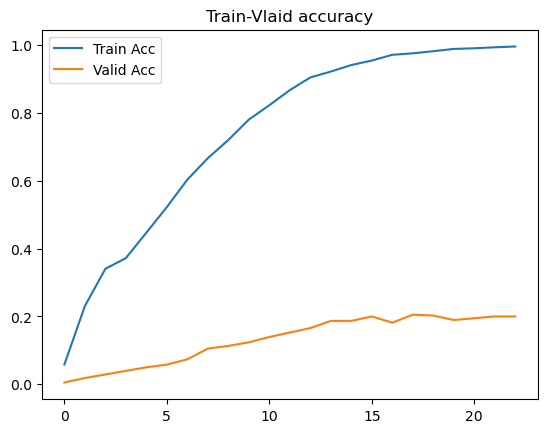

epoch 23 loss: 0.0841:   1%|▌                                        | 1/80 [00:04<05:48,  4.41s/it]

111
222
111
222


epoch 23 loss: 0.0842:   4%|█▌                                       | 3/80 [00:04<01:27,  1.14s/it]

111
222
111
222


epoch 23 loss: 0.0852:   6%|██▌                                      | 5/80 [00:05<00:41,  1.81it/s]

111
222
111
222


epoch 23 loss: 0.0852:   9%|███▌                                     | 7/80 [00:09<01:50,  1.51s/it]

111
222
111
222


epoch 23 loss: 0.0850:  11%|████▌                                    | 9/80 [00:09<00:57,  1.23it/s]

111
222
111
222


epoch 23 loss: 0.0850:  14%|█████▌                                  | 11/80 [00:09<00:33,  2.06it/s]

111
222
111
222


epoch 23 loss: 0.0854:  16%|██████▌                                 | 13/80 [00:13<01:22,  1.23s/it]

111
222
111
222


epoch 23 loss: 0.0861:  19%|███████▌                                | 15/80 [00:13<00:45,  1.43it/s]

111
222
111
222


epoch 23 loss: 0.0860:  21%|████████▌                               | 17/80 [00:13<00:27,  2.27it/s]

111
222
111
222


epoch 23 loss: 0.0862:  24%|█████████▌                              | 19/80 [00:17<01:15,  1.23s/it]

111
222
111
222


epoch 23 loss: 0.0862:  26%|██████████▌                             | 21/80 [00:17<00:41,  1.42it/s]

111
222
111
222


epoch 23 loss: 0.0861:  29%|███████████▌                            | 23/80 [00:18<00:25,  2.26it/s]

111
222
111
222


epoch 23 loss: 0.0863:  31%|████████████▌                           | 25/80 [00:21<01:05,  1.18s/it]

111
222
111
222


epoch 23 loss: 0.0862:  34%|█████████████▌                          | 27/80 [00:21<00:36,  1.47it/s]

111
222
111
222


epoch 23 loss: 0.0863:  36%|██████████████▌                         | 29/80 [00:22<00:21,  2.32it/s]

111
222
111
222


epoch 23 loss: 0.0867:  39%|███████████████▌                        | 31/80 [00:25<01:02,  1.27s/it]

111
222
111
222


epoch 23 loss: 0.0865:  41%|████████████████▌                       | 33/80 [00:26<00:33,  1.39it/s]

111
222
111
222


epoch 23 loss: 0.0864:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.22it/s]

111
222
111
222


epoch 23 loss: 0.0861:  46%|██████████████████▌                     | 37/80 [00:30<00:54,  1.26s/it]

111
222
111
222


epoch 23 loss: 0.0859:  49%|███████████████████▌                    | 39/80 [00:30<00:29,  1.40it/s]

111
222
111
222


epoch 23 loss: 0.0857:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.24it/s]

111
222
111
222


epoch 23 loss: 0.0864:  54%|█████████████████████▌                  | 43/80 [00:34<00:48,  1.31s/it]

111
222
111
222


epoch 23 loss: 0.0866:  56%|██████████████████████▌                 | 45/80 [00:34<00:25,  1.35it/s]

111
222
111
222


epoch 23 loss: 0.0870:  59%|███████████████████████▌                | 47/80 [00:35<00:15,  2.16it/s]

111
222
111
222


epoch 23 loss: 0.0868:  61%|████████████████████████▌               | 49/80 [00:38<00:37,  1.19s/it]

111
222
111
222


epoch 23 loss: 0.0870:  64%|█████████████████████████▌              | 51/80 [00:38<00:19,  1.46it/s]

111
222
111
222


epoch 23 loss: 0.0868:  66%|██████████████████████████▌             | 53/80 [00:39<00:11,  2.29it/s]

111
222
111
222


epoch 23 loss: 0.0870:  69%|███████████████████████████▌            | 55/80 [00:42<00:30,  1.21s/it]

111
222
111
222


epoch 23 loss: 0.0868:  71%|████████████████████████████▌           | 57/80 [00:43<00:15,  1.45it/s]

111
222
111
222


epoch 23 loss: 0.0870:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.23it/s]

111
222
111
222


epoch 23 loss: 0.0868:  76%|██████████████████████████████▌         | 61/80 [00:47<00:23,  1.26s/it]

111
222
111
222


epoch 23 loss: 0.0867:  79%|███████████████████████████████▌        | 63/80 [00:47<00:12,  1.40it/s]

111
222
111
222


epoch 23 loss: 0.0864:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.22it/s]

111
222
111
222


epoch 23 loss: 0.0865:  84%|█████████████████████████████████▌      | 67/80 [00:51<00:15,  1.22s/it]

111
222
111
222


epoch 23 loss: 0.0869:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.44it/s]

111
222
111
222


epoch 23 loss: 0.0870:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:03,  2.29it/s]

111
222
111
222


epoch 23 loss: 0.0870:  91%|████████████████████████████████████▌   | 73/80 [00:55<00:08,  1.24s/it]

111
222
111
222


epoch 23 loss: 0.0867:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.44it/s]

111
222
111
222


epoch 23 loss: 0.0869:  96%|██████████████████████████████████████▌ | 77/80 [00:56<00:01,  2.32it/s]

111
222
111
222


epoch 23 loss: 0.0866:  99%|███████████████████████████████████████▌| 79/80 [00:59<00:01,  1.06s/it]

111
222
111
222


epoch 23 loss: 0.0878: 100%|████████████████████████████████████████| 80/80 [00:59<00:00,  1.35it/s]

333
train accuracy = 0.99684
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 54  1]
 [ 0  0  0 ...  0  0 55]]



epoch 23 loss: 3.9587: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.84it/s]


validation accuracy = 0.22368
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


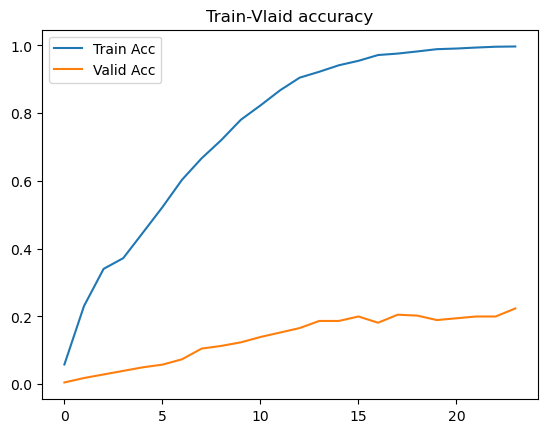

epoch 24 loss: 0.0996:   1%|▌                                        | 1/80 [00:04<05:42,  4.34s/it]

111
222
111
222


epoch 24 loss: 0.0989:   4%|█▌                                       | 3/80 [00:04<01:26,  1.12s/it]

111
222
111
222


epoch 24 loss: 0.0985:   6%|██▌                                      | 5/80 [00:05<00:41,  1.82it/s]

111
222
111
222


epoch 24 loss: 0.0984:   9%|███▌                                     | 7/80 [00:08<01:37,  1.34s/it]

111
222
111
222


epoch 24 loss: 0.0985:  11%|████▌                                    | 9/80 [00:08<00:51,  1.37it/s]

111
222
111
222


epoch 24 loss: 0.0979:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.22it/s]

111
222
111
222


epoch 24 loss: 0.0978:  16%|██████▌                                 | 13/80 [00:12<01:22,  1.24s/it]

111
222
111
222


epoch 24 loss: 0.0975:  19%|███████▌                                | 15/80 [00:13<00:45,  1.43it/s]

111
222
111
222


epoch 24 loss: 0.0972:  21%|████████▌                               | 17/80 [00:13<00:27,  2.28it/s]

111
222
111
222


epoch 24 loss: 0.0967:  24%|█████████▌                              | 19/80 [00:17<01:23,  1.37s/it]

111
222
111
222


epoch 24 loss: 0.0962:  26%|██████████▌                             | 21/80 [00:17<00:45,  1.30it/s]

111
222
111
222


epoch 24 loss: 0.0959:  29%|███████████▌                            | 23/80 [00:18<00:27,  2.11it/s]

111
222
111
222


epoch 24 loss: 0.0954:  31%|████████████▌                           | 25/80 [00:21<01:07,  1.23s/it]

111
222
111
222


epoch 24 loss: 0.0956:  34%|█████████████▌                          | 27/80 [00:21<00:37,  1.42it/s]

111
222
111
222


epoch 24 loss: 0.0952:  36%|██████████████▌                         | 29/80 [00:22<00:22,  2.27it/s]

111
222
111
222


epoch 24 loss: 0.0946:  39%|███████████████▌                        | 31/80 [00:25<01:02,  1.27s/it]

111
222
111
222


epoch 24 loss: 0.0940:  41%|████████████████▌                       | 33/80 [00:26<00:33,  1.40it/s]

111
222
111
222


epoch 24 loss: 0.0939:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.24it/s]

111
222
111
222


epoch 24 loss: 0.0938:  46%|██████████████████▌                     | 37/80 [00:29<00:50,  1.18s/it]

111
222
111
222


epoch 24 loss: 0.0932:  49%|███████████████████▌                    | 39/80 [00:30<00:27,  1.48it/s]

111
222
111
222


epoch 24 loss: 0.0926:  51%|████████████████████▌                   | 41/80 [00:30<00:16,  2.33it/s]

111
222
111
222


epoch 24 loss: 0.0925:  54%|█████████████████████▌                  | 43/80 [00:33<00:43,  1.17s/it]

111
222
111
222


epoch 24 loss: 0.0918:  56%|██████████████████████▌                 | 45/80 [00:34<00:23,  1.49it/s]

111
222
111
222


epoch 24 loss: 0.0916:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.35it/s]

111
222
111
222


epoch 24 loss: 0.0911:  61%|████████████████████████▌               | 49/80 [00:38<00:37,  1.22s/it]

111
222
111
222


epoch 24 loss: 0.0905:  64%|█████████████████████████▌              | 51/80 [00:38<00:20,  1.43it/s]

111
222
111
222


epoch 24 loss: 0.0899:  66%|██████████████████████████▌             | 53/80 [00:38<00:11,  2.27it/s]

111
222
111
222


epoch 24 loss: 0.0898:  69%|███████████████████████████▌            | 55/80 [00:42<00:30,  1.21s/it]

111
222
111
222


epoch 24 loss: 0.0895:  71%|████████████████████████████▌           | 57/80 [00:42<00:15,  1.45it/s]

111
222
111
222


epoch 24 loss: 0.0894:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.30it/s]

111
222
111
222


epoch 24 loss: 0.0893:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.19s/it]

111
222
111
222


epoch 24 loss: 0.0890:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.47it/s]

111
222
111
222


epoch 24 loss: 0.0888:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.31it/s]

111
222
111
222


epoch 24 loss: 0.0885:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:15,  1.18s/it]

111
222
111
222


epoch 24 loss: 0.0881:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.48it/s]

111
222
111
222


epoch 24 loss: 0.0878:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.11it/s]

111
222
111
222


epoch 24 loss: 0.0877:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.24s/it]

111
222
111
222


epoch 24 loss: 0.0870:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.42it/s]

111
222
111
222


epoch 24 loss: 0.0867:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.31it/s]

111
222
111
222


epoch 24 loss: 0.0859:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.04s/it]

111
222
111
222


epoch 24 loss: 0.0890: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.99773
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 24 loss: 3.9834: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.94it/s]


validation accuracy = 0.22105
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


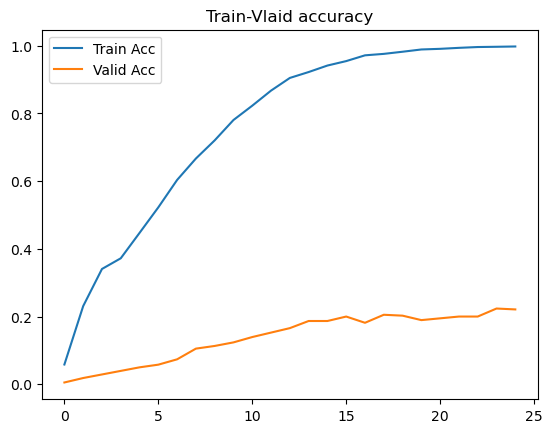

epoch 25 loss: 0.0787:   1%|▌                                        | 1/80 [00:04<05:31,  4.20s/it]

111
222
111


epoch 25 loss: 0.0786:   2%|█                                        | 2/80 [00:04<02:23,  1.84s/it]

222


epoch 25 loss: 0.0784:   4%|█▌                                       | 3/80 [00:04<01:24,  1.10s/it]

111
222
111
222


epoch 25 loss: 0.0779:   6%|██▌                                      | 5/80 [00:04<00:40,  1.84it/s]

111
222
111
222


epoch 25 loss: 0.0775:   9%|███▌                                     | 7/80 [00:08<01:37,  1.33s/it]

111
222
111
222


epoch 25 loss: 0.0770:  11%|████▌                                    | 9/80 [00:08<00:51,  1.38it/s]

111
222
111
222


epoch 25 loss: 0.0768:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.23it/s]

111
222
111
222


epoch 25 loss: 0.0765:  16%|██████▌                                 | 13/80 [00:12<01:23,  1.24s/it]

111
222
111
222


epoch 25 loss: 0.0767:  19%|███████▌                                | 15/80 [00:12<00:45,  1.41it/s]

111
222
111
222


epoch 25 loss: 0.0769:  21%|████████▌                               | 17/80 [00:13<00:28,  2.25it/s]

111
222
111
222


epoch 25 loss: 0.0770:  24%|█████████▌                              | 19/80 [00:16<01:13,  1.21s/it]

111
222
111
222


epoch 25 loss: 0.0767:  26%|██████████▌                             | 21/80 [00:17<00:40,  1.45it/s]

111
222
111
222


epoch 25 loss: 0.0763:  29%|███████████▌                            | 23/80 [00:17<00:24,  2.28it/s]

111
222
111
222


epoch 25 loss: 0.0760:  31%|████████████▌                           | 25/80 [00:21<01:08,  1.25s/it]

111
222
111
222


epoch 25 loss: 0.0757:  34%|█████████████▌                          | 27/80 [00:21<00:37,  1.41it/s]

111
222
111
222


epoch 25 loss: 0.0756:  36%|██████████████▌                         | 29/80 [00:21<00:22,  2.23it/s]

111
222
111
222


epoch 25 loss: 0.0752:  39%|███████████████▌                        | 31/80 [00:25<00:58,  1.18s/it]

111
222
111
222


epoch 25 loss: 0.0753:  41%|████████████████▌                       | 33/80 [00:25<00:31,  1.47it/s]

111
222
111
222


epoch 25 loss: 0.0749:  44%|█████████████████▌                      | 35/80 [00:25<00:19,  2.32it/s]

111
222
111
222


epoch 25 loss: 0.0750:  46%|██████████████████▌                     | 37/80 [00:29<00:51,  1.20s/it]

111
222
111
222


epoch 25 loss: 0.0752:  49%|███████████████████▌                    | 39/80 [00:29<00:28,  1.46it/s]

111
222
111
222


epoch 25 loss: 0.0750:  51%|████████████████████▌                   | 41/80 [00:29<00:16,  2.31it/s]

111
222
111
222


epoch 25 loss: 0.0747:  54%|█████████████████████▌                  | 43/80 [00:33<00:44,  1.19s/it]

111
222


epoch 25 loss: 0.0744:  55%|██████████████████████                  | 44/80 [00:33<00:34,  1.05it/s]

111
222


epoch 25 loss: 0.0744:  56%|██████████████████████▌                 | 45/80 [00:33<00:25,  1.38it/s]

111
222
111
222


epoch 25 loss: 0.0740:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.21it/s]

111
222
111
222


epoch 25 loss: 0.0739:  61%|████████████████████████▌               | 49/80 [00:37<00:35,  1.15s/it]

111
222
111


epoch 25 loss: 0.0737:  62%|█████████████████████████               | 50/80 [00:38<00:34,  1.16s/it]

222
111
222


epoch 25 loss: 0.0735:  65%|██████████████████████████              | 52/80 [00:38<00:18,  1.51it/s]

111
222


epoch 25 loss: 0.0737:  66%|██████████████████████████▌             | 53/80 [00:39<00:14,  1.91it/s]

111
222
111
222


epoch 25 loss: 0.0734:  69%|███████████████████████████▌            | 55/80 [00:41<00:25,  1.03s/it]

111
222


epoch 25 loss: 0.0736:  70%|████████████████████████████            | 56/80 [00:42<00:22,  1.05it/s]

111
222


epoch 25 loss: 0.0734:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.38it/s]

111
222
111
222


epoch 25 loss: 0.0730:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.22it/s]

111
222
111
222


epoch 25 loss: 0.0729:  76%|██████████████████████████████▌         | 61/80 [00:45<00:19,  1.04s/it]

111
222


epoch 25 loss: 0.0728:  78%|███████████████████████████████         | 62/80 [00:46<00:16,  1.08it/s]

111
222


epoch 25 loss: 0.0727:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.41it/s]

111
222
111
222


epoch 25 loss: 0.0731:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.24it/s]

111
222
111
222


epoch 25 loss: 0.0727:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:13,  1.07s/it]

111
222


epoch 25 loss: 0.0728:  85%|██████████████████████████████████      | 68/80 [00:50<00:11,  1.03it/s]

111
222


epoch 25 loss: 0.0727:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:08,  1.35it/s]

111
222
111
222


epoch 25 loss: 0.0724:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.17it/s]

111
222
111
222


epoch 25 loss: 0.0722:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:07,  1.08s/it]

111
222


epoch 25 loss: 0.0722:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.09it/s]

111
222
111


epoch 25 loss: 0.0726:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.44it/s]

222
111
222


epoch 25 loss: 0.0722:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.32it/s]

111
222
111
222


epoch 25 loss: 0.0719:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.02it/s]

111
222
111
222


epoch 25 loss: 0.0725: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.38it/s]

333
train accuracy = 0.99798
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 25 loss: 3.9628: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.33it/s]


validation accuracy = 0.19211
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]


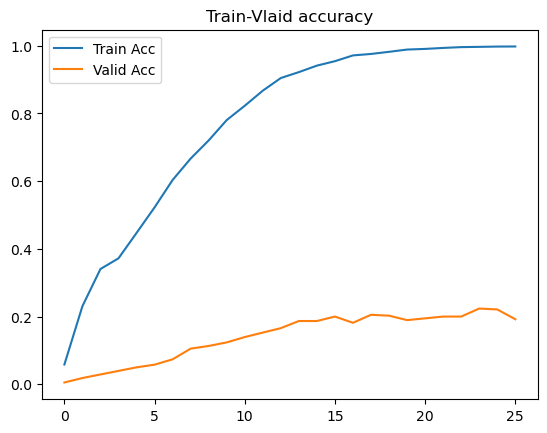

epoch 26 loss: 0.0554:   1%|▌                                        | 1/80 [00:04<05:28,  4.16s/it]

111
222
111


epoch 26 loss: 0.0554:   2%|█                                        | 2/80 [00:04<02:22,  1.83s/it]

222
111


epoch 26 loss: 0.0555:   4%|█▌                                       | 3/80 [00:04<01:23,  1.08s/it]

222
111
222


epoch 26 loss: 0.0556:   6%|██▌                                      | 5/80 [00:04<00:40,  1.87it/s]

111
222
111
222


epoch 26 loss: 0.0559:   9%|███▌                                     | 7/80 [00:08<01:36,  1.33s/it]

111
222
111
222


epoch 26 loss: 0.0560:  11%|████▌                                    | 9/80 [00:08<00:55,  1.28it/s]

111
222
111
222


epoch 26 loss: 0.0560:  14%|█████▌                                  | 11/80 [00:09<00:32,  2.09it/s]

111
222
111
222


epoch 26 loss: 0.0563:  16%|██████▌                                 | 13/80 [00:12<01:17,  1.16s/it]

111
222


epoch 26 loss: 0.0565:  18%|███████                                 | 14/80 [00:12<00:57,  1.14it/s]

111
222


epoch 26 loss: 0.0565:  19%|███████▌                                | 15/80 [00:13<00:50,  1.29it/s]

111
222
111
222


epoch 26 loss: 0.0565:  21%|████████▌                               | 17/80 [00:13<00:29,  2.10it/s]

111
222
111
222


epoch 26 loss: 0.0566:  24%|█████████▌                              | 19/80 [00:16<01:10,  1.15s/it]

111
222


epoch 26 loss: 0.0568:  25%|██████████                              | 20/80 [00:17<00:56,  1.06it/s]

111
222


epoch 26 loss: 0.0569:  26%|██████████▌                             | 21/80 [00:17<00:43,  1.37it/s]

111
222
111
222


epoch 26 loss: 0.0571:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.21it/s]

111
222
111
222


epoch 26 loss: 0.0572:  31%|████████████▌                           | 25/80 [00:21<01:12,  1.31s/it]

111
222
111
222


epoch 26 loss: 0.0573:  34%|█████████████▌                          | 27/80 [00:21<00:39,  1.34it/s]

111
222
111
222


epoch 26 loss: 0.0575:  36%|██████████████▌                         | 29/80 [00:22<00:23,  2.15it/s]

111
222
111
222


epoch 26 loss: 0.0575:  39%|███████████████▌                        | 31/80 [00:25<00:58,  1.19s/it]

111
222
111
222


epoch 26 loss: 0.0575:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.47it/s]

111
222
111
222


epoch 26 loss: 0.0575:  44%|█████████████████▌                      | 35/80 [00:26<00:19,  2.31it/s]

111
222
111
222


epoch 26 loss: 0.0574:  46%|██████████████████▌                     | 37/80 [00:29<00:51,  1.19s/it]

111
222
111
222


epoch 26 loss: 0.0573:  49%|███████████████████▌                    | 39/80 [00:29<00:28,  1.45it/s]

111
222


epoch 26 loss: 0.0572:  50%|████████████████████                    | 40/80 [00:30<00:22,  1.76it/s]

111
222


epoch 26 loss: 0.0573:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.20it/s]

111
222
111
222


epoch 26 loss: 0.0574:  54%|█████████████████████▌                  | 43/80 [00:33<00:43,  1.18s/it]

111
222
111
222


epoch 26 loss: 0.0579:  56%|██████████████████████▌                 | 45/80 [00:34<00:23,  1.47it/s]

111
222


epoch 26 loss: 0.0579:  57%|███████████████████████                 | 46/80 [00:34<00:22,  1.50it/s]

111
222


epoch 26 loss: 0.0580:  59%|███████████████████████▌                | 47/80 [00:34<00:17,  1.90it/s]

111
222
111
222


epoch 26 loss: 0.0581:  61%|████████████████████████▌               | 49/80 [00:37<00:35,  1.14s/it]

111
222
111
222


epoch 26 loss: 0.0581:  64%|█████████████████████████▌              | 51/80 [00:38<00:19,  1.53it/s]

111
222


epoch 26 loss: 0.0582:  65%|██████████████████████████              | 52/80 [00:38<00:16,  1.68it/s]

111
222


epoch 26 loss: 0.0583:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.10it/s]

111
222
111
222


epoch 26 loss: 0.0585:  69%|███████████████████████████▌            | 55/80 [00:42<00:29,  1.16s/it]

111
222
111
222


epoch 26 loss: 0.0584:  71%|████████████████████████████▌           | 57/80 [00:42<00:15,  1.49it/s]

111
222


epoch 26 loss: 0.0583:  72%|█████████████████████████████           | 58/80 [00:43<00:14,  1.55it/s]

111
222


epoch 26 loss: 0.0581:  74%|█████████████████████████████▌          | 59/80 [00:43<00:10,  1.95it/s]

111
222
111
222


epoch 26 loss: 0.0581:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.17s/it]

111
222
111
222


epoch 26 loss: 0.0578:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.49it/s]

111
222


epoch 26 loss: 0.0577:  80%|████████████████████████████████        | 64/80 [00:47<00:09,  1.65it/s]

111
222


epoch 26 loss: 0.0576:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  2.07it/s]

111
222
111
222


epoch 26 loss: 0.0578:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:14,  1.12s/it]

111
222


epoch 26 loss: 0.0578:  85%|██████████████████████████████████      | 68/80 [00:50<00:10,  1.11it/s]

111
222


epoch 26 loss: 0.0577:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.44it/s]

111
222


epoch 26 loss: 0.0578:  88%|███████████████████████████████████     | 70/80 [00:51<00:06,  1.63it/s]

111
222


epoch 26 loss: 0.0576:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.06it/s]

111
222
111
222


epoch 26 loss: 0.0576:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:07,  1.06s/it]

111
222


epoch 26 loss: 0.0578:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.11it/s]

111
222


epoch 26 loss: 0.0578:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.45it/s]

111
222


epoch 26 loss: 0.0577:  95%|██████████████████████████████████████  | 76/80 [00:55<00:02,  1.65it/s]

111
222
111


epoch 26 loss: 0.0576:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.10it/s]

222
111
222


epoch 26 loss: 0.0600:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:00,  1.10it/s]

111
222
111
222


epoch 26 loss: 0.0600: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.38it/s]

333
train accuracy = 0.99886
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 26 loss: 3.9877: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.83it/s]


validation accuracy = 0.21053
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


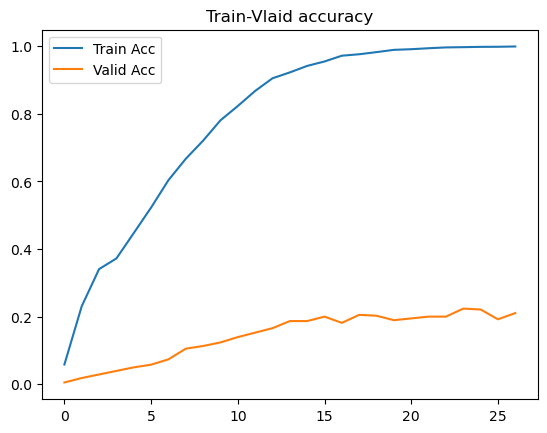

epoch 27 loss: 0.0468:   1%|▌                                        | 1/80 [00:04<05:35,  4.24s/it]

111
222
111


epoch 27 loss: 0.0469:   2%|█                                        | 2/80 [00:04<02:25,  1.86s/it]

222
111


epoch 27 loss: 0.0471:   4%|█▌                                       | 3/80 [00:04<01:24,  1.10s/it]

222
111
222


epoch 27 loss: 0.0474:   6%|██▌                                      | 5/80 [00:05<00:40,  1.84it/s]

111
222
111
222


epoch 27 loss: 0.0480:   9%|███▌                                     | 7/80 [00:08<01:42,  1.40s/it]

111
222
111
222


epoch 27 loss: 0.0479:  11%|████▌                                    | 9/80 [00:09<00:53,  1.32it/s]

111
222
111
222


epoch 27 loss: 0.0481:  14%|█████▌                                  | 11/80 [00:09<00:32,  2.15it/s]

111
222
111
222


epoch 27 loss: 0.0483:  16%|██████▌                                 | 13/80 [00:12<01:23,  1.25s/it]

111
222
111
222


epoch 27 loss: 0.0486:  19%|███████▌                                | 15/80 [00:13<00:45,  1.42it/s]

111
222
111
222


epoch 27 loss: 0.0487:  21%|████████▌                               | 17/80 [00:13<00:27,  2.25it/s]

111
222
111
222


epoch 27 loss: 0.0493:  24%|█████████▌                              | 19/80 [00:17<01:15,  1.23s/it]

111
222
111
222


epoch 27 loss: 0.0495:  26%|██████████▌                             | 21/80 [00:17<00:41,  1.43it/s]

111
222
111
222


epoch 27 loss: 0.0497:  29%|███████████▌                            | 23/80 [00:17<00:24,  2.29it/s]

111
222
111
222


epoch 27 loss: 0.0502:  31%|████████████▌                           | 25/80 [00:21<01:12,  1.32s/it]

111
222
111
222


epoch 27 loss: 0.0505:  34%|█████████████▌                          | 27/80 [00:21<00:39,  1.34it/s]

111
222
111
222


epoch 27 loss: 0.0509:  36%|██████████████▌                         | 29/80 [00:22<00:23,  2.16it/s]

111
222
111
222


epoch 27 loss: 0.0510:  39%|███████████████▌                        | 31/80 [00:25<00:59,  1.20s/it]

111
222
111
222


epoch 27 loss: 0.0513:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.45it/s]

111
222
111
222


epoch 27 loss: 0.0513:  44%|█████████████████▌                      | 35/80 [00:26<00:19,  2.29it/s]

111
222
111
222


epoch 27 loss: 0.0513:  46%|██████████████████▌                     | 37/80 [00:29<00:51,  1.20s/it]

111
222
111
222


epoch 27 loss: 0.0514:  49%|███████████████████▌                    | 39/80 [00:30<00:28,  1.46it/s]

111
222
111
222


epoch 27 loss: 0.0514:  51%|████████████████████▌                   | 41/80 [00:30<00:16,  2.32it/s]

111
222
111
222


epoch 27 loss: 0.0514:  54%|█████████████████████▌                  | 43/80 [00:33<00:45,  1.23s/it]

111
222
111
222


epoch 27 loss: 0.0515:  56%|██████████████████████▌                 | 45/80 [00:34<00:24,  1.43it/s]

111
222
111
222


epoch 27 loss: 0.0516:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.25it/s]

111
222
111
222


epoch 27 loss: 0.0517:  61%|████████████████████████▌               | 49/80 [00:38<00:39,  1.29s/it]

111
222
111
222


epoch 27 loss: 0.0518:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.37it/s]

111
222
111
222


epoch 27 loss: 0.0518:  66%|██████████████████████████▌             | 53/80 [00:39<00:12,  2.18it/s]

111
222
111
222


epoch 27 loss: 0.0519:  69%|███████████████████████████▌            | 55/80 [00:42<00:29,  1.17s/it]

111
222
111
222


epoch 27 loss: 0.0519:  71%|████████████████████████████▌           | 57/80 [00:42<00:15,  1.49it/s]

111
222


epoch 27 loss: 0.0521:  72%|█████████████████████████████           | 58/80 [00:43<00:12,  1.72it/s]

111
222


epoch 27 loss: 0.0523:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.13it/s]

111
222
111
222


epoch 27 loss: 0.0525:  76%|██████████████████████████████▌         | 61/80 [00:46<00:21,  1.15s/it]

111
222
111
222


epoch 27 loss: 0.0525:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.51it/s]

111
222


epoch 27 loss: 0.0526:  80%|████████████████████████████████        | 64/80 [00:47<00:09,  1.68it/s]

111
222


epoch 27 loss: 0.0525:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  2.10it/s]

111
222
111
222


epoch 27 loss: 0.0525:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:15,  1.19s/it]

111
222
111
222


epoch 27 loss: 0.0523:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.47it/s]

111
222


epoch 27 loss: 0.0523:  88%|███████████████████████████████████     | 70/80 [00:51<00:06,  1.63it/s]

111
222


epoch 27 loss: 0.0522:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.05it/s]

111
222
111
222


epoch 27 loss: 0.0525:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.16s/it]

111
222
111
222


epoch 27 loss: 0.0524:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.51it/s]

111
222


epoch 27 loss: 0.0524:  95%|██████████████████████████████████████  | 76/80 [00:55<00:02,  1.78it/s]

111
222
111
222


epoch 27 loss: 0.0524:  98%|███████████████████████████████████████ | 78/80 [00:55<00:00,  2.76it/s]

111
222


epoch 27 loss: 0.0525:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.03s/it]

111
222
111
222


epoch 27 loss: 0.0532: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.99861
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 27 loss: 3.9960: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.39it/s]


validation accuracy = 0.21316
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


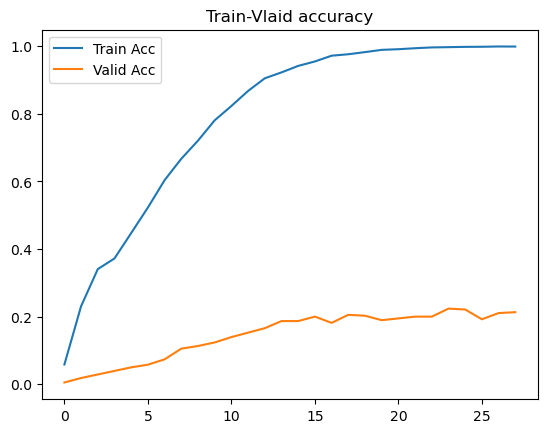

epoch 28 loss: 0.1071:   1%|▌                                        | 1/80 [00:04<05:49,  4.42s/it]

111
222
111
222


epoch 28 loss: 0.1061:   4%|█▌                                       | 3/80 [00:04<01:27,  1.14s/it]

111
222
111
222


epoch 28 loss: 0.1052:   6%|██▌                                      | 5/80 [00:05<00:42,  1.78it/s]

111
222
111
222


epoch 28 loss: 0.1039:   9%|███▌                                     | 7/80 [00:08<01:36,  1.32s/it]

111
222
111
222


epoch 28 loss: 0.1029:  11%|████▌                                    | 9/80 [00:09<00:55,  1.27it/s]

111
222
111
222


epoch 28 loss: 0.1020:  14%|█████▌                                  | 11/80 [00:09<00:32,  2.11it/s]

111
222
111
222


epoch 28 loss: 0.1010:  16%|██████▌                                 | 13/80 [00:12<01:20,  1.19s/it]

111
222
111
222


epoch 28 loss: 0.1002:  19%|███████▌                                | 15/80 [00:13<00:54,  1.18it/s]

111
222
111
222


epoch 28 loss: 0.0995:  21%|████████▌                               | 17/80 [00:14<00:32,  1.96it/s]

111
222
111
222


epoch 28 loss: 0.0986:  24%|█████████▌                              | 19/80 [00:16<01:07,  1.10s/it]

111
222
111
222


epoch 28 loss: 0.0976:  26%|██████████▌                             | 21/80 [00:17<00:46,  1.26it/s]

111
222
111
222


epoch 28 loss: 0.0968:  29%|███████████▌                            | 23/80 [00:18<00:27,  2.06it/s]

111
222
111
222


epoch 28 loss: 0.0958:  31%|████████████▌                           | 25/80 [00:20<00:58,  1.06s/it]

111
222
111
222


epoch 28 loss: 0.0947:  34%|█████████████▌                          | 27/80 [00:22<00:43,  1.22it/s]

111
222
111
222


epoch 28 loss: 0.0939:  36%|██████████████▌                         | 29/80 [00:22<00:25,  2.00it/s]

111
222
111
222


epoch 28 loss: 0.0928:  39%|███████████████▌                        | 31/80 [00:25<00:49,  1.00s/it]

111
222


epoch 28 loss: 0.0923:  40%|████████████████                        | 32/80 [00:25<00:41,  1.15it/s]

111
222


epoch 28 loss: 0.0919:  41%|████████████████▌                       | 33/80 [00:26<00:38,  1.23it/s]

111
222
111
222


epoch 28 loss: 0.0910:  44%|█████████████████▌                      | 35/80 [00:26<00:22,  2.02it/s]

111
222
111
222


epoch 28 loss: 0.0901:  46%|██████████████████▌                     | 37/80 [00:29<00:42,  1.01it/s]

111
222


epoch 28 loss: 0.0896:  48%|███████████████████                     | 38/80 [00:29<00:37,  1.11it/s]

111
222


epoch 28 loss: 0.0893:  49%|███████████████████▌                    | 39/80 [00:30<00:34,  1.18it/s]

111
222
111
222


epoch 28 loss: 0.0887:  51%|████████████████████▌                   | 41/80 [00:30<00:20,  1.94it/s]

111
222
111
222


epoch 28 loss: 0.0880:  54%|█████████████████████▌                  | 43/80 [00:33<00:37,  1.02s/it]

111
222


epoch 28 loss: 0.0877:  55%|██████████████████████                  | 44/80 [00:33<00:29,  1.22it/s]

111
222


epoch 28 loss: 0.0874:  56%|██████████████████████▌                 | 45/80 [00:34<00:28,  1.23it/s]

111
222
111
222


epoch 28 loss: 0.0867:  59%|███████████████████████▌                | 47/80 [00:35<00:16,  2.02it/s]

111
222
111
222


epoch 28 loss: 0.0860:  61%|████████████████████████▌               | 49/80 [00:37<00:31,  1.02s/it]

111
222


epoch 28 loss: 0.0856:  62%|█████████████████████████               | 50/80 [00:38<00:23,  1.27it/s]

111
222


epoch 28 loss: 0.0852:  64%|█████████████████████████▌              | 51/80 [00:39<00:24,  1.18it/s]

111
222
111
222


epoch 28 loss: 0.0851:  66%|██████████████████████████▌             | 53/80 [00:39<00:13,  1.96it/s]

111
222
111
222


epoch 28 loss: 0.0842:  69%|███████████████████████████▌            | 55/80 [00:42<00:28,  1.15s/it]

111
222
111


epoch 28 loss: 0.0841:  70%|████████████████████████████            | 56/80 [00:42<00:20,  1.15it/s]

222


epoch 28 loss: 0.0838:  71%|████████████████████████████▌           | 57/80 [00:43<00:17,  1.34it/s]

111
222
111
222


epoch 28 loss: 0.0828:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.17it/s]

111
222
111
222


epoch 28 loss: 0.0823:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.18s/it]

111
222
111
222


epoch 28 loss: 0.0816:  79%|███████████████████████████████▌        | 63/80 [00:47<00:12,  1.38it/s]

111
222
111
222


epoch 28 loss: 0.0810:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.21it/s]

111
222
111
222


epoch 28 loss: 0.0802:  84%|█████████████████████████████████▌      | 67/80 [00:51<00:15,  1.21s/it]

111
222
111
222


epoch 28 loss: 0.0797:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.45it/s]

111
222
111
222


epoch 28 loss: 0.0790:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:03,  2.28it/s]

111
222
111
222


epoch 28 loss: 0.0785:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.16s/it]

111
222
111
222


epoch 28 loss: 0.0780:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.44it/s]

111
222
111
222


epoch 28 loss: 0.0779:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.33it/s]

111
222
111
222


epoch 28 loss: 0.0774:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.05s/it]

111
222
111
222


epoch 28 loss: 0.0789: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.36it/s]

333
train accuracy = 0.99899
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 28 loss: 4.0027: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.23it/s]


validation accuracy = 0.21053
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


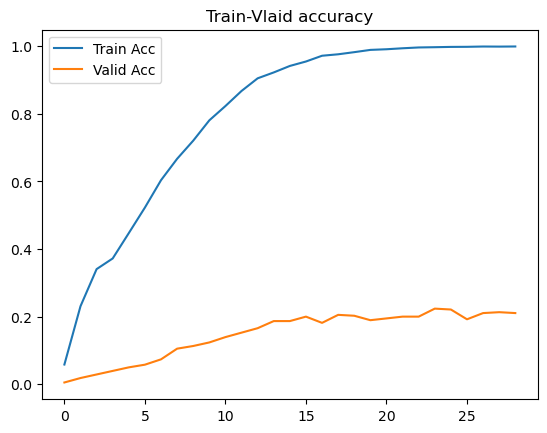

epoch 29 loss: 0.0678:   1%|▌                                        | 1/80 [00:04<05:36,  4.26s/it]

111
222
111
222


epoch 29 loss: 0.0674:   4%|█▌                                       | 3/80 [00:04<01:24,  1.10s/it]

111
222
111
222


epoch 29 loss: 0.0673:   6%|██▌                                      | 5/80 [00:05<00:40,  1.84it/s]

111
222
111
222


epoch 29 loss: 0.0669:   9%|███▌                                     | 7/80 [00:08<01:34,  1.29s/it]

111
222


epoch 29 loss: 0.0668:  10%|████                                     | 8/80 [00:08<01:11,  1.00it/s]

111
222


epoch 29 loss: 0.0666:  11%|████▌                                    | 9/80 [00:08<00:53,  1.33it/s]

111
222
111
222


epoch 29 loss: 0.0661:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.17it/s]

111
222
111
222


epoch 29 loss: 0.0660:  16%|██████▌                                 | 13/80 [00:12<01:16,  1.15s/it]

111
222


epoch 29 loss: 0.0660:  18%|███████                                 | 14/80 [00:12<01:02,  1.05it/s]

111
222


epoch 29 loss: 0.0659:  19%|███████▌                                | 15/80 [00:13<00:46,  1.39it/s]

111
222
111
222


epoch 29 loss: 0.0655:  21%|████████▌                               | 17/80 [00:13<00:28,  2.21it/s]

111
222
111
222


epoch 29 loss: 0.0651:  24%|█████████▌                              | 19/80 [00:16<01:07,  1.11s/it]

111
222


epoch 29 loss: 0.0649:  25%|██████████                              | 20/80 [00:17<00:58,  1.02it/s]

111
222


epoch 29 loss: 0.0649:  26%|██████████▌                             | 21/80 [00:17<00:43,  1.34it/s]

111
222
111
222


epoch 29 loss: 0.0648:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.16it/s]

111
222
111
222


epoch 29 loss: 0.0644:  31%|████████████▌                           | 25/80 [00:20<01:02,  1.14s/it]

111
222


epoch 29 loss: 0.0642:  32%|█████████████                           | 26/80 [00:21<00:48,  1.10it/s]

111
222


epoch 29 loss: 0.0640:  34%|█████████████▌                          | 27/80 [00:21<00:36,  1.44it/s]

111
222
111
222


epoch 29 loss: 0.0636:  36%|██████████████▌                         | 29/80 [00:21<00:22,  2.29it/s]

111
222
111
222


epoch 29 loss: 0.0631:  39%|███████████████▌                        | 31/80 [00:25<01:02,  1.27s/it]

111
222
111
222


epoch 29 loss: 0.0631:  41%|████████████████▌                       | 33/80 [00:25<00:33,  1.39it/s]

111
222
111
222


epoch 29 loss: 0.0627:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.23it/s]

111
222
111
222


epoch 29 loss: 0.0623:  46%|██████████████████▌                     | 37/80 [00:29<00:52,  1.23s/it]

111
222


epoch 29 loss: 0.0624:  48%|███████████████████                     | 38/80 [00:29<00:39,  1.07it/s]

111
222


epoch 29 loss: 0.0624:  49%|███████████████████▌                    | 39/80 [00:29<00:29,  1.40it/s]

111
222
111
222


epoch 29 loss: 0.0622:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.23it/s]

111
222
111
222


epoch 29 loss: 0.0620:  54%|█████████████████████▌                  | 43/80 [00:33<00:44,  1.20s/it]

111
222
111


epoch 29 loss: 0.0619:  55%|██████████████████████                  | 44/80 [00:33<00:32,  1.11it/s]

222


epoch 29 loss: 0.0618:  56%|██████████████████████▌                 | 45/80 [00:34<00:24,  1.44it/s]

111
222
111
222


epoch 29 loss: 0.0613:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.28it/s]

111
222
111
222


epoch 29 loss: 0.0612:  61%|████████████████████████▌               | 49/80 [00:37<00:36,  1.19s/it]

111
222
111
222


epoch 29 loss: 0.0609:  64%|█████████████████████████▌              | 51/80 [00:38<00:19,  1.47it/s]

111
222


epoch 29 loss: 0.0609:  65%|██████████████████████████              | 52/80 [00:38<00:15,  1.79it/s]

111
222


epoch 29 loss: 0.0607:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.23it/s]

111
222
111
222


epoch 29 loss: 0.0606:  69%|███████████████████████████▌            | 55/80 [00:41<00:29,  1.17s/it]

111
222
111
222


epoch 29 loss: 0.0603:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.41it/s]

111
222


epoch 29 loss: 0.0602:  72%|█████████████████████████████           | 58/80 [00:42<00:13,  1.67it/s]

111
222


epoch 29 loss: 0.0601:  74%|█████████████████████████████▌          | 59/80 [00:42<00:10,  2.09it/s]

111
222
111
222


epoch 29 loss: 0.0601:  76%|██████████████████████████████▌         | 61/80 [00:45<00:21,  1.15s/it]

111
222


epoch 29 loss: 0.0599:  78%|███████████████████████████████         | 62/80 [00:46<00:16,  1.07it/s]

111
222


epoch 29 loss: 0.0599:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.40it/s]

111
222


epoch 29 loss: 0.0597:  80%|████████████████████████████████        | 64/80 [00:47<00:10,  1.54it/s]

111
222


epoch 29 loss: 0.0595:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  1.95it/s]

111
222
111
222


epoch 29 loss: 0.0594:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:13,  1.03s/it]

111
222


epoch 29 loss: 0.0592:  85%|██████████████████████████████████      | 68/80 [00:50<00:11,  1.06it/s]

111
222


epoch 29 loss: 0.0592:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.39it/s]

111
222


epoch 29 loss: 0.0590:  88%|███████████████████████████████████     | 70/80 [00:51<00:06,  1.65it/s]

111
222


epoch 29 loss: 0.0588:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.07it/s]

111
222
111
222


epoch 29 loss: 0.0587:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:07,  1.04s/it]

111
222


epoch 29 loss: 0.0586:  92%|█████████████████████████████████████   | 74/80 [00:55<00:05,  1.00it/s]

111
222
111


epoch 29 loss: 0.0586:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.33it/s]

222
111
222


epoch 29 loss: 0.0586:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.18it/s]

111
222
111
222


epoch 29 loss: 0.0609:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.14it/s]

111
222
111
222


epoch 29 loss: 0.0609: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]

333
train accuracy = 0.99874
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 29 loss: 3.9803: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.56it/s]


validation accuracy = 0.21316
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


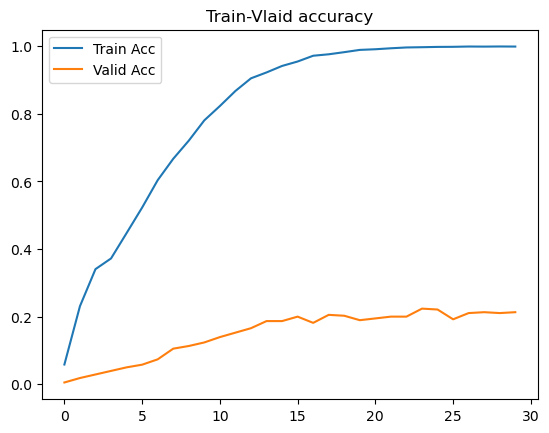

epoch 30 loss: 0.0581:   1%|▌                                        | 1/80 [00:04<05:35,  4.25s/it]

111
222
111
222


epoch 30 loss: 0.0578:   4%|█▌                                       | 3/80 [00:04<01:24,  1.10s/it]

111
222
111
222


epoch 30 loss: 0.0575:   6%|██▌                                      | 5/80 [00:05<00:40,  1.85it/s]

111
222
111
222


epoch 30 loss: 0.0574:   9%|███▌                                     | 7/80 [00:08<01:42,  1.41s/it]

111
222
111
222


epoch 30 loss: 0.0574:  11%|████▌                                    | 9/80 [00:09<00:53,  1.32it/s]

111
222
111
222


epoch 30 loss: 0.0572:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.16it/s]

111
222
111
222


epoch 30 loss: 0.0569:  16%|██████▌                                 | 13/80 [00:12<01:22,  1.23s/it]

111
222
111
222


epoch 30 loss: 0.0568:  19%|███████▌                                | 15/80 [00:13<00:45,  1.43it/s]

111
222
111
222


epoch 30 loss: 0.0564:  21%|████████▌                               | 17/80 [00:13<00:27,  2.27it/s]

111
222
111
222


epoch 30 loss: 0.0564:  24%|█████████▌                              | 19/80 [00:17<01:16,  1.25s/it]

111
222
111
222


epoch 30 loss: 0.0562:  26%|██████████▌                             | 21/80 [00:17<00:41,  1.41it/s]

111
222
111
222


epoch 30 loss: 0.0562:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.24it/s]

111
222
111
222


epoch 30 loss: 0.0560:  31%|████████████▌                           | 25/80 [00:21<01:14,  1.35s/it]

111
222
111
222


epoch 30 loss: 0.0559:  34%|█████████████▌                          | 27/80 [00:21<00:40,  1.32it/s]

111
222
111
222


epoch 30 loss: 0.0558:  36%|██████████████▌                         | 29/80 [00:22<00:23,  2.14it/s]

111
222
111
222


epoch 30 loss: 0.0558:  39%|███████████████▌                        | 31/80 [00:25<01:03,  1.30s/it]

111
222
111
222


epoch 30 loss: 0.0553:  41%|████████████████▌                       | 33/80 [00:26<00:34,  1.36it/s]

111
222
111
222


epoch 30 loss: 0.0552:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.19it/s]

111
222
111
222


epoch 30 loss: 0.0551:  46%|██████████████████▌                     | 37/80 [00:30<00:54,  1.28s/it]

111
222
111
222


epoch 30 loss: 0.0548:  49%|███████████████████▌                    | 39/80 [00:30<00:29,  1.39it/s]

111
222
111
222


epoch 30 loss: 0.0547:  51%|████████████████████▌                   | 41/80 [00:31<00:17,  2.23it/s]

111
222
111
222


epoch 30 loss: 0.0544:  54%|█████████████████████▌                  | 43/80 [00:34<00:44,  1.20s/it]

111
222
111
222


epoch 30 loss: 0.0542:  56%|██████████████████████▌                 | 45/80 [00:34<00:24,  1.46it/s]

111
222
111
222


epoch 30 loss: 0.0539:  59%|███████████████████████▌                | 47/80 [00:35<00:14,  2.31it/s]

111
222
111
222


epoch 30 loss: 0.0537:  61%|████████████████████████▌               | 49/80 [00:38<00:37,  1.21s/it]

111
222
111
222


epoch 30 loss: 0.0536:  64%|█████████████████████████▌              | 51/80 [00:38<00:20,  1.44it/s]

111
222
111
222


epoch 30 loss: 0.0535:  66%|██████████████████████████▌             | 53/80 [00:39<00:11,  2.28it/s]

111
222
111
222


epoch 30 loss: 0.0532:  69%|███████████████████████████▌            | 55/80 [00:42<00:31,  1.27s/it]

111
222
111
222


epoch 30 loss: 0.0530:  71%|████████████████████████████▌           | 57/80 [00:43<00:16,  1.39it/s]

111
222
111
222


epoch 30 loss: 0.0530:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.22it/s]

111
222
111
222


epoch 30 loss: 0.0528:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.20s/it]

111
222
111
222


epoch 30 loss: 0.0527:  79%|███████████████████████████████▌        | 63/80 [00:47<00:11,  1.46it/s]

111
222
111
222


epoch 30 loss: 0.0527:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.31it/s]

111
222
111
222


epoch 30 loss: 0.0526:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:15,  1.17s/it]

111
222


epoch 30 loss: 0.0526:  85%|██████████████████████████████████      | 68/80 [00:51<00:11,  1.08it/s]

111
222


epoch 30 loss: 0.0523:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.41it/s]

111
222
111
222


epoch 30 loss: 0.0524:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.24it/s]

111
222
111
222


epoch 30 loss: 0.0525:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:07,  1.12s/it]

111
222


epoch 30 loss: 0.0523:  92%|█████████████████████████████████████   | 74/80 [00:55<00:05,  1.07it/s]

111
222
111


epoch 30 loss: 0.0523:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.41it/s]

222
111
222


epoch 30 loss: 0.0520:  96%|██████████████████████████████████████▌ | 77/80 [00:56<00:01,  2.27it/s]

111
222
111
222


epoch 30 loss: 0.0518:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:00,  1.01it/s]

111
222
111
222


epoch 30 loss: 0.0534: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.36it/s]

333
train accuracy = 0.99924
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 30 loss: 4.0011: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.42it/s]


validation accuracy = 0.21053
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


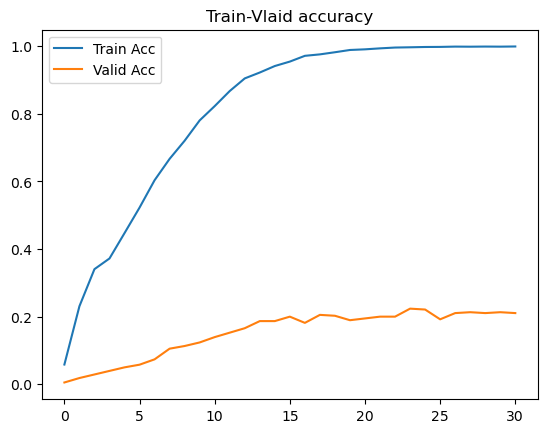

epoch 31 loss: 0.0407:   1%|▌                                        | 1/80 [00:04<05:38,  4.29s/it]

111
222
111
222


epoch 31 loss: 0.0408:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 31 loss: 0.0408:   6%|██▌                                      | 5/80 [00:05<00:40,  1.83it/s]

111
222
111
222


epoch 31 loss: 0.0409:   9%|███▌                                     | 7/80 [00:08<01:38,  1.35s/it]

111
222
111
222


epoch 31 loss: 0.0410:  11%|████▌                                    | 9/80 [00:08<00:52,  1.36it/s]

111
222
111
222


epoch 31 loss: 0.0409:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.21it/s]

111
222
111
222


epoch 31 loss: 0.0408:  16%|██████▌                                 | 13/80 [00:12<01:27,  1.31s/it]

111
222
111
222


epoch 31 loss: 0.0405:  19%|███████▌                                | 15/80 [00:13<00:47,  1.36it/s]

111
222
111
222


epoch 31 loss: 0.0404:  21%|████████▌                               | 17/80 [00:13<00:28,  2.20it/s]

111
222
111
222


epoch 31 loss: 0.0405:  24%|█████████▌                              | 19/80 [00:17<01:15,  1.24s/it]

111
222
111
222


epoch 31 loss: 0.0405:  26%|██████████▌                             | 21/80 [00:17<00:41,  1.42it/s]

111
222
111
222


epoch 31 loss: 0.0407:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.26it/s]

111
222
111
222


epoch 31 loss: 0.0409:  31%|████████████▌                           | 25/80 [00:21<01:04,  1.17s/it]

111
222
111
222


epoch 31 loss: 0.0409:  34%|█████████████▌                          | 27/80 [00:21<00:35,  1.49it/s]

111
222
111
222


epoch 31 loss: 0.0407:  36%|██████████████▌                         | 29/80 [00:21<00:21,  2.34it/s]

111
222
111
222


epoch 31 loss: 0.0407:  39%|███████████████▌                        | 31/80 [00:25<00:58,  1.19s/it]

111
222
111
222


epoch 31 loss: 0.0407:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.46it/s]

111
222
111
222


epoch 31 loss: 0.0407:  44%|█████████████████▌                      | 35/80 [00:25<00:19,  2.31it/s]

111
222
111
222


epoch 31 loss: 0.0407:  46%|██████████████████▌                     | 37/80 [00:29<00:51,  1.21s/it]

111
222
111
222


epoch 31 loss: 0.0406:  49%|███████████████████▌                    | 39/80 [00:29<00:28,  1.44it/s]

111
222
111
222


epoch 31 loss: 0.0407:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.28it/s]

111
222
111
222


epoch 31 loss: 0.0409:  54%|█████████████████████▌                  | 43/80 [00:33<00:44,  1.21s/it]

111
222
111


epoch 31 loss: 0.0410:  55%|██████████████████████                  | 44/80 [00:33<00:32,  1.10it/s]

222
111


epoch 31 loss: 0.0409:  56%|██████████████████████▌                 | 45/80 [00:33<00:24,  1.44it/s]

222
111
222


epoch 31 loss: 0.0412:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.28it/s]

111
222
111
222


epoch 31 loss: 0.0413:  61%|████████████████████████▌               | 49/80 [00:37<00:36,  1.17s/it]

111
222
111


epoch 31 loss: 0.0413:  62%|█████████████████████████               | 50/80 [00:37<00:26,  1.13it/s]

222


epoch 31 loss: 0.0412:  64%|█████████████████████████▌              | 51/80 [00:38<00:22,  1.27it/s]

111
222
111
222


epoch 31 loss: 0.0413:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.08it/s]

111
222
111
222


epoch 31 loss: 0.0414:  69%|███████████████████████████▌            | 55/80 [00:41<00:27,  1.09s/it]

111
222


epoch 31 loss: 0.0413:  70%|████████████████████████████            | 56/80 [00:41<00:19,  1.21it/s]

111
222


epoch 31 loss: 0.0413:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.38it/s]

111
222
111
222


epoch 31 loss: 0.0415:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.20it/s]

111
222
111
222


epoch 31 loss: 0.0415:  76%|██████████████████████████████▌         | 61/80 [00:45<00:21,  1.11s/it]

111
222


epoch 31 loss: 0.0415:  78%|███████████████████████████████         | 62/80 [00:45<00:15,  1.15it/s]

111
222


epoch 31 loss: 0.0418:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.33it/s]

111
222
111
222


epoch 31 loss: 0.0419:  81%|████████████████████████████████▌       | 65/80 [00:46<00:07,  2.14it/s]

111
222
111
222


epoch 31 loss: 0.0419:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:14,  1.10s/it]

111
222


epoch 31 loss: 0.0421:  85%|██████████████████████████████████      | 68/80 [00:50<00:10,  1.17it/s]

111
222


epoch 31 loss: 0.0420:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:08,  1.27it/s]

111
222
111
222


epoch 31 loss: 0.0421:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.08it/s]

111
222
111
222


epoch 31 loss: 0.0421:  91%|████████████████████████████████████▌   | 73/80 [00:53<00:07,  1.06s/it]

111
222


epoch 31 loss: 0.0421:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.04it/s]

111
222


epoch 31 loss: 0.0422:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:04,  1.24it/s]

111
222
111
222


epoch 31 loss: 0.0423:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.07it/s]

111
222
111
222


epoch 31 loss: 0.0422:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.10it/s]

111
222
111
222


epoch 31 loss: 0.0430: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]

333
train accuracy = 0.99975
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 31 loss: 4.0155: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.16it/s]


validation accuracy = 0.21053
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


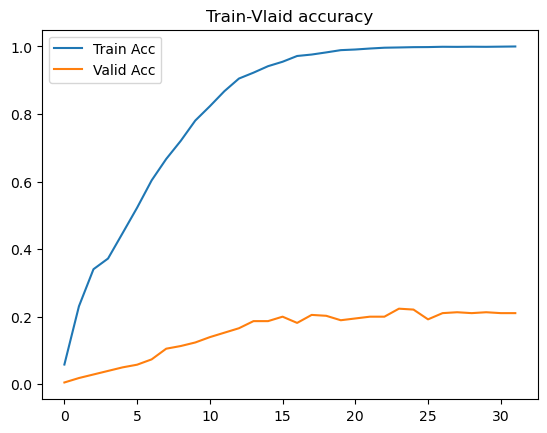

epoch 32 loss: 0.0475:   1%|▌                                        | 1/80 [00:04<05:36,  4.26s/it]

111
222
111
222


epoch 32 loss: 0.0475:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 32 loss: 0.0474:   6%|██▌                                      | 5/80 [00:05<00:40,  1.83it/s]

111
222
111
222


epoch 32 loss: 0.0472:   9%|███▌                                     | 7/80 [00:08<01:37,  1.34s/it]

111
222
111
222


epoch 32 loss: 0.0470:  11%|████▌                                    | 9/80 [00:08<00:51,  1.37it/s]

111
222
111
222


epoch 32 loss: 0.0468:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.24it/s]

111
222
111
222


epoch 32 loss: 0.0466:  16%|██████▌                                 | 13/80 [00:12<01:26,  1.29s/it]

111
222
111
222


epoch 32 loss: 0.0463:  19%|███████▌                                | 15/80 [00:13<00:47,  1.38it/s]

111
222
111
222


epoch 32 loss: 0.0461:  21%|████████▌                               | 17/80 [00:13<00:28,  2.22it/s]

111
222
111
222


epoch 32 loss: 0.0460:  24%|█████████▌                              | 19/80 [00:16<01:14,  1.22s/it]

111
222
111
222


epoch 32 loss: 0.0461:  26%|██████████▌                             | 21/80 [00:17<00:40,  1.44it/s]

111
222
111
222


epoch 32 loss: 0.0460:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.28it/s]

111
222
111
222


epoch 32 loss: 0.0460:  31%|████████████▌                           | 25/80 [00:21<01:07,  1.22s/it]

111
222
111
222


epoch 32 loss: 0.0461:  34%|█████████████▌                          | 27/80 [00:21<00:36,  1.43it/s]

111
222
111
222


epoch 32 loss: 0.0461:  36%|██████████████▌                         | 29/80 [00:21<00:22,  2.26it/s]

111
222
111
222


epoch 32 loss: 0.0463:  39%|███████████████▌                        | 31/80 [00:25<01:00,  1.23s/it]

111
222
111
222


epoch 32 loss: 0.0462:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.43it/s]

111
222
111
222


epoch 32 loss: 0.0461:  44%|█████████████████▌                      | 35/80 [00:26<00:19,  2.27it/s]

111
222
111
222


epoch 32 loss: 0.0460:  46%|██████████████████▌                     | 37/80 [00:29<00:50,  1.19s/it]

111
222


epoch 32 loss: 0.0459:  48%|███████████████████                     | 38/80 [00:29<00:42,  1.00s/it]

111
222


epoch 32 loss: 0.0458:  49%|███████████████████▌                    | 39/80 [00:30<00:31,  1.32it/s]

111
222
111
222


epoch 32 loss: 0.0460:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.12it/s]

111
222
111
222


epoch 32 loss: 0.0460:  54%|█████████████████████▌                  | 43/80 [00:33<00:41,  1.12s/it]

111
222


epoch 32 loss: 0.0459:  55%|██████████████████████                  | 44/80 [00:33<00:32,  1.10it/s]

111
222


epoch 32 loss: 0.0458:  56%|██████████████████████▌                 | 45/80 [00:34<00:24,  1.44it/s]

111
222
111
222


epoch 32 loss: 0.0456:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.28it/s]

111
222
111
222


epoch 32 loss: 0.0455:  61%|████████████████████████▌               | 49/80 [00:37<00:35,  1.13s/it]

111
222


epoch 32 loss: 0.0454:  62%|█████████████████████████               | 50/80 [00:38<00:28,  1.06it/s]

111
222


epoch 32 loss: 0.0452:  64%|█████████████████████████▌              | 51/80 [00:38<00:20,  1.40it/s]

111
222
111
222


epoch 32 loss: 0.0453:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.24it/s]

111
222
111
222


epoch 32 loss: 0.0450:  69%|███████████████████████████▌            | 55/80 [00:41<00:28,  1.12s/it]

111
222


epoch 32 loss: 0.0449:  70%|████████████████████████████            | 56/80 [00:42<00:22,  1.08it/s]

111
222
111


epoch 32 loss: 0.0450:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.42it/s]

222
111
222


epoch 32 loss: 0.0449:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.26it/s]

111
222
111
222


epoch 32 loss: 0.0446:  76%|██████████████████████████████▌         | 61/80 [00:45<00:21,  1.15s/it]

111
222


epoch 32 loss: 0.0447:  78%|███████████████████████████████         | 62/80 [00:46<00:19,  1.06s/it]

111
222


epoch 32 loss: 0.0445:  79%|███████████████████████████████▌        | 63/80 [00:47<00:13,  1.24it/s]

111
222
111
222


epoch 32 loss: 0.0443:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  2.04it/s]

111
222
111
222


epoch 32 loss: 0.0441:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:12,  1.01it/s]

111
222


epoch 32 loss: 0.0441:  85%|██████████████████████████████████      | 68/80 [00:50<00:11,  1.02it/s]

111
222


epoch 32 loss: 0.0440:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:08,  1.34it/s]

111
222
111
222


epoch 32 loss: 0.0440:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.15it/s]

111
222
111
222


epoch 32 loss: 0.0438:  91%|████████████████████████████████████▌   | 73/80 [00:53<00:06,  1.05it/s]

111
222


epoch 32 loss: 0.0439:  92%|█████████████████████████████████████   | 74/80 [00:55<00:05,  1.01it/s]

111
222
111
222


epoch 32 loss: 0.0437:  95%|██████████████████████████████████████  | 76/80 [00:55<00:02,  1.74it/s]

111
222
111


epoch 32 loss: 0.0437:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.19it/s]

222
111
222


epoch 32 loss: 0.0444:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.21it/s]

111
222
111
222


epoch 32 loss: 0.0444: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]

333
train accuracy = 0.99937
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 32 loss: 4.0298: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.41it/s]


validation accuracy = 0.20526
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


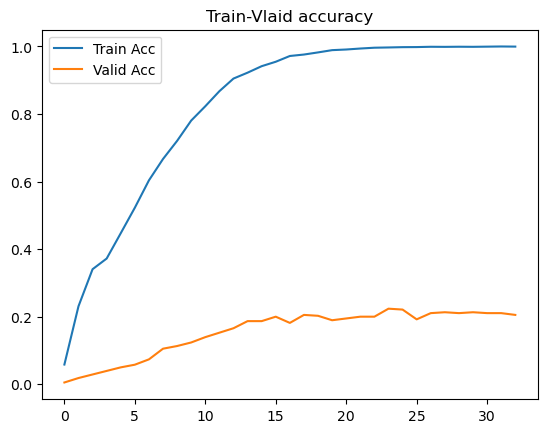

epoch 33 loss: 0.0342:   1%|▌                                        | 1/80 [00:04<05:48,  4.42s/it]

111
222
111
222


epoch 33 loss: 0.0342:   4%|█▌                                       | 3/80 [00:04<01:27,  1.14s/it]

111
222
111
222


epoch 33 loss: 0.0344:   6%|██▌                                      | 5/80 [00:05<00:42,  1.78it/s]

111
222
111


epoch 33 loss: 0.0344:   8%|███                                      | 6/80 [00:05<00:41,  1.80it/s]

222


epoch 33 loss: 0.0343:   9%|███▌                                     | 7/80 [00:08<01:39,  1.37s/it]

111
222
111
222


epoch 33 loss: 0.0343:  11%|████▌                                    | 9/80 [00:09<00:52,  1.35it/s]

111
222
111
222


epoch 33 loss: 0.0347:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.19it/s]

111
222
111
222


epoch 33 loss: 0.0348:  16%|██████▌                                 | 13/80 [00:13<01:24,  1.26s/it]

111
222
111
222


epoch 33 loss: 0.0347:  19%|███████▌                                | 15/80 [00:13<00:46,  1.40it/s]

111
222
111
222


epoch 33 loss: 0.0347:  21%|████████▌                               | 17/80 [00:13<00:28,  2.24it/s]

111
222
111
222


epoch 33 loss: 0.0347:  24%|█████████▌                              | 19/80 [00:17<01:13,  1.21s/it]

111
222
111
222


epoch 33 loss: 0.0347:  26%|██████████▌                             | 21/80 [00:17<00:40,  1.45it/s]

111
222
111
222


epoch 33 loss: 0.0350:  29%|███████████▌                            | 23/80 [00:17<00:24,  2.30it/s]

111
222
111
222


epoch 33 loss: 0.0349:  31%|████████████▌                           | 25/80 [00:21<01:07,  1.22s/it]

111
222
111
222


epoch 33 loss: 0.0348:  34%|█████████████▌                          | 27/80 [00:21<00:36,  1.44it/s]

111
222
111
222


epoch 33 loss: 0.0348:  36%|██████████████▌                         | 29/80 [00:22<00:22,  2.28it/s]

111
222
111
222


epoch 33 loss: 0.0348:  39%|███████████████▌                        | 31/80 [00:25<01:01,  1.26s/it]

111
222
111
222


epoch 33 loss: 0.0348:  41%|████████████████▌                       | 33/80 [00:26<00:33,  1.39it/s]

111
222
111
222


epoch 33 loss: 0.0348:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.22it/s]

111
222
111
222


epoch 33 loss: 0.0348:  46%|██████████████████▌                     | 37/80 [00:29<00:50,  1.17s/it]

111
222
111
222


epoch 33 loss: 0.0347:  49%|███████████████████▌                    | 39/80 [00:29<00:27,  1.49it/s]

111
222
111
222


epoch 33 loss: 0.0349:  51%|████████████████████▌                   | 41/80 [00:30<00:16,  2.34it/s]

111
222
111
222


epoch 33 loss: 0.0349:  54%|█████████████████████▌                  | 43/80 [00:33<00:45,  1.23s/it]

111
222
111
222


epoch 33 loss: 0.0348:  56%|██████████████████████▌                 | 45/80 [00:34<00:24,  1.43it/s]

111
222
111
222


epoch 33 loss: 0.0348:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.28it/s]

111
222
111
222


epoch 33 loss: 0.0349:  61%|████████████████████████▌               | 49/80 [00:38<00:40,  1.29s/it]

111
222
111
222


epoch 33 loss: 0.0350:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.37it/s]

111
222
111
222


epoch 33 loss: 0.0350:  66%|██████████████████████████▌             | 53/80 [00:39<00:12,  2.19it/s]

111
222
111
222


epoch 33 loss: 0.0352:  69%|███████████████████████████▌            | 55/80 [00:42<00:31,  1.27s/it]

111
222
111
222


epoch 33 loss: 0.0352:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.38it/s]

111
222
111
222


epoch 33 loss: 0.0353:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.21it/s]

111
222
111
222


epoch 33 loss: 0.0356:  76%|██████████████████████████████▌         | 61/80 [00:46<00:23,  1.22s/it]

111
222
111
222


epoch 33 loss: 0.0355:  79%|███████████████████████████████▌        | 63/80 [00:47<00:11,  1.44it/s]

111
222
111
222


epoch 33 loss: 0.0356:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.30it/s]

111
222
111
222


epoch 33 loss: 0.0356:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:16,  1.25s/it]

111
222
111
222


epoch 33 loss: 0.0358:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.41it/s]

111
222
111
222


epoch 33 loss: 0.0361:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.24it/s]

111
222
111
222


epoch 33 loss: 0.0360:  91%|████████████████████████████████████▌   | 73/80 [00:55<00:08,  1.22s/it]

111
222
111
222


epoch 33 loss: 0.0361:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.46it/s]

111
222
111
222


epoch 33 loss: 0.0363:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.36it/s]

111
222
111
222


epoch 33 loss: 0.0362:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.08s/it]

111
222
111
222


epoch 33 loss: 0.0380: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.36it/s]

333
train accuracy = 0.99949
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 33 loss: 4.0317: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.63it/s]


validation accuracy = 0.21842
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


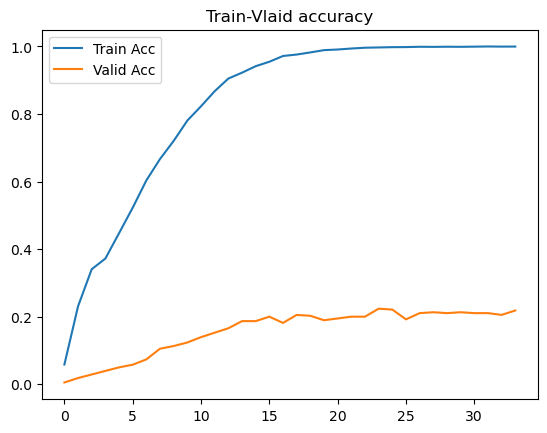

epoch 34 loss: 0.0250:   1%|▌                                        | 1/80 [00:04<05:51,  4.44s/it]

111
222
111
222


epoch 34 loss: 0.0252:   4%|█▌                                       | 3/80 [00:04<01:28,  1.14s/it]

111
222
111
222


epoch 34 loss: 0.0253:   6%|██▌                                      | 5/80 [00:05<00:41,  1.79it/s]

111
222
111
222


epoch 34 loss: 0.0256:   9%|███▌                                     | 7/80 [00:08<01:35,  1.31s/it]

111
222


epoch 34 loss: 0.0258:  10%|████                                     | 8/80 [00:08<01:09,  1.03it/s]

111
222


epoch 34 loss: 0.0259:  11%|████▌                                    | 9/80 [00:09<00:57,  1.24it/s]

111
222
111
222


epoch 34 loss: 0.0261:  14%|█████▌                                  | 11/80 [00:09<00:33,  2.05it/s]

111
222
111
222


epoch 34 loss: 0.0263:  16%|██████▌                                 | 13/80 [00:12<01:15,  1.13s/it]

111
222


epoch 34 loss: 0.0265:  18%|███████                                 | 14/80 [00:12<00:58,  1.13it/s]

111
222


epoch 34 loss: 0.0266:  19%|███████▌                                | 15/80 [00:13<00:47,  1.37it/s]

111
222
111
222


epoch 34 loss: 0.0268:  21%|████████▌                               | 17/80 [00:13<00:28,  2.19it/s]

111
222
111
222


epoch 34 loss: 0.0269:  24%|█████████▌                              | 19/80 [00:16<01:11,  1.17s/it]

111
222


epoch 34 loss: 0.0270:  25%|██████████                              | 20/80 [00:17<00:53,  1.13it/s]

111
222


epoch 34 loss: 0.0271:  26%|██████████▌                             | 21/80 [00:17<00:43,  1.35it/s]

111
222
111
222


epoch 34 loss: 0.0272:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.16it/s]

111
222
111
222


epoch 34 loss: 0.0274:  31%|████████████▌                           | 25/80 [00:20<01:00,  1.11s/it]

111
222


epoch 34 loss: 0.0275:  32%|█████████████                           | 26/80 [00:21<00:47,  1.14it/s]

111
222


epoch 34 loss: 0.0275:  34%|█████████████▌                          | 27/80 [00:21<00:39,  1.36it/s]

111
222
111
222


epoch 34 loss: 0.0275:  36%|██████████████▌                         | 29/80 [00:22<00:23,  2.18it/s]

111
222
111
222


epoch 34 loss: 0.0276:  39%|███████████████▌                        | 31/80 [00:24<00:52,  1.08s/it]

111
222


epoch 34 loss: 0.0276:  40%|████████████████                        | 32/80 [00:25<00:47,  1.00it/s]

111
222


epoch 34 loss: 0.0277:  41%|████████████████▌                       | 33/80 [00:25<00:35,  1.32it/s]

111
222
111
222


epoch 34 loss: 0.0277:  44%|█████████████████▌                      | 35/80 [00:26<00:21,  2.13it/s]

111
222
111
222


epoch 34 loss: 0.0279:  46%|██████████████████▌                     | 37/80 [00:29<00:45,  1.06s/it]

111
222


epoch 34 loss: 0.0279:  48%|███████████████████                     | 38/80 [00:30<00:43,  1.03s/it]

111
222


epoch 34 loss: 0.0280:  49%|███████████████████▌                    | 39/80 [00:30<00:32,  1.28it/s]

111
222
111
222


epoch 34 loss: 0.0282:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.08it/s]

111
222
111
222


epoch 34 loss: 0.0285:  54%|█████████████████████▌                  | 43/80 [00:33<00:39,  1.07s/it]

111
222


epoch 34 loss: 0.0285:  55%|██████████████████████                  | 44/80 [00:34<00:34,  1.05it/s]

111
222


epoch 34 loss: 0.0286:  56%|██████████████████████▌                 | 45/80 [00:34<00:25,  1.38it/s]

111
222
111
222


epoch 34 loss: 0.0285:  59%|███████████████████████▌                | 47/80 [00:34<00:15,  2.20it/s]

111
222
111
222


epoch 34 loss: 0.0286:  61%|████████████████████████▌               | 49/80 [00:37<00:34,  1.10s/it]

111
222


epoch 34 loss: 0.0286:  62%|█████████████████████████               | 50/80 [00:38<00:28,  1.07it/s]

111
222


epoch 34 loss: 0.0287:  64%|█████████████████████████▌              | 51/80 [00:38<00:20,  1.41it/s]

111
222
111
222


epoch 34 loss: 0.0288:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.25it/s]

111
222
111
222


epoch 34 loss: 0.0290:  69%|███████████████████████████▌            | 55/80 [00:41<00:27,  1.10s/it]

111
222


epoch 34 loss: 0.0292:  70%|████████████████████████████            | 56/80 [00:42<00:24,  1.03s/it]

111
222


epoch 34 loss: 0.0293:  71%|████████████████████████████▌           | 57/80 [00:42<00:17,  1.29it/s]

111
222
111
222


epoch 34 loss: 0.0295:  74%|█████████████████████████████▌          | 59/80 [00:43<00:10,  2.08it/s]

111
222
111
222


epoch 34 loss: 0.0296:  76%|██████████████████████████████▌         | 61/80 [00:46<00:20,  1.10s/it]

111
222


epoch 34 loss: 0.0297:  78%|███████████████████████████████         | 62/80 [00:46<00:17,  1.05it/s]

111
222


epoch 34 loss: 0.0298:  79%|███████████████████████████████▌        | 63/80 [00:47<00:12,  1.38it/s]

111
222
111
222


epoch 34 loss: 0.0300:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.21it/s]

111
222
111
222


epoch 34 loss: 0.0301:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:14,  1.11s/it]

111
222


epoch 34 loss: 0.0303:  85%|██████████████████████████████████      | 68/80 [00:50<00:11,  1.09it/s]

111
222


epoch 34 loss: 0.0304:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.42it/s]

111
222
111
222


epoch 34 loss: 0.0306:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:03,  2.27it/s]

111
222
111
222


epoch 34 loss: 0.0307:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.21s/it]

111
222
111
222


epoch 34 loss: 0.0308:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.47it/s]

111
222
111
222


epoch 34 loss: 0.0310:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.37it/s]

111
222
111
222


epoch 34 loss: 0.0333:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.07s/it]

111
222
111
222


epoch 34 loss: 0.0333: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.99987
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 34 loss: 4.0693: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.52it/s]


validation accuracy = 0.20526
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


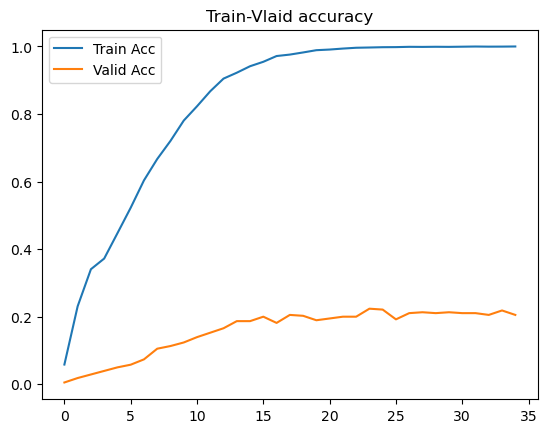

epoch 35 loss: 0.0305:   1%|▌                                        | 1/80 [00:04<05:43,  4.35s/it]

111
222
111
222


epoch 35 loss: 0.0306:   4%|█▌                                       | 3/80 [00:04<01:26,  1.12s/it]

111
222
111
222


epoch 35 loss: 0.0307:   6%|██▌                                      | 5/80 [00:05<00:41,  1.81it/s]

111
222
111
222


epoch 35 loss: 0.0308:   9%|███▌                                     | 7/80 [00:08<01:39,  1.36s/it]

111
222
111
222


epoch 35 loss: 0.0310:  11%|████▌                                    | 9/80 [00:09<00:53,  1.32it/s]

111
222
111
222


epoch 35 loss: 0.0311:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.16it/s]

111
222
111
222


epoch 35 loss: 0.0311:  16%|██████▌                                 | 13/80 [00:12<01:18,  1.17s/it]

111
222
111
222


epoch 35 loss: 0.0313:  19%|███████▌                                | 15/80 [00:13<00:47,  1.36it/s]

111
222
111
222


epoch 35 loss: 0.0314:  21%|████████▌                               | 17/80 [00:13<00:28,  2.19it/s]

111
222
111
222


epoch 35 loss: 0.0315:  24%|█████████▌                              | 19/80 [00:16<01:08,  1.12s/it]

111
222
111
222


epoch 35 loss: 0.0315:  26%|██████████▌                             | 21/80 [00:17<00:44,  1.31it/s]

111
222
111
222


epoch 35 loss: 0.0316:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.12it/s]

111
222
111
222


epoch 35 loss: 0.0316:  31%|████████████▌                           | 25/80 [00:20<01:05,  1.19s/it]

111
222
111
222


epoch 35 loss: 0.0318:  34%|█████████████▌                          | 27/80 [00:21<00:36,  1.45it/s]

111
222


epoch 35 loss: 0.0318:  35%|██████████████                          | 28/80 [00:21<00:28,  1.83it/s]

111
222


epoch 35 loss: 0.0318:  36%|██████████████▌                         | 29/80 [00:21<00:22,  2.26it/s]

111
222
111
222


epoch 35 loss: 0.0318:  39%|███████████████▌                        | 31/80 [00:25<00:59,  1.22s/it]

111
222
111
222


epoch 35 loss: 0.0319:  41%|████████████████▌                       | 33/80 [00:25<00:33,  1.40it/s]

111
222
111


epoch 35 loss: 0.0319:  42%|█████████████████                       | 34/80 [00:25<00:25,  1.77it/s]

222
111


epoch 35 loss: 0.0319:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.21it/s]

222
111
222


epoch 35 loss: 0.0321:  46%|██████████████████▌                     | 37/80 [00:29<00:50,  1.19s/it]

111
222
111
222


epoch 35 loss: 0.0321:  49%|███████████████████▌                    | 39/80 [00:29<00:31,  1.32it/s]

111
222
111
222


epoch 35 loss: 0.0321:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.13it/s]

111
222
111
222


epoch 35 loss: 0.0322:  54%|█████████████████████▌                  | 43/80 [00:33<00:41,  1.12s/it]

111
222
111
222


epoch 35 loss: 0.0322:  56%|██████████████████████▌                 | 45/80 [00:34<00:26,  1.32it/s]

111
222
111
222


epoch 35 loss: 0.0322:  59%|███████████████████████▌                | 47/80 [00:34<00:15,  2.11it/s]

111
222
111
222


epoch 35 loss: 0.0322:  61%|████████████████████████▌               | 49/80 [00:37<00:36,  1.18s/it]

111
222
111
222


epoch 35 loss: 0.0322:  64%|█████████████████████████▌              | 51/80 [00:38<00:20,  1.44it/s]

111
222
111


epoch 35 loss: 0.0322:  65%|██████████████████████████              | 52/80 [00:38<00:15,  1.82it/s]

222


epoch 35 loss: 0.0323:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.24it/s]

111
222
111
222


epoch 35 loss: 0.0325:  69%|███████████████████████████▌            | 55/80 [00:41<00:28,  1.13s/it]

111
222
111
222


epoch 35 loss: 0.0326:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.36it/s]

111
222


epoch 35 loss: 0.0325:  72%|█████████████████████████████           | 58/80 [00:42<00:13,  1.66it/s]

111
222


epoch 35 loss: 0.0325:  74%|█████████████████████████████▌          | 59/80 [00:42<00:10,  2.08it/s]

111
222
111
222


epoch 35 loss: 0.0325:  76%|██████████████████████████████▌         | 61/80 [00:45<00:20,  1.09s/it]

111
222
111
222


epoch 35 loss: 0.0326:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.33it/s]

111
222
111
222


epoch 35 loss: 0.0325:  81%|████████████████████████████████▌       | 65/80 [00:46<00:07,  2.14it/s]

111
222
111
222


epoch 35 loss: 0.0325:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:14,  1.08s/it]

111
222
111
222


epoch 35 loss: 0.0325:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:08,  1.30it/s]

111
222


epoch 35 loss: 0.0325:  88%|███████████████████████████████████     | 70/80 [00:51<00:06,  1.55it/s]

111
222


epoch 35 loss: 0.0326:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  1.96it/s]

111
222
111
222


epoch 35 loss: 0.0326:  91%|████████████████████████████████████▌   | 73/80 [00:53<00:07,  1.03s/it]

111
222
111
222


epoch 35 loss: 0.0325:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.33it/s]

111
222


epoch 35 loss: 0.0326:  95%|██████████████████████████████████████  | 76/80 [00:55<00:02,  1.54it/s]

111
222
111


epoch 35 loss: 0.0326:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  1.97it/s]

222
111
222


epoch 35 loss: 0.0341:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.14it/s]

111
222
111
222


epoch 35 loss: 0.0341: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]

333
train accuracy = 0.99962
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 35 loss: 4.0628: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.02it/s]


validation accuracy = 0.20526
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]


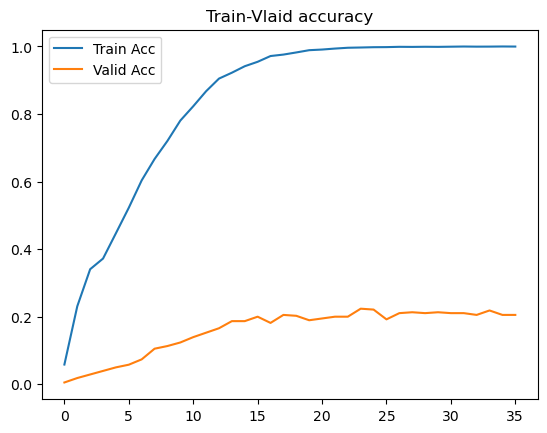

epoch 36 loss: 0.0316:   1%|▌                                        | 1/80 [00:04<05:37,  4.27s/it]

111
222
111


epoch 36 loss: 0.0318:   2%|█                                        | 2/80 [00:04<02:26,  1.87s/it]

222
111


epoch 36 loss: 0.0319:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

222
111
222


epoch 36 loss: 0.0320:   6%|██▌                                      | 5/80 [00:05<00:41,  1.82it/s]

111
222
111
222


epoch 36 loss: 0.0319:   9%|███▌                                     | 7/80 [00:08<01:38,  1.35s/it]

111
222
111
222


epoch 36 loss: 0.0320:  11%|████▌                                    | 9/80 [00:08<00:52,  1.36it/s]

111
222
111
222


epoch 36 loss: 0.0319:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.21it/s]

111
222
111
222


epoch 36 loss: 0.0319:  16%|██████▌                                 | 13/80 [00:13<01:30,  1.35s/it]

111
222
111
222


epoch 36 loss: 0.0319:  19%|███████▌                                | 15/80 [00:13<00:49,  1.33it/s]

111
222
111
222


epoch 36 loss: 0.0321:  21%|████████▌                               | 17/80 [00:13<00:29,  2.14it/s]

111
222
111
222


epoch 36 loss: 0.0321:  24%|█████████▌                              | 19/80 [00:17<01:12,  1.20s/it]

111
222
111
222


epoch 36 loss: 0.0322:  26%|██████████▌                             | 21/80 [00:17<00:40,  1.46it/s]

111
222
111
222


epoch 36 loss: 0.0321:  29%|███████████▌                            | 23/80 [00:17<00:24,  2.30it/s]

111
222
111
222


epoch 36 loss: 0.0321:  31%|████████████▌                           | 25/80 [00:21<01:04,  1.18s/it]

111
222
111
222


epoch 36 loss: 0.0323:  34%|█████████████▌                          | 27/80 [00:21<00:35,  1.48it/s]

111
222
111
222


epoch 36 loss: 0.0323:  36%|██████████████▌                         | 29/80 [00:21<00:22,  2.31it/s]

111
222
111
222


epoch 36 loss: 0.0323:  39%|███████████████▌                        | 31/80 [00:25<00:59,  1.22s/it]

111
222
111
222


epoch 36 loss: 0.0324:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.44it/s]

111
222
111
222


epoch 36 loss: 0.0322:  44%|█████████████████▌                      | 35/80 [00:26<00:19,  2.28it/s]

111
222
111
222


epoch 36 loss: 0.0322:  46%|██████████████████▌                     | 37/80 [00:29<00:51,  1.19s/it]

111
222
111
222


epoch 36 loss: 0.0321:  49%|███████████████████▌                    | 39/80 [00:29<00:27,  1.47it/s]

111
222
111
222


epoch 36 loss: 0.0321:  51%|████████████████████▌                   | 41/80 [00:30<00:16,  2.33it/s]

111
222
111
222


epoch 36 loss: 0.0320:  54%|█████████████████████▌                  | 43/80 [00:33<00:44,  1.20s/it]

111
222
111
222


epoch 36 loss: 0.0322:  56%|██████████████████████▌                 | 45/80 [00:34<00:25,  1.39it/s]

111
222
111
222


epoch 36 loss: 0.0320:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.21it/s]

111
222
111
222


epoch 36 loss: 0.0319:  61%|████████████████████████▌               | 49/80 [00:37<00:37,  1.21s/it]

111
222
111
222


epoch 36 loss: 0.0320:  64%|█████████████████████████▌              | 51/80 [00:38<00:20,  1.41it/s]

111
222
111
222


epoch 36 loss: 0.0321:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.24it/s]

111
222
111
222


epoch 36 loss: 0.0321:  69%|███████████████████████████▌            | 55/80 [00:41<00:29,  1.17s/it]

111
222
111
222


epoch 36 loss: 0.0320:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.39it/s]

111
222
111
222


epoch 36 loss: 0.0321:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.23it/s]

111
222
111
222


epoch 36 loss: 0.0321:  76%|██████████████████████████████▌         | 61/80 [00:45<00:22,  1.16s/it]

111
222
111
222


epoch 36 loss: 0.0320:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.38it/s]

111
222
111
222


epoch 36 loss: 0.0320:  81%|████████████████████████████████▌       | 65/80 [00:46<00:06,  2.23it/s]

111
222
111
222


epoch 36 loss: 0.0320:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:14,  1.12s/it]

111
222
111
222


epoch 36 loss: 0.0320:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.41it/s]

111
222
111
222


epoch 36 loss: 0.0319:  89%|███████████████████████████████████▌    | 71/80 [00:50<00:04,  2.25it/s]

111
222
111
222


epoch 36 loss: 0.0319:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.14s/it]

111
222
111
222


epoch 36 loss: 0.0317:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.39it/s]

111
222
111
222


epoch 36 loss: 0.0316:  96%|██████████████████████████████████████▌ | 77/80 [00:54<00:01,  2.25it/s]

111
222
111
222


epoch 36 loss: 0.0319:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.01it/s]

111
222
111
222


epoch 36 loss: 0.0324: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]

333
train accuracy = 0.99962
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 54  1  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 36 loss: 4.0876: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.95it/s]


validation accuracy = 0.20000
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]


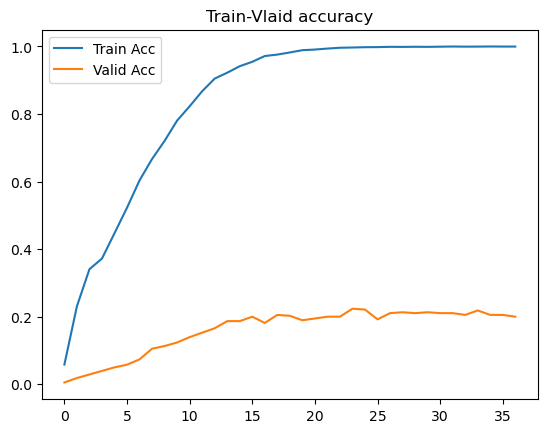

epoch 37 loss: 0.0348:   1%|▌                                        | 1/80 [00:04<05:41,  4.32s/it]

111
222
111
222


epoch 37 loss: 0.0347:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 37 loss: 0.0346:   6%|██▌                                      | 5/80 [00:05<00:41,  1.82it/s]

111
222
111
222


epoch 37 loss: 0.0345:   9%|███▌                                     | 7/80 [00:08<01:44,  1.43s/it]

111
222
111
222


epoch 37 loss: 0.0344:  11%|████▌                                    | 9/80 [00:09<00:54,  1.29it/s]

111
222
111
222


epoch 37 loss: 0.0342:  14%|█████▌                                  | 11/80 [00:09<00:32,  2.13it/s]

111
222
111
222


epoch 37 loss: 0.0341:  16%|██████▌                                 | 13/80 [00:12<01:24,  1.26s/it]

111
222
111
222


epoch 37 loss: 0.0341:  19%|███████▌                                | 15/80 [00:13<00:46,  1.40it/s]

111
222
111
222


epoch 37 loss: 0.0341:  21%|████████▌                               | 17/80 [00:13<00:27,  2.26it/s]

111
222
111
222


epoch 37 loss: 0.0340:  24%|█████████▌                              | 19/80 [00:17<01:18,  1.29s/it]

111
222
111
222


epoch 37 loss: 0.0337:  26%|██████████▌                             | 21/80 [00:17<00:43,  1.37it/s]

111
222
111
222


epoch 37 loss: 0.0337:  29%|███████████▌                            | 23/80 [00:18<00:26,  2.19it/s]

111
222
111
222


epoch 37 loss: 0.0336:  31%|████████████▌                           | 25/80 [00:21<01:04,  1.17s/it]

111
222
111
222


epoch 37 loss: 0.0336:  34%|█████████████▌                          | 27/80 [00:21<00:35,  1.49it/s]

111
222
111
222


epoch 37 loss: 0.0336:  36%|██████████████▌                         | 29/80 [00:22<00:21,  2.36it/s]

111
222
111
222


epoch 37 loss: 0.0335:  39%|███████████████▌                        | 31/80 [00:25<00:59,  1.22s/it]

111
222
111
222


epoch 37 loss: 0.0333:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.43it/s]

111
222
111
222


epoch 37 loss: 0.0332:  44%|█████████████████▌                      | 35/80 [00:26<00:19,  2.28it/s]

111
222
111
222


epoch 37 loss: 0.0332:  46%|██████████████████▌                     | 37/80 [00:29<00:55,  1.30s/it]

111
222
111
222


epoch 37 loss: 0.0330:  49%|███████████████████▌                    | 39/80 [00:30<00:29,  1.37it/s]

111
222
111
222


epoch 37 loss: 0.0330:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.08it/s]

111
222
111
222


epoch 37 loss: 0.0328:  54%|█████████████████████▌                  | 43/80 [00:34<00:44,  1.19s/it]

111
222
111
222


epoch 37 loss: 0.0328:  56%|██████████████████████▌                 | 45/80 [00:34<00:23,  1.47it/s]

111
222
111
222


epoch 37 loss: 0.0326:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.31it/s]

111
222
111
222


epoch 37 loss: 0.0327:  61%|████████████████████████▌               | 49/80 [00:38<00:37,  1.20s/it]

111
222
111
222


epoch 37 loss: 0.0328:  64%|█████████████████████████▌              | 51/80 [00:38<00:19,  1.45it/s]

111
222
111
222


epoch 37 loss: 0.0328:  66%|██████████████████████████▌             | 53/80 [00:38<00:11,  2.29it/s]

111
222
111
222


epoch 37 loss: 0.0326:  69%|███████████████████████████▌            | 55/80 [00:42<00:31,  1.25s/it]

111
222
111
222


epoch 37 loss: 0.0324:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.41it/s]

111
222
111
222


epoch 37 loss: 0.0321:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.24it/s]

111
222
111
222


epoch 37 loss: 0.0320:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.19s/it]

111
222
111
222


epoch 37 loss: 0.0320:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.47it/s]

111
222
111
222


epoch 37 loss: 0.0320:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.32it/s]

111
222
111
222


epoch 37 loss: 0.0320:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:16,  1.25s/it]

111
222
111
222


epoch 37 loss: 0.0319:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.41it/s]

111
222
111
222


epoch 37 loss: 0.0318:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.24it/s]

111
222
111
222


epoch 37 loss: 0.0319:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.21s/it]

111
222
111
222


epoch 37 loss: 0.0318:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.46it/s]

111
222
111
222


epoch 37 loss: 0.0317:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.36it/s]

111
222
111
222


epoch 37 loss: 0.0316:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.05s/it]

111
222
111
222


epoch 37 loss: 0.0321: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.36it/s]

333
train accuracy = 0.99975
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 37 loss: 4.0823: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.90it/s]


validation accuracy = 0.20263
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


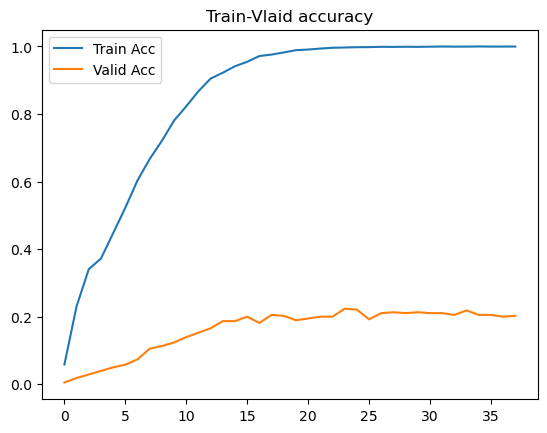

epoch 38 loss: 0.0239:   1%|▌                                        | 1/80 [00:04<05:41,  4.32s/it]

111
222
111
222


epoch 38 loss: 0.0239:   4%|█▌                                       | 3/80 [00:04<01:26,  1.12s/it]

111
222
111
222


epoch 38 loss: 0.0240:   6%|██▌                                      | 5/80 [00:05<00:40,  1.83it/s]

111
222
111
222


epoch 38 loss: 0.0243:   9%|███▌                                     | 7/80 [00:08<01:35,  1.31s/it]

111
222


epoch 38 loss: 0.0244:  10%|████                                     | 8/80 [00:08<01:11,  1.00it/s]

111
222


epoch 38 loss: 0.0243:  11%|████▌                                    | 9/80 [00:08<00:53,  1.34it/s]

111
222
111
222


epoch 38 loss: 0.0244:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.19it/s]

111
222
111
222


epoch 38 loss: 0.0245:  16%|██████▌                                 | 13/80 [00:12<01:16,  1.15s/it]

111
222


epoch 38 loss: 0.0244:  18%|███████                                 | 14/80 [00:12<01:00,  1.09it/s]

111
222


epoch 38 loss: 0.0245:  19%|███████▌                                | 15/80 [00:12<00:45,  1.43it/s]

111
222
111
222


epoch 38 loss: 0.0247:  21%|████████▌                               | 17/80 [00:13<00:27,  2.27it/s]

111
222
111
222


epoch 38 loss: 0.0247:  24%|█████████▌                              | 19/80 [00:16<01:07,  1.10s/it]

111
222


epoch 38 loss: 0.0248:  25%|██████████                              | 20/80 [00:17<00:59,  1.02it/s]

111
222


epoch 38 loss: 0.0248:  26%|██████████▌                             | 21/80 [00:17<00:44,  1.34it/s]

111
222
111
222


epoch 38 loss: 0.0249:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.15it/s]

111
222
111
222


epoch 38 loss: 0.0250:  31%|████████████▌                           | 25/80 [00:20<00:57,  1.05s/it]

111
222


epoch 38 loss: 0.0250:  32%|█████████████                           | 26/80 [00:21<00:52,  1.04it/s]

111
222


epoch 38 loss: 0.0252:  34%|█████████████▌                          | 27/80 [00:21<00:38,  1.36it/s]

111
222
111
222


epoch 38 loss: 0.0253:  36%|██████████████▌                         | 29/80 [00:21<00:23,  2.18it/s]

111
222
111
222


epoch 38 loss: 0.0253:  39%|███████████████▌                        | 31/80 [00:24<00:50,  1.03s/it]

111
222


epoch 38 loss: 0.0253:  40%|████████████████                        | 32/80 [00:25<00:51,  1.08s/it]

111
222


epoch 38 loss: 0.0252:  41%|████████████████▌                       | 33/80 [00:25<00:38,  1.23it/s]

111
222
111
222


epoch 38 loss: 0.0254:  44%|█████████████████▌                      | 35/80 [00:26<00:22,  2.02it/s]

111
222
111
222


epoch 38 loss: 0.0255:  46%|██████████████████▌                     | 37/80 [00:29<00:46,  1.07s/it]

111
222


epoch 38 loss: 0.0255:  48%|███████████████████                     | 38/80 [00:29<00:39,  1.06it/s]

111
222


epoch 38 loss: 0.0255:  49%|███████████████████▌                    | 39/80 [00:29<00:29,  1.38it/s]

111
222
111
222


epoch 38 loss: 0.0255:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.22it/s]

111
222
111
222


epoch 38 loss: 0.0257:  54%|█████████████████████▌                  | 43/80 [00:33<00:39,  1.07s/it]

111
222


epoch 38 loss: 0.0257:  55%|██████████████████████                  | 44/80 [00:33<00:34,  1.03it/s]

111
222


epoch 38 loss: 0.0258:  56%|██████████████████████▌                 | 45/80 [00:34<00:25,  1.35it/s]

111
222
111
222


epoch 38 loss: 0.0258:  59%|███████████████████████▌                | 47/80 [00:34<00:15,  2.17it/s]

111
222
111
222


epoch 38 loss: 0.0257:  61%|████████████████████████▌               | 49/80 [00:37<00:31,  1.00s/it]

111
222


epoch 38 loss: 0.0257:  62%|█████████████████████████               | 50/80 [00:38<00:29,  1.03it/s]

111
222


epoch 38 loss: 0.0259:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.35it/s]

111
222
111
222


epoch 38 loss: 0.0259:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.15it/s]

111
222
111
222


epoch 38 loss: 0.0259:  69%|███████████████████████████▌            | 55/80 [00:41<00:25,  1.01s/it]

111
222


epoch 38 loss: 0.0260:  70%|████████████████████████████            | 56/80 [00:42<00:24,  1.00s/it]

111
222


epoch 38 loss: 0.0259:  71%|████████████████████████████▌           | 57/80 [00:42<00:17,  1.31it/s]

111
222
111
222


epoch 38 loss: 0.0260:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.12it/s]

111
222
111
222


epoch 38 loss: 0.0261:  76%|██████████████████████████████▌         | 61/80 [00:45<00:18,  1.00it/s]

111
222


epoch 38 loss: 0.0260:  78%|███████████████████████████████         | 62/80 [00:46<00:17,  1.04it/s]

111
222


epoch 38 loss: 0.0260:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.37it/s]

111
222
111
222


epoch 38 loss: 0.0260:  81%|████████████████████████████████▌       | 65/80 [00:46<00:06,  2.20it/s]

111
222
111
222


epoch 38 loss: 0.0260:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:12,  1.01it/s]

111
222


epoch 38 loss: 0.0260:  85%|██████████████████████████████████      | 68/80 [00:50<00:11,  1.03it/s]

111
222


epoch 38 loss: 0.0261:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:08,  1.36it/s]

111
222
111
222


epoch 38 loss: 0.0262:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.17it/s]

111
222
111
222


epoch 38 loss: 0.0262:  91%|████████████████████████████████████▌   | 73/80 [00:53<00:06,  1.00it/s]

111
222


epoch 38 loss: 0.0263:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.05it/s]

111
222


epoch 38 loss: 0.0261:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.38it/s]

111
222
111
222


epoch 38 loss: 0.0263:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.22it/s]

111
222
111
222


epoch 38 loss: 0.0264:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.09it/s]

111
222
111
222


epoch 38 loss: 0.0272: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]

333
train accuracy = 0.99962
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 38 loss: 4.0848: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.99it/s]


validation accuracy = 0.22368
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


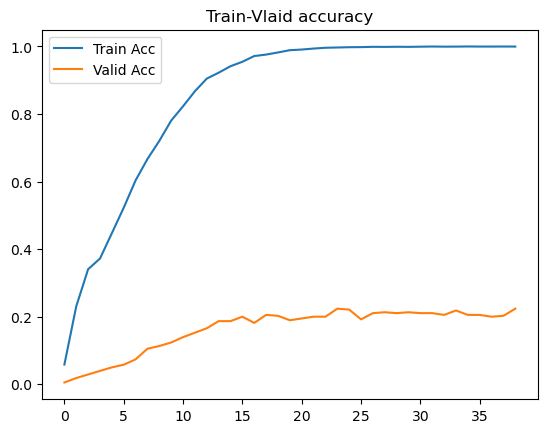

epoch 39 loss: 0.0344:   1%|▌                                        | 1/80 [00:04<05:31,  4.19s/it]

111
222
111


epoch 39 loss: 0.0343:   2%|█                                        | 2/80 [00:04<02:24,  1.85s/it]

222


epoch 39 loss: 0.0342:   4%|█▌                                       | 3/80 [00:04<01:24,  1.09s/it]

111
222
111
222


epoch 39 loss: 0.0340:   6%|██▌                                      | 5/80 [00:04<00:40,  1.84it/s]

111
222
111
222


epoch 39 loss: 0.0338:   9%|███▌                                     | 7/80 [00:08<01:38,  1.35s/it]

111
222
111
222


epoch 39 loss: 0.0337:  11%|████▌                                    | 9/80 [00:08<00:52,  1.36it/s]

111
222
111
222


epoch 39 loss: 0.0335:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.21it/s]

111
222
111
222


epoch 39 loss: 0.0334:  16%|██████▌                                 | 13/80 [00:12<01:23,  1.25s/it]

111
222
111
222


epoch 39 loss: 0.0332:  19%|███████▌                                | 15/80 [00:13<00:45,  1.42it/s]

111
222
111
222


epoch 39 loss: 0.0332:  21%|████████▌                               | 17/80 [00:13<00:28,  2.25it/s]

111
222
111
222


epoch 39 loss: 0.0332:  24%|█████████▌                              | 19/80 [00:16<01:16,  1.25s/it]

111
222
111
222


epoch 39 loss: 0.0330:  26%|██████████▌                             | 21/80 [00:17<00:41,  1.41it/s]

111
222
111
222


epoch 39 loss: 0.0328:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.24it/s]

111
222
111
222


epoch 39 loss: 0.0326:  31%|████████████▌                           | 25/80 [00:20<01:05,  1.19s/it]

111
222
111
222


epoch 39 loss: 0.0325:  34%|█████████████▌                          | 27/80 [00:21<00:36,  1.46it/s]

111
222
111
222


epoch 39 loss: 0.0324:  36%|██████████████▌                         | 29/80 [00:21<00:22,  2.28it/s]

111
222
111
222


epoch 39 loss: 0.0322:  39%|███████████████▌                        | 31/80 [00:25<01:01,  1.26s/it]

111
222
111
222


epoch 39 loss: 0.0321:  41%|████████████████▌                       | 33/80 [00:25<00:33,  1.40it/s]

111
222
111
222


epoch 39 loss: 0.0320:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.21it/s]

111
222
111
222


epoch 39 loss: 0.0319:  46%|██████████████████▌                     | 37/80 [00:29<00:51,  1.20s/it]

111
222
111
222


epoch 39 loss: 0.0318:  49%|███████████████████▌                    | 39/80 [00:29<00:28,  1.46it/s]

111
222
111
222


epoch 39 loss: 0.0319:  51%|████████████████████▌                   | 41/80 [00:30<00:16,  2.30it/s]

111
222
111
222


epoch 39 loss: 0.0316:  54%|█████████████████████▌                  | 43/80 [00:33<00:49,  1.33s/it]

111
222
111
222


epoch 39 loss: 0.0314:  56%|██████████████████████▌                 | 45/80 [00:34<00:26,  1.32it/s]

111
222
111
222


epoch 39 loss: 0.0313:  59%|███████████████████████▌                | 47/80 [00:34<00:15,  2.13it/s]

111
222
111
222


epoch 39 loss: 0.0313:  61%|████████████████████████▌               | 49/80 [00:38<00:39,  1.26s/it]

111
222
111
222


epoch 39 loss: 0.0312:  64%|█████████████████████████▌              | 51/80 [00:38<00:20,  1.40it/s]

111
222
111
222


epoch 39 loss: 0.0311:  66%|██████████████████████████▌             | 53/80 [00:39<00:12,  2.21it/s]

111
222
111
222


epoch 39 loss: 0.0310:  69%|███████████████████████████▌            | 55/80 [00:42<00:30,  1.22s/it]

111
222
111
222


epoch 39 loss: 0.0309:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.44it/s]

111
222
111
222


epoch 39 loss: 0.0308:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.27it/s]

111
222
111
222


epoch 39 loss: 0.0308:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.18s/it]

111
222
111
222


epoch 39 loss: 0.0308:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.48it/s]

111
222
111
222


epoch 39 loss: 0.0307:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.33it/s]

111
222
111
222


epoch 39 loss: 0.0306:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:16,  1.25s/it]

111
222
111
222


epoch 39 loss: 0.0305:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:07,  1.41it/s]

111
222
111
222


epoch 39 loss: 0.0305:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:03,  2.26it/s]

111
222
111
222


epoch 39 loss: 0.0303:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.22s/it]

111
222
111
222


epoch 39 loss: 0.0303:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.46it/s]

111
222
111
222


epoch 39 loss: 0.0301:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.34it/s]

111
222
111
222


epoch 39 loss: 0.0300:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.05s/it]

111
222
111
222


epoch 39 loss: 0.0313: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.99987
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 39 loss: 4.1197: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.23it/s]


validation accuracy = 0.21316
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


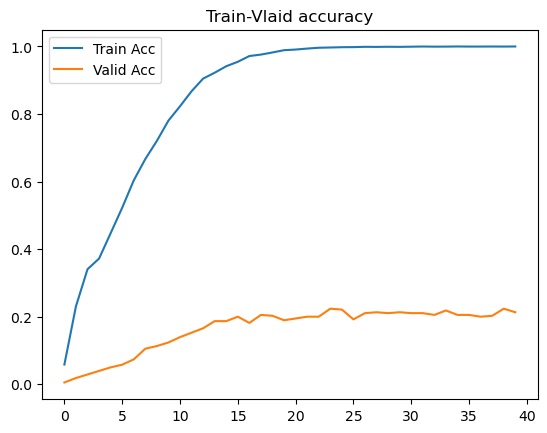

epoch 40 loss: 0.0191:   1%|▌                                        | 1/80 [00:04<05:35,  4.25s/it]

111
222
111


epoch 40 loss: 0.0191:   2%|█                                        | 2/80 [00:04<02:25,  1.87s/it]

222


epoch 40 loss: 0.0193:   4%|█▌                                       | 3/80 [00:04<01:25,  1.10s/it]

111
222
111
222


epoch 40 loss: 0.0193:   6%|██▌                                      | 5/80 [00:05<00:41,  1.83it/s]

111
222
111
222


epoch 40 loss: 0.0194:   9%|███▌                                     | 7/80 [00:08<01:37,  1.33s/it]

111
222
111
222


epoch 40 loss: 0.0194:  11%|████▌                                    | 9/80 [00:08<00:51,  1.37it/s]

111
222
111
222


epoch 40 loss: 0.0195:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.23it/s]

111
222
111
222


epoch 40 loss: 0.0196:  16%|██████▌                                 | 13/80 [00:12<01:20,  1.20s/it]

111
222
111
222


epoch 40 loss: 0.0197:  19%|███████▌                                | 15/80 [00:12<00:44,  1.46it/s]

111
222
111
222


epoch 40 loss: 0.0198:  21%|████████▌                               | 17/80 [00:13<00:27,  2.32it/s]

111
222
111
222


epoch 40 loss: 0.0199:  24%|█████████▌                              | 19/80 [00:16<01:12,  1.18s/it]

111
222


epoch 40 loss: 0.0199:  25%|██████████                              | 20/80 [00:16<00:53,  1.11it/s]

111
222


epoch 40 loss: 0.0201:  26%|██████████▌                             | 21/80 [00:16<00:40,  1.45it/s]

111
222
111
222


epoch 40 loss: 0.0202:  29%|███████████▌                            | 23/80 [00:17<00:24,  2.30it/s]

111
222
111
222


epoch 40 loss: 0.0202:  31%|████████████▌                           | 25/80 [00:20<01:04,  1.18s/it]

111
222


epoch 40 loss: 0.0202:  32%|█████████████                           | 26/80 [00:21<00:50,  1.06it/s]

111
222


epoch 40 loss: 0.0203:  34%|█████████████▌                          | 27/80 [00:21<00:38,  1.39it/s]

111
222
111
222


epoch 40 loss: 0.0205:  36%|██████████████▌                         | 29/80 [00:21<00:22,  2.22it/s]

111
222
111
222


epoch 40 loss: 0.0205:  39%|███████████████▌                        | 31/80 [00:24<00:59,  1.21s/it]

111
222


epoch 40 loss: 0.0207:  40%|████████████████                        | 32/80 [00:25<00:47,  1.01it/s]

111
222


epoch 40 loss: 0.0208:  41%|████████████████▌                       | 33/80 [00:25<00:35,  1.33it/s]

111
222
111
222


epoch 40 loss: 0.0208:  44%|█████████████████▌                      | 35/80 [00:26<00:21,  2.13it/s]

111
222
111
222


epoch 40 loss: 0.0210:  46%|██████████████████▌                     | 37/80 [00:29<00:49,  1.16s/it]

111
222


epoch 40 loss: 0.0210:  48%|███████████████████                     | 38/80 [00:29<00:39,  1.05it/s]

111
222


epoch 40 loss: 0.0211:  49%|███████████████████▌                    | 39/80 [00:29<00:29,  1.38it/s]

111
222
111
222


epoch 40 loss: 0.0212:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.22it/s]

111
222
111
222


epoch 40 loss: 0.0212:  54%|█████████████████████▌                  | 43/80 [00:33<00:42,  1.15s/it]

111
222


epoch 40 loss: 0.0212:  55%|██████████████████████                  | 44/80 [00:33<00:33,  1.08it/s]

111
222


epoch 40 loss: 0.0213:  56%|██████████████████████▌                 | 45/80 [00:33<00:24,  1.41it/s]

111
222
111
222


epoch 40 loss: 0.0214:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.25it/s]

111
222
111
222


epoch 40 loss: 0.0215:  61%|████████████████████████▌               | 49/80 [00:37<00:37,  1.20s/it]

111
222
111
222


epoch 40 loss: 0.0215:  64%|█████████████████████████▌              | 51/80 [00:38<00:19,  1.46it/s]

111
222
111
222


epoch 40 loss: 0.0216:  66%|██████████████████████████▌             | 53/80 [00:38<00:11,  2.32it/s]

111
222
111
222


epoch 40 loss: 0.0216:  69%|███████████████████████████▌            | 55/80 [00:42<00:33,  1.34s/it]

111
222
111
222


epoch 40 loss: 0.0218:  71%|████████████████████████████▌           | 57/80 [00:42<00:17,  1.32it/s]

111
222
111
222


epoch 40 loss: 0.0220:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.13it/s]

111
222
111
222


epoch 40 loss: 0.0220:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.20s/it]

111
222
111
222


epoch 40 loss: 0.0221:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.45it/s]

111
222
111
222


epoch 40 loss: 0.0223:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.28it/s]

111
222
111
222


epoch 40 loss: 0.0224:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:15,  1.19s/it]

111
222
111
222


epoch 40 loss: 0.0225:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.38it/s]

111
222
111
222


epoch 40 loss: 0.0225:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.21it/s]

111
222
111
222


epoch 40 loss: 0.0224:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.14s/it]

111
222
111
222


epoch 40 loss: 0.0225:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.46it/s]

111
222
111
222


epoch 40 loss: 0.0227:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.35it/s]

111
222
111
222


epoch 40 loss: 0.0227:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.03s/it]

111
222
111
222


epoch 40 loss: 0.0243: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.38it/s]

333
train accuracy = 1.00000
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 40 loss: 4.1113: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.93it/s]


validation accuracy = 0.20789
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


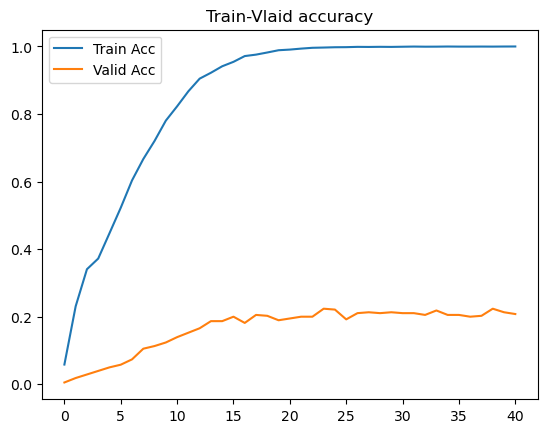

epoch 41 loss: 0.0319:   1%|▌                                        | 1/80 [00:04<05:42,  4.34s/it]

111
222
111
222


epoch 41 loss: 0.0318:   4%|█▌                                       | 3/80 [00:04<01:26,  1.12s/it]

111
222
111
222


epoch 41 loss: 0.0318:   6%|██▌                                      | 5/80 [00:05<00:41,  1.81it/s]

111
222
111
222


epoch 41 loss: 0.0316:   9%|███▌                                     | 7/80 [00:08<01:36,  1.32s/it]

111
222
111
222


epoch 41 loss: 0.0316:  11%|████▌                                    | 9/80 [00:08<00:50,  1.39it/s]

111
222
111
222


epoch 41 loss: 0.0314:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.26it/s]

111
222
111
222


epoch 41 loss: 0.0312:  16%|██████▌                                 | 13/80 [00:12<01:18,  1.17s/it]

111
222
111
222


epoch 41 loss: 0.0311:  19%|███████▌                                | 15/80 [00:13<00:51,  1.25it/s]

111
222
111
222


epoch 41 loss: 0.0310:  21%|████████▌                               | 17/80 [00:13<00:30,  2.06it/s]

111
222
111
222


epoch 41 loss: 0.0309:  24%|█████████▌                              | 19/80 [00:16<01:08,  1.13s/it]

111
222
111
222


epoch 41 loss: 0.0308:  26%|██████████▌                             | 21/80 [00:17<00:43,  1.36it/s]

111
222
111
222


epoch 41 loss: 0.0306:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.17it/s]

111
222
111
222


epoch 41 loss: 0.0305:  31%|████████████▌                           | 25/80 [00:20<01:03,  1.15s/it]

111
222
111
222


epoch 41 loss: 0.0304:  34%|█████████████▌                          | 27/80 [00:21<00:38,  1.37it/s]

111
222
111
222


epoch 41 loss: 0.0302:  36%|██████████████▌                         | 29/80 [00:21<00:23,  2.19it/s]

111
222
111
222


epoch 41 loss: 0.0302:  39%|███████████████▌                        | 31/80 [00:25<00:57,  1.17s/it]

111
222
111
222


epoch 41 loss: 0.0301:  41%|████████████████▌                       | 33/80 [00:25<00:32,  1.45it/s]

111
222
111
222


epoch 41 loss: 0.0298:  44%|█████████████████▌                      | 35/80 [00:25<00:19,  2.28it/s]

111
222
111
222


epoch 41 loss: 0.0297:  46%|██████████████████▌                     | 37/80 [00:29<00:51,  1.19s/it]

111
222
111
222


epoch 41 loss: 0.0296:  49%|███████████████████▌                    | 39/80 [00:29<00:27,  1.47it/s]

111
222
111
222


epoch 41 loss: 0.0295:  51%|████████████████████▌                   | 41/80 [00:29<00:16,  2.30it/s]

111
222
111
222


epoch 41 loss: 0.0294:  54%|█████████████████████▌                  | 43/80 [00:33<00:43,  1.19s/it]

111
222
111


epoch 41 loss: 0.0294:  55%|██████████████████████                  | 44/80 [00:33<00:32,  1.12it/s]

222
111


epoch 41 loss: 0.0292:  56%|██████████████████████▌                 | 45/80 [00:33<00:23,  1.47it/s]

222
111
222


epoch 41 loss: 0.0291:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.32it/s]

111
222


epoch 41 loss: 0.0291:  60%|████████████████████████                | 48/80 [00:34<00:11,  2.71it/s]

111
222


epoch 41 loss: 0.0290:  61%|████████████████████████▌               | 49/80 [00:37<00:37,  1.20s/it]

111
222
111


epoch 41 loss: 0.0290:  62%|█████████████████████████               | 50/80 [00:37<00:26,  1.11it/s]

222


epoch 41 loss: 0.0289:  64%|█████████████████████████▌              | 51/80 [00:37<00:21,  1.38it/s]

111
222
111
222


epoch 41 loss: 0.0288:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.20it/s]

111
222
111
222


epoch 41 loss: 0.0287:  69%|███████████████████████████▌            | 55/80 [00:41<00:29,  1.18s/it]

111
222
111
222


epoch 41 loss: 0.0287:  71%|████████████████████████████▌           | 57/80 [00:42<00:17,  1.34it/s]

111
222
111
222


epoch 41 loss: 0.0289:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.16it/s]

111
222
111
222


epoch 41 loss: 0.0287:  76%|██████████████████████████████▌         | 61/80 [00:45<00:22,  1.20s/it]

111
222
111
222


epoch 41 loss: 0.0288:  79%|███████████████████████████████▌        | 63/80 [00:46<00:13,  1.26it/s]

111
222
111
222


epoch 41 loss: 0.0288:  81%|████████████████████████████████▌       | 65/80 [00:46<00:07,  2.05it/s]

111
222
111
222


epoch 41 loss: 0.0288:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:15,  1.22s/it]

111
222
111
222


epoch 41 loss: 0.0287:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.42it/s]

111
222
111
222


epoch 41 loss: 0.0286:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:03,  2.27it/s]

111
222
111
222


epoch 41 loss: 0.0288:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.18s/it]

111
222
111
222


epoch 41 loss: 0.0288:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.42it/s]

111
222
111
222


epoch 41 loss: 0.0286:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.31it/s]

111
222
111
222


epoch 41 loss: 0.0285:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:01,  1.04s/it]

111
222
111
222


epoch 41 loss: 0.0294: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.38it/s]

333
train accuracy = 0.99962
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 41 loss: 4.1156: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.74it/s]


validation accuracy = 0.20789
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


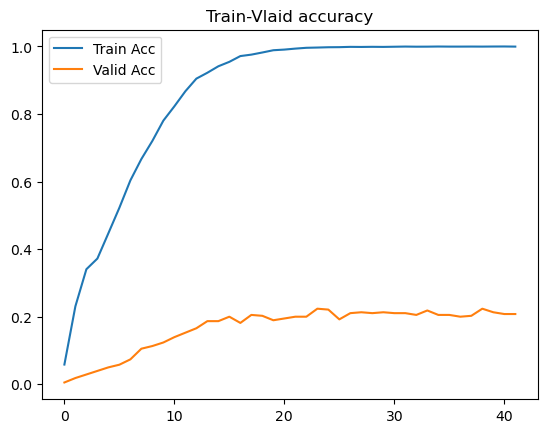

epoch 42 loss: 0.0305:   1%|▌                                        | 1/80 [00:04<05:55,  4.50s/it]

111
222
111
222


epoch 42 loss: 0.0302:   4%|█▌                                       | 3/80 [00:04<01:28,  1.16s/it]

111
222
111
222


epoch 42 loss: 0.0300:   6%|██▌                                      | 5/80 [00:05<00:42,  1.77it/s]

111
222
111
222


epoch 42 loss: 0.0299:   9%|███▌                                     | 7/80 [00:08<01:40,  1.37s/it]

111
222
111
222


epoch 42 loss: 0.0298:  11%|████▌                                    | 9/80 [00:09<00:52,  1.34it/s]

111
222
111
222


epoch 42 loss: 0.0298:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.19it/s]

111
222
111
222


epoch 42 loss: 0.0297:  16%|██████▌                                 | 13/80 [00:12<01:19,  1.18s/it]

111
222
111


epoch 42 loss: 0.0297:  18%|███████                                 | 14/80 [00:12<00:58,  1.13it/s]

222


epoch 42 loss: 0.0296:  19%|███████▌                                | 15/80 [00:13<00:44,  1.47it/s]

111
222
111
222


epoch 42 loss: 0.0295:  21%|████████▌                               | 17/80 [00:13<00:27,  2.30it/s]

111
222
111
222


epoch 42 loss: 0.0295:  24%|█████████▌                              | 19/80 [00:16<01:15,  1.23s/it]

111
222
111
222


epoch 42 loss: 0.0295:  25%|██████████                              | 20/80 [00:17<00:55,  1.09it/s]

111


epoch 42 loss: 0.0294:  26%|██████████▌                             | 21/80 [00:17<00:41,  1.42it/s]

222
111
222


epoch 42 loss: 0.0293:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.25it/s]

111
222
111
222


epoch 42 loss: 0.0292:  31%|████████████▌                           | 25/80 [00:21<01:05,  1.18s/it]

111
222


epoch 42 loss: 0.0291:  32%|█████████████                           | 26/80 [00:21<00:48,  1.12it/s]

111
222


epoch 42 loss: 0.0290:  34%|█████████████▌                          | 27/80 [00:21<00:36,  1.45it/s]

111
222
111
222


epoch 42 loss: 0.0289:  36%|██████████████▌                         | 29/80 [00:21<00:22,  2.29it/s]

111
222
111
222


epoch 42 loss: 0.0287:  39%|███████████████▌                        | 31/80 [00:25<00:56,  1.16s/it]

111
222


epoch 42 loss: 0.0287:  40%|████████████████                        | 32/80 [00:25<00:45,  1.05it/s]

111
222


epoch 42 loss: 0.0287:  41%|████████████████▌                       | 33/80 [00:25<00:34,  1.38it/s]

111
222
111
222


epoch 42 loss: 0.0286:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.21it/s]

111
222
111
222


epoch 42 loss: 0.0285:  46%|██████████████████▌                     | 37/80 [00:29<00:48,  1.12s/it]

111
222


epoch 42 loss: 0.0286:  48%|███████████████████                     | 38/80 [00:29<00:39,  1.06it/s]

111
222


epoch 42 loss: 0.0285:  49%|███████████████████▌                    | 39/80 [00:29<00:29,  1.38it/s]

111
222
111
222


epoch 42 loss: 0.0284:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.20it/s]

111
222
111
222


epoch 42 loss: 0.0284:  54%|█████████████████████▌                  | 43/80 [00:33<00:40,  1.08s/it]

111
222
111


epoch 42 loss: 0.0283:  55%|██████████████████████                  | 44/80 [00:33<00:35,  1.02it/s]

222
111
222


epoch 42 loss: 0.0283:  57%|███████████████████████                 | 46/80 [00:34<00:19,  1.72it/s]

111
222


epoch 42 loss: 0.0283:  59%|███████████████████████▌                | 47/80 [00:34<00:15,  2.15it/s]

111
222
111
222


epoch 42 loss: 0.0282:  61%|████████████████████████▌               | 49/80 [00:37<00:32,  1.06s/it]

111
222


epoch 42 loss: 0.0281:  62%|█████████████████████████               | 50/80 [00:37<00:26,  1.12it/s]

111
222


epoch 42 loss: 0.0280:  64%|█████████████████████████▌              | 51/80 [00:38<00:19,  1.47it/s]

111
222
111
222


epoch 42 loss: 0.0279:  66%|██████████████████████████▌             | 53/80 [00:38<00:11,  2.33it/s]

111
222
111
222


epoch 42 loss: 0.0279:  69%|███████████████████████████▌            | 55/80 [00:41<00:27,  1.10s/it]

111
222


epoch 42 loss: 0.0279:  70%|████████████████████████████            | 56/80 [00:41<00:22,  1.09it/s]

111
222


epoch 42 loss: 0.0278:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.42it/s]

111
222


epoch 42 loss: 0.0277:  72%|█████████████████████████████           | 58/80 [00:42<00:13,  1.68it/s]

111
222


epoch 42 loss: 0.0277:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.10it/s]

111
222
111
222


epoch 42 loss: 0.0276:  76%|██████████████████████████████▌         | 61/80 [00:45<00:20,  1.09s/it]

111
222


epoch 42 loss: 0.0275:  78%|███████████████████████████████         | 62/80 [00:46<00:16,  1.11it/s]

111
222


epoch 42 loss: 0.0274:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.45it/s]

111
222


epoch 42 loss: 0.0274:  80%|████████████████████████████████        | 64/80 [00:46<00:09,  1.62it/s]

111
222


epoch 42 loss: 0.0274:  81%|████████████████████████████████▌       | 65/80 [00:46<00:07,  2.02it/s]

111
222
111
222


epoch 42 loss: 0.0272:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:13,  1.05s/it]

111
222


epoch 42 loss: 0.0272:  85%|██████████████████████████████████      | 68/80 [00:50<00:10,  1.11it/s]

111
222


epoch 42 loss: 0.0271:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.44it/s]

111
222


epoch 42 loss: 0.0272:  88%|███████████████████████████████████     | 70/80 [00:51<00:06,  1.43it/s]

111
222


epoch 42 loss: 0.0272:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  1.82it/s]

111
222
111
222


epoch 42 loss: 0.0273:  91%|████████████████████████████████████▌   | 73/80 [00:53<00:07,  1.03s/it]

111
222


epoch 42 loss: 0.0273:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.13it/s]

111
222


epoch 42 loss: 0.0273:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.43it/s]

111
222


epoch 42 loss: 0.0273:  95%|██████████████████████████████████████  | 76/80 [00:55<00:02,  1.56it/s]

111
222
111
222


epoch 42 loss: 0.0272:  98%|███████████████████████████████████████ | 78/80 [00:55<00:00,  2.49it/s]

111
222


epoch 42 loss: 0.0286:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.11it/s]

111
222
111
222


epoch 42 loss: 0.0286: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]

333
train accuracy = 0.99924
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 42 loss: 4.1366: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.30it/s]


validation accuracy = 0.22368
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


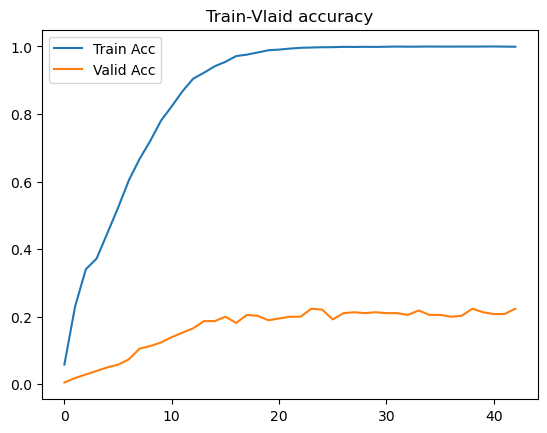

epoch 43 loss: 0.0215:   1%|▌                                        | 1/80 [00:04<05:50,  4.43s/it]

111
222
111
222


epoch 43 loss: 0.0215:   4%|█▌                                       | 3/80 [00:04<01:28,  1.14s/it]

111
222
111
222


epoch 43 loss: 0.0215:   6%|██▌                                      | 5/80 [00:05<00:42,  1.78it/s]

111
222
111
222


epoch 43 loss: 0.0215:   9%|███▌                                     | 7/80 [00:08<01:38,  1.35s/it]

111
222
111
222


epoch 43 loss: 0.0214:  11%|████▌                                    | 9/80 [00:09<00:52,  1.36it/s]

111
222
111
222


epoch 43 loss: 0.0214:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.23it/s]

111
222
111
222


epoch 43 loss: 0.0215:  16%|██████▌                                 | 13/80 [00:12<01:23,  1.24s/it]

111
222
111
222


epoch 43 loss: 0.0216:  19%|███████▌                                | 15/80 [00:13<00:45,  1.41it/s]

111
222
111
222


epoch 43 loss: 0.0215:  21%|████████▌                               | 17/80 [00:13<00:27,  2.25it/s]

111
222
111
222


epoch 43 loss: 0.0216:  24%|█████████▌                              | 19/80 [00:16<01:10,  1.16s/it]

111
222
111
222


epoch 43 loss: 0.0216:  26%|██████████▌                             | 21/80 [00:17<00:43,  1.36it/s]

111
222
111
222


epoch 43 loss: 0.0218:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.19it/s]

111
222
111
222


epoch 43 loss: 0.0218:  31%|████████████▌                           | 25/80 [00:20<01:03,  1.16s/it]

111
222
111
222


epoch 43 loss: 0.0219:  34%|█████████████▌                          | 27/80 [00:21<00:40,  1.31it/s]

111
222
111


epoch 43 loss: 0.0219:  35%|██████████████                          | 28/80 [00:21<00:31,  1.67it/s]

222
111


epoch 43 loss: 0.0219:  36%|██████████████▌                         | 29/80 [00:22<00:24,  2.09it/s]

222
111
222


epoch 43 loss: 0.0219:  39%|███████████████▌                        | 31/80 [00:25<00:56,  1.15s/it]

111
222
111
222


epoch 43 loss: 0.0218:  41%|████████████████▌                       | 33/80 [00:26<00:39,  1.20it/s]

111
222
111
222


epoch 43 loss: 0.0219:  44%|█████████████████▌                      | 35/80 [00:26<00:22,  1.97it/s]

111
222
111
222


epoch 43 loss: 0.0218:  46%|██████████████████▌                     | 37/80 [00:29<00:46,  1.07s/it]

111
222
111
222


epoch 43 loss: 0.0219:  49%|███████████████████▌                    | 39/80 [00:30<00:34,  1.19it/s]

111
222
111
222


epoch 43 loss: 0.0218:  51%|████████████████████▌                   | 41/80 [00:30<00:19,  1.96it/s]

111
222
111
222


epoch 43 loss: 0.0217:  54%|█████████████████████▌                  | 43/80 [00:33<00:39,  1.07s/it]

111
222
111
222


epoch 43 loss: 0.0218:  56%|██████████████████████▌                 | 45/80 [00:34<00:28,  1.22it/s]

111
222
111
222


epoch 43 loss: 0.0219:  59%|███████████████████████▌                | 47/80 [00:35<00:16,  2.01it/s]

111
222
111
222


epoch 43 loss: 0.0218:  61%|████████████████████████▌               | 49/80 [00:37<00:32,  1.06s/it]

111
222
111
222


epoch 43 loss: 0.0219:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.33it/s]

111
222
111
222


epoch 43 loss: 0.0218:  66%|██████████████████████████▌             | 53/80 [00:39<00:12,  2.14it/s]

111
222
111
222


epoch 43 loss: 0.0218:  69%|███████████████████████████▌            | 55/80 [00:42<00:30,  1.21s/it]

111
222
111
222


epoch 43 loss: 0.0218:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.42it/s]

111
222
111
222


epoch 43 loss: 0.0217:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.26it/s]

111
222
111
222


epoch 43 loss: 0.0217:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.19s/it]

111
222
111
222


epoch 43 loss: 0.0216:  79%|███████████████████████████████▌        | 63/80 [00:47<00:12,  1.32it/s]

111
222
111
222


epoch 43 loss: 0.0216:  81%|████████████████████████████████▌       | 65/80 [00:47<00:06,  2.15it/s]

111
222
111
222


epoch 43 loss: 0.0215:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:14,  1.10s/it]

111
222
111
222


epoch 43 loss: 0.0214:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:09,  1.22it/s]

111
222
111
222


epoch 43 loss: 0.0214:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.00it/s]

111
222
111
222


epoch 43 loss: 0.0215:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:07,  1.07s/it]

111
222
111
222


epoch 43 loss: 0.0214:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:04,  1.25it/s]

111
222
111
222


epoch 43 loss: 0.0214:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.07it/s]

111
222
111
222


epoch 43 loss: 0.0214:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:00,  1.07it/s]

111
222
111
222


epoch 43 loss: 0.0224: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 1.00000
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 43 loss: 4.1248: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.00it/s]


validation accuracy = 0.21842
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


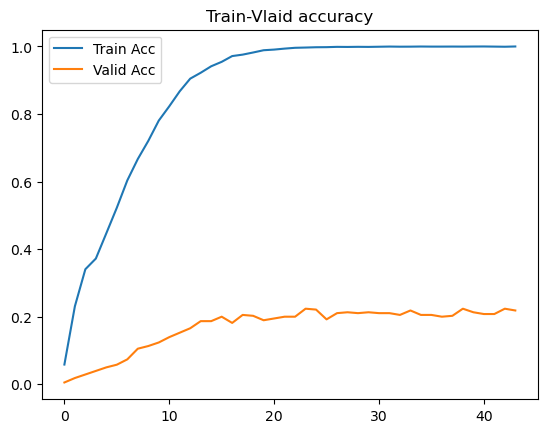

epoch 44 loss: 0.0169:   1%|▌                                        | 1/80 [00:04<05:40,  4.30s/it]

111
222
111
222


epoch 44 loss: 0.0171:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 44 loss: 0.0171:   6%|██▌                                      | 5/80 [00:05<00:41,  1.82it/s]

111
222
111
222


epoch 44 loss: 0.0171:   9%|███▌                                     | 7/80 [00:08<01:35,  1.31s/it]

111
222
111
222


epoch 44 loss: 0.0172:  11%|████▌                                    | 9/80 [00:08<00:50,  1.39it/s]

111
222
111
222


epoch 44 loss: 0.0173:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.24it/s]

111
222
111
222


epoch 44 loss: 0.0173:  16%|██████▌                                 | 13/80 [00:12<01:23,  1.24s/it]

111
222
111
222


epoch 44 loss: 0.0174:  19%|███████▌                                | 15/80 [00:12<00:45,  1.42it/s]

111
222
111
222


epoch 44 loss: 0.0174:  21%|████████▌                               | 17/80 [00:13<00:27,  2.27it/s]

111
222
111
222


epoch 44 loss: 0.0175:  24%|█████████▌                              | 19/80 [00:16<01:12,  1.19s/it]

111
222


epoch 44 loss: 0.0175:  25%|██████████                              | 20/80 [00:17<00:56,  1.07it/s]

111
222


epoch 44 loss: 0.0175:  26%|██████████▌                             | 21/80 [00:17<00:42,  1.40it/s]

111
222
111
222


epoch 44 loss: 0.0175:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.25it/s]

111
222
111
222


epoch 44 loss: 0.0176:  31%|████████████▌                           | 25/80 [00:20<01:03,  1.15s/it]

111
222


epoch 44 loss: 0.0175:  32%|█████████████                           | 26/80 [00:21<00:57,  1.06s/it]

111
222
111


epoch 44 loss: 0.0176:  34%|█████████████▌                          | 27/80 [00:21<00:42,  1.25it/s]

222
111
222


epoch 44 loss: 0.0178:  36%|██████████████▌                         | 29/80 [00:22<00:24,  2.06it/s]

111
222
111
222


epoch 44 loss: 0.0179:  39%|███████████████▌                        | 31/80 [00:24<00:48,  1.00it/s]

111
222


epoch 44 loss: 0.0179:  40%|████████████████                        | 32/80 [00:25<00:47,  1.01it/s]

111
222


epoch 44 loss: 0.0180:  41%|████████████████▌                       | 33/80 [00:25<00:35,  1.33it/s]

111
222
111
222


epoch 44 loss: 0.0181:  44%|█████████████████▌                      | 35/80 [00:26<00:21,  2.14it/s]

111
222
111
222


epoch 44 loss: 0.0181:  46%|██████████████████▌                     | 37/80 [00:28<00:42,  1.02it/s]

111
222


epoch 44 loss: 0.0182:  48%|███████████████████                     | 38/80 [00:29<00:41,  1.02it/s]

111
222


epoch 44 loss: 0.0182:  49%|███████████████████▌                    | 39/80 [00:30<00:30,  1.34it/s]

111
222
111
222


epoch 44 loss: 0.0182:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.16it/s]

111
222
111
222


epoch 44 loss: 0.0182:  54%|█████████████████████▌                  | 43/80 [00:32<00:35,  1.05it/s]

111
222


epoch 44 loss: 0.0183:  55%|██████████████████████                  | 44/80 [00:34<00:38,  1.06s/it]

111
222


epoch 44 loss: 0.0184:  56%|██████████████████████▌                 | 45/80 [00:34<00:27,  1.25it/s]

111
222
111
222


epoch 44 loss: 0.0184:  59%|███████████████████████▌                | 47/80 [00:34<00:16,  2.04it/s]

111
222
111
222


epoch 44 loss: 0.0184:  61%|████████████████████████▌               | 49/80 [00:37<00:30,  1.01it/s]

111
222


epoch 44 loss: 0.0185:  62%|█████████████████████████               | 50/80 [00:38<00:29,  1.01it/s]

111
222


epoch 44 loss: 0.0185:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.33it/s]

111
222
111
222


epoch 44 loss: 0.0187:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.14it/s]

111
222
111
222


epoch 44 loss: 0.0188:  69%|███████████████████████████▌            | 55/80 [00:41<00:25,  1.02s/it]

111
222


epoch 44 loss: 0.0187:  70%|████████████████████████████            | 56/80 [00:42<00:22,  1.06it/s]

111
222


epoch 44 loss: 0.0187:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.39it/s]

111
222


epoch 44 loss: 0.0186:  72%|█████████████████████████████           | 58/80 [00:42<00:12,  1.73it/s]

111
222


epoch 44 loss: 0.0187:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.16it/s]

111
222
111
222


epoch 44 loss: 0.0187:  76%|██████████████████████████████▌         | 61/80 [00:45<00:18,  1.01it/s]

111
222


epoch 44 loss: 0.0187:  78%|███████████████████████████████         | 62/80 [00:46<00:18,  1.00s/it]

111
222


epoch 44 loss: 0.0187:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.31it/s]

111
222
111
222


epoch 44 loss: 0.0188:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  2.13it/s]

111
222
111
222


epoch 44 loss: 0.0188:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:12,  1.01it/s]

111
222


epoch 44 loss: 0.0189:  85%|██████████████████████████████████      | 68/80 [00:50<00:12,  1.03s/it]

111
222


epoch 44 loss: 0.0189:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:08,  1.28it/s]

111
222
111
222


epoch 44 loss: 0.0189:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.09it/s]

111
222
111
222


epoch 44 loss: 0.0188:  91%|████████████████████████████████████▌   | 73/80 [00:53<00:06,  1.08it/s]

111
222


epoch 44 loss: 0.0188:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.05it/s]

111
222
111


epoch 44 loss: 0.0189:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.39it/s]

222
111
222


epoch 44 loss: 0.0189:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.26it/s]

111
222
111
222


epoch 44 loss: 0.0200:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.22it/s]

111
222
111
222


epoch 44 loss: 0.0200: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]

333
train accuracy = 1.00000
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 44 loss: 4.1410: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.89it/s]


validation accuracy = 0.21842
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


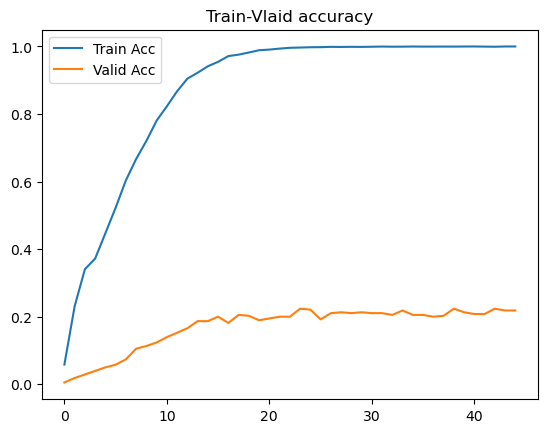

epoch 45 loss: 0.0151:   1%|▌                                        | 1/80 [00:04<05:40,  4.31s/it]

111
222
111
222


epoch 45 loss: 0.0152:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 45 loss: 0.0154:   6%|██▌                                      | 5/80 [00:05<00:40,  1.84it/s]

111
222
111
222


epoch 45 loss: 0.0154:   9%|███▌                                     | 7/80 [00:08<01:36,  1.32s/it]

111
222
111
222


epoch 45 loss: 0.0154:  11%|████▌                                    | 9/80 [00:08<00:51,  1.38it/s]

111
222
111
222


epoch 45 loss: 0.0155:  14%|█████▌                                  | 11/80 [00:09<00:30,  2.24it/s]

111
222
111
222


epoch 45 loss: 0.0156:  16%|██████▌                                 | 13/80 [00:12<01:19,  1.18s/it]

111
222
111


epoch 45 loss: 0.0156:  18%|███████                                 | 14/80 [00:12<00:58,  1.13it/s]

222
111


epoch 45 loss: 0.0157:  19%|███████▌                                | 15/80 [00:12<00:44,  1.48it/s]

222
111
222


epoch 45 loss: 0.0158:  21%|████████▌                               | 17/80 [00:13<00:27,  2.33it/s]

111
222
111
222


epoch 45 loss: 0.0158:  24%|█████████▌                              | 19/80 [00:16<01:14,  1.22s/it]

111
222
111
222


epoch 45 loss: 0.0158:  26%|██████████▌                             | 21/80 [00:17<00:41,  1.44it/s]

111
222
111
222


epoch 45 loss: 0.0158:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.25it/s]

111
222
111
222


epoch 45 loss: 0.0159:  31%|████████████▌                           | 25/80 [00:21<01:10,  1.29s/it]

111
222
111
222


epoch 45 loss: 0.0161:  34%|█████████████▌                          | 27/80 [00:21<00:38,  1.37it/s]

111
222
111
222


epoch 45 loss: 0.0161:  36%|██████████████▌                         | 29/80 [00:21<00:23,  2.19it/s]

111
222
111
222


epoch 45 loss: 0.0163:  39%|███████████████▌                        | 31/80 [00:25<01:00,  1.23s/it]

111
222
111
222


epoch 45 loss: 0.0163:  41%|████████████████▌                       | 33/80 [00:25<00:33,  1.42it/s]

111
222
111
222


epoch 45 loss: 0.0163:  44%|█████████████████▌                      | 35/80 [00:25<00:19,  2.27it/s]

111
222
111
222


epoch 45 loss: 0.0164:  46%|██████████████████▌                     | 37/80 [00:29<00:54,  1.26s/it]

111
222
111
222


epoch 45 loss: 0.0166:  49%|███████████████████▌                    | 39/80 [00:29<00:29,  1.40it/s]

111
222
111
222


epoch 45 loss: 0.0168:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.22it/s]

111
222
111
222


epoch 45 loss: 0.0169:  54%|█████████████████████▌                  | 43/80 [00:33<00:46,  1.26s/it]

111
222
111
222


epoch 45 loss: 0.0169:  56%|██████████████████████▌                 | 45/80 [00:34<00:25,  1.40it/s]

111
222
111
222


epoch 45 loss: 0.0170:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.23it/s]

111
222
111
222


epoch 45 loss: 0.0170:  61%|████████████████████████▌               | 49/80 [00:38<00:40,  1.29s/it]

111
222
111
222


epoch 45 loss: 0.0169:  64%|█████████████████████████▌              | 51/80 [00:38<00:21,  1.37it/s]

111
222
111
222


epoch 45 loss: 0.0170:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.19it/s]

111
222
111
222


epoch 45 loss: 0.0171:  69%|███████████████████████████▌            | 55/80 [00:42<00:30,  1.20s/it]

111
222
111
222


epoch 45 loss: 0.0171:  71%|████████████████████████████▌           | 57/80 [00:42<00:15,  1.46it/s]

111
222
111
222


epoch 45 loss: 0.0171:  74%|█████████████████████████████▌          | 59/80 [00:43<00:09,  2.33it/s]

111
222
111
222


epoch 45 loss: 0.0172:  76%|██████████████████████████████▌         | 61/80 [00:46<00:22,  1.16s/it]

111
222
111
222


epoch 45 loss: 0.0172:  79%|███████████████████████████████▌        | 63/80 [00:47<00:13,  1.25it/s]

111
222
111
222


epoch 45 loss: 0.0173:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  2.04it/s]

111
222
111
222


epoch 45 loss: 0.0174:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:13,  1.08s/it]

111
222
111
222


epoch 45 loss: 0.0174:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:10,  1.08it/s]

111
222
111
222


epoch 45 loss: 0.0174:  89%|███████████████████████████████████▌    | 71/80 [00:52<00:04,  1.81it/s]

111
222
111
222


epoch 45 loss: 0.0175:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:06,  1.04it/s]

111
222
111
222


epoch 45 loss: 0.0175:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:04,  1.19it/s]

111
222
111
222


epoch 45 loss: 0.0175:  96%|██████████████████████████████████████▌ | 77/80 [00:56<00:01,  2.00it/s]

111
222
111
222


epoch 45 loss: 0.0180:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:00,  1.19it/s]

111
222
111
222


epoch 45 loss: 0.0180: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.99962
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 45 loss: 4.1447: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.93it/s]


validation accuracy = 0.22105
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


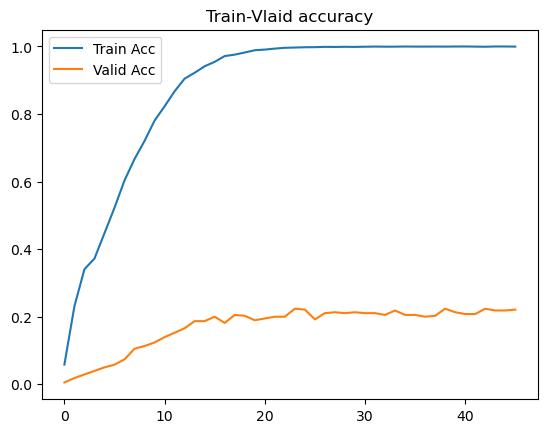

epoch 46 loss: 0.0213:   1%|▌                                        | 1/80 [00:04<05:38,  4.29s/it]

111
222
111
222


epoch 46 loss: 0.0213:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 46 loss: 0.0213:   6%|██▌                                      | 5/80 [00:05<00:41,  1.82it/s]

111
222
111
222


epoch 46 loss: 0.0213:   9%|███▌                                     | 7/80 [00:08<01:36,  1.32s/it]

111
222
111
222


epoch 46 loss: 0.0211:  11%|████▌                                    | 9/80 [00:08<00:52,  1.35it/s]

111
222
111
222


epoch 46 loss: 0.0212:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.20it/s]

111
222
111
222


epoch 46 loss: 0.0211:  16%|██████▌                                 | 13/80 [00:12<01:18,  1.18s/it]

111
222
111
222


epoch 46 loss: 0.0210:  19%|███████▌                                | 15/80 [00:12<00:44,  1.45it/s]

111
222
111
222


epoch 46 loss: 0.0210:  21%|████████▌                               | 17/80 [00:13<00:27,  2.31it/s]

111
222
111
222


epoch 46 loss: 0.0210:  24%|█████████▌                              | 19/80 [00:16<01:18,  1.28s/it]

111
222
111
222


epoch 46 loss: 0.0209:  26%|██████████▌                             | 21/80 [00:17<00:42,  1.38it/s]

111
222
111
222


epoch 46 loss: 0.0210:  29%|███████████▌                            | 23/80 [00:17<00:25,  2.21it/s]

111
222
111
222


epoch 46 loss: 0.0210:  31%|████████████▌                           | 25/80 [00:21<01:09,  1.27s/it]

111
222
111
222


epoch 46 loss: 0.0209:  34%|█████████████▌                          | 27/80 [00:21<00:38,  1.39it/s]

111
222
111
222


epoch 46 loss: 0.0209:  36%|██████████████▌                         | 29/80 [00:21<00:22,  2.22it/s]

111
222
111
222


epoch 46 loss: 0.0207:  39%|███████████████▌                        | 31/80 [00:25<01:02,  1.27s/it]

111
222
111
222


epoch 46 loss: 0.0207:  41%|████████████████▌                       | 33/80 [00:25<00:33,  1.38it/s]

111
222
111
222


epoch 46 loss: 0.0208:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.21it/s]

111
222
111
222


epoch 46 loss: 0.0207:  46%|██████████████████▌                     | 37/80 [00:29<00:52,  1.23s/it]

111
222
111
222


epoch 46 loss: 0.0208:  49%|███████████████████▌                    | 39/80 [00:30<00:28,  1.42it/s]

111
222
111
222


epoch 46 loss: 0.0207:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.26it/s]

111
222
111
222


epoch 46 loss: 0.0206:  54%|█████████████████████▌                  | 43/80 [00:33<00:43,  1.17s/it]

111
222
111
222


epoch 46 loss: 0.0206:  56%|██████████████████████▌                 | 45/80 [00:34<00:23,  1.49it/s]

111
222
111
222


epoch 46 loss: 0.0205:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.34it/s]

111
222
111
222


epoch 46 loss: 0.0205:  61%|████████████████████████▌               | 49/80 [00:37<00:36,  1.18s/it]

111
222
111
222


epoch 46 loss: 0.0205:  64%|█████████████████████████▌              | 51/80 [00:38<00:19,  1.48it/s]

111
222
111
222


epoch 46 loss: 0.0204:  66%|██████████████████████████▌             | 53/80 [00:38<00:11,  2.31it/s]

111
222
111
222


epoch 46 loss: 0.0204:  69%|███████████████████████████▌            | 55/80 [00:41<00:29,  1.17s/it]

111
222


epoch 46 loss: 0.0203:  70%|████████████████████████████            | 56/80 [00:42<00:21,  1.11it/s]

111
222


epoch 46 loss: 0.0203:  71%|████████████████████████████▌           | 57/80 [00:42<00:15,  1.45it/s]

111
222
111
222


epoch 46 loss: 0.0203:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.29it/s]

111
222
111
222


epoch 46 loss: 0.0204:  76%|██████████████████████████████▌         | 61/80 [00:46<00:23,  1.21s/it]

111
222
111
222


epoch 46 loss: 0.0203:  79%|███████████████████████████████▌        | 63/80 [00:46<00:11,  1.45it/s]

111
222
111
222


epoch 46 loss: 0.0202:  81%|████████████████████████████████▌       | 65/80 [00:46<00:06,  2.31it/s]

111
222
111
222


epoch 46 loss: 0.0202:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:16,  1.27s/it]

111
222
111
222


epoch 46 loss: 0.0203:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.39it/s]

111
222
111
222


epoch 46 loss: 0.0203:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  2.21it/s]

111
222
111
222


epoch 46 loss: 0.0202:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.25s/it]

111
222
111
222


epoch 46 loss: 0.0202:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.42it/s]

111
222
111
222


epoch 46 loss: 0.0201:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.32it/s]

111
222
111
222


epoch 46 loss: 0.0206:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:01,  1.06s/it]

111
222
111
222


epoch 46 loss: 0.0206: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]

333
train accuracy = 0.99987
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 46 loss: 4.1593: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 13.00it/s]


validation accuracy = 0.21842
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


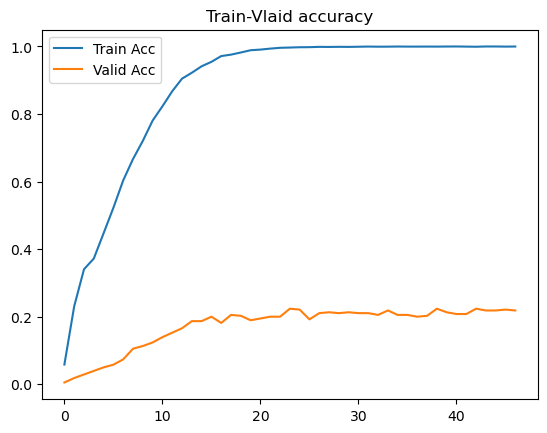

epoch 47 loss: 0.0128:   1%|▌                                        | 1/80 [00:04<05:28,  4.16s/it]

111
222


epoch 47 loss: 0.0128:   2%|█                                        | 2/80 [00:04<02:27,  1.89s/it]

111
222


epoch 47 loss: 0.0129:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 47 loss: 0.0128:   6%|██▌                                      | 5/80 [00:05<00:40,  1.83it/s]

111
222
111
222


epoch 47 loss: 0.0130:   9%|███▌                                     | 7/80 [00:08<01:29,  1.22s/it]

111
222


epoch 47 loss: 0.0130:  10%|████                                     | 8/80 [00:08<01:15,  1.05s/it]

111
222


epoch 47 loss: 0.0130:  11%|████▌                                    | 9/80 [00:08<00:55,  1.28it/s]

111
222
111
222


epoch 47 loss: 0.0132:  14%|█████▌                                  | 11/80 [00:09<00:32,  2.12it/s]

111
222
111
222


epoch 47 loss: 0.0133:  16%|██████▌                                 | 13/80 [00:12<01:14,  1.11s/it]

111
222


epoch 47 loss: 0.0133:  18%|███████                                 | 14/80 [00:13<01:06,  1.01s/it]

111
222


epoch 47 loss: 0.0133:  19%|███████▌                                | 15/80 [00:13<00:49,  1.30it/s]

111
222
111
222


epoch 47 loss: 0.0135:  21%|████████▌                               | 17/80 [00:13<00:29,  2.12it/s]

111
222
111
222


epoch 47 loss: 0.0136:  24%|█████████▌                              | 19/80 [00:16<01:04,  1.06s/it]

111
222


epoch 47 loss: 0.0136:  25%|██████████                              | 20/80 [00:17<00:58,  1.03it/s]

111
222


epoch 47 loss: 0.0136:  26%|██████████▌                             | 21/80 [00:17<00:43,  1.35it/s]

111
222
111
222


epoch 47 loss: 0.0137:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.18it/s]

111
222
111
222


epoch 47 loss: 0.0137:  31%|████████████▌                           | 25/80 [00:20<00:57,  1.04s/it]

111
222


epoch 47 loss: 0.0138:  32%|█████████████                           | 26/80 [00:21<00:50,  1.07it/s]

111
222


epoch 47 loss: 0.0139:  34%|█████████████▌                          | 27/80 [00:21<00:37,  1.40it/s]

111
222
111
222


epoch 47 loss: 0.0140:  36%|██████████████▌                         | 29/80 [00:21<00:22,  2.24it/s]

111
222


epoch 47 loss: 0.0140:  38%|███████████████                         | 30/80 [00:22<00:20,  2.49it/s]

111
222


epoch 47 loss: 0.0141:  39%|███████████████▌                        | 31/80 [00:24<00:51,  1.05s/it]

111
222


epoch 47 loss: 0.0140:  40%|████████████████                        | 32/80 [00:25<00:47,  1.02it/s]

111
222
111


epoch 47 loss: 0.0141:  41%|████████████████▌                       | 33/80 [00:25<00:34,  1.34it/s]

222
111
222


epoch 47 loss: 0.0141:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.15it/s]

111
222


epoch 47 loss: 0.0141:  45%|██████████████████                      | 36/80 [00:26<00:18,  2.39it/s]

111
222


epoch 47 loss: 0.0143:  46%|██████████████████▌                     | 37/80 [00:28<00:42,  1.02it/s]

111
222


epoch 47 loss: 0.0144:  48%|███████████████████                     | 38/80 [00:29<00:42,  1.01s/it]

111
222


epoch 47 loss: 0.0144:  49%|███████████████████▌                    | 39/80 [00:29<00:31,  1.31it/s]

111
222
111
222


epoch 47 loss: 0.0144:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.14it/s]

111
222


epoch 47 loss: 0.0145:  52%|█████████████████████                   | 42/80 [00:30<00:15,  2.53it/s]

111
222


epoch 47 loss: 0.0145:  54%|█████████████████████▌                  | 43/80 [00:32<00:37,  1.00s/it]

111
222


epoch 47 loss: 0.0145:  55%|██████████████████████                  | 44/80 [00:33<00:34,  1.05it/s]

111
222


epoch 47 loss: 0.0146:  56%|██████████████████████▌                 | 45/80 [00:34<00:25,  1.37it/s]

111
222


epoch 47 loss: 0.0147:  57%|███████████████████████                 | 46/80 [00:34<00:20,  1.70it/s]

111
222


epoch 47 loss: 0.0147:  59%|███████████████████████▌                | 47/80 [00:34<00:15,  2.12it/s]

111
222


epoch 47 loss: 0.0148:  60%|████████████████████████                | 48/80 [00:34<00:14,  2.21it/s]

111
222


epoch 47 loss: 0.0148:  61%|████████████████████████▌               | 49/80 [00:37<00:30,  1.00it/s]

111
222


epoch 47 loss: 0.0149:  62%|█████████████████████████               | 50/80 [00:38<00:30,  1.00s/it]

111
222


epoch 47 loss: 0.0149:  64%|█████████████████████████▌              | 51/80 [00:38<00:22,  1.31it/s]

111
222
111
222


epoch 47 loss: 0.0150:  66%|██████████████████████████▌             | 53/80 [00:38<00:12,  2.13it/s]

111
222
111
222


epoch 47 loss: 0.0151:  69%|███████████████████████████▌            | 55/80 [00:41<00:26,  1.06s/it]

111
222


epoch 47 loss: 0.0151:  70%|████████████████████████████            | 56/80 [00:42<00:23,  1.04it/s]

111
222


epoch 47 loss: 0.0152:  71%|████████████████████████████▌           | 57/80 [00:42<00:16,  1.37it/s]

111
222
111
222


epoch 47 loss: 0.0152:  74%|█████████████████████████████▌          | 59/80 [00:42<00:09,  2.18it/s]

111
222
111
222


epoch 47 loss: 0.0152:  76%|██████████████████████████████▌         | 61/80 [00:45<00:20,  1.08s/it]

111
222


epoch 47 loss: 0.0152:  78%|███████████████████████████████         | 62/80 [00:46<00:16,  1.08it/s]

111
222


epoch 47 loss: 0.0152:  79%|███████████████████████████████▌        | 63/80 [00:46<00:12,  1.41it/s]

111
222


epoch 47 loss: 0.0152:  80%|████████████████████████████████        | 64/80 [00:46<00:09,  1.63it/s]

111
222


epoch 47 loss: 0.0153:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  2.04it/s]

111
222
111
222


epoch 47 loss: 0.0153:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:13,  1.07s/it]

111
222


epoch 47 loss: 0.0153:  85%|██████████████████████████████████      | 68/80 [00:50<00:10,  1.10it/s]

111
222


epoch 47 loss: 0.0154:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.44it/s]

111
222


epoch 47 loss: 0.0153:  88%|███████████████████████████████████     | 70/80 [00:51<00:06,  1.47it/s]

111
222


epoch 47 loss: 0.0154:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  1.88it/s]

111
222
111
222


epoch 47 loss: 0.0155:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:07,  1.03s/it]

111
222


epoch 47 loss: 0.0155:  92%|█████████████████████████████████████   | 74/80 [00:54<00:05,  1.12it/s]

111
222
111


epoch 47 loss: 0.0155:  94%|█████████████████████████████████████▌  | 75/80 [00:54<00:03,  1.47it/s]

222


epoch 47 loss: 0.0155:  95%|██████████████████████████████████████  | 76/80 [00:55<00:02,  1.57it/s]

111
222
111
222


epoch 47 loss: 0.0156:  98%|███████████████████████████████████████ | 78/80 [00:55<00:00,  2.51it/s]

111
222


epoch 47 loss: 0.0156:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.12it/s]

111
222
111
222


epoch 47 loss: 0.0166: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]

333
train accuracy = 1.00000
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 47 loss: 4.1776: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.96it/s]


validation accuracy = 0.21579
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]


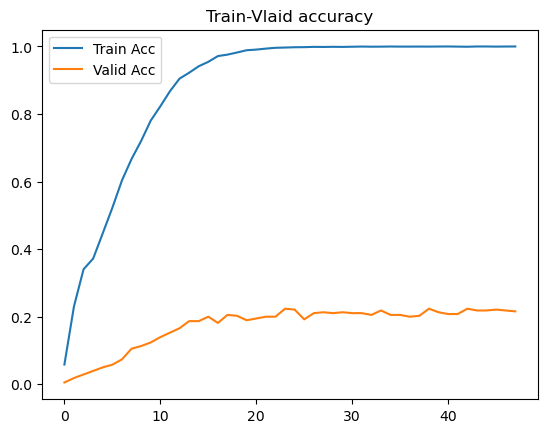

epoch 48 loss: 0.0114:   1%|▌                                        | 1/80 [00:04<05:29,  4.17s/it]

111
222
111
222


epoch 48 loss: 0.0115:   4%|█▌                                       | 3/80 [00:04<01:24,  1.10s/it]

111
222
111
222


epoch 48 loss: 0.0116:   6%|██▌                                      | 5/80 [00:04<00:40,  1.86it/s]

111
222
111
222


epoch 48 loss: 0.0117:   9%|███▌                                     | 7/80 [00:08<01:37,  1.33s/it]

111
222
111
222


epoch 48 loss: 0.0117:  11%|████▌                                    | 9/80 [00:08<00:51,  1.37it/s]

111
222
111
222


epoch 48 loss: 0.0119:  14%|█████▌                                  | 11/80 [00:09<00:31,  2.22it/s]

111
222
111
222


epoch 48 loss: 0.0120:  16%|██████▌                                 | 13/80 [00:12<01:19,  1.19s/it]

111
222


epoch 48 loss: 0.0121:  18%|███████                                 | 14/80 [00:12<01:05,  1.00it/s]

111
222


epoch 48 loss: 0.0121:  19%|███████▌                                | 15/80 [00:13<00:49,  1.32it/s]

111
222
111
222


epoch 48 loss: 0.0123:  21%|████████▌                               | 17/80 [00:13<00:29,  2.13it/s]

111
222
111
222


epoch 48 loss: 0.0124:  24%|█████████▌                              | 19/80 [00:16<01:08,  1.12s/it]

111
222


epoch 48 loss: 0.0126:  25%|██████████                              | 20/80 [00:17<01:04,  1.08s/it]

111
222


epoch 48 loss: 0.0126:  26%|██████████▌                             | 21/80 [00:17<00:48,  1.23it/s]

111
222
111
222


epoch 48 loss: 0.0126:  29%|███████████▌                            | 23/80 [00:18<00:28,  2.01it/s]

111
222
111
222


epoch 48 loss: 0.0127:  31%|████████████▌                           | 25/80 [00:20<00:56,  1.02s/it]

111
222


epoch 48 loss: 0.0127:  32%|█████████████                           | 26/80 [00:21<00:53,  1.01it/s]

111
222


epoch 48 loss: 0.0128:  34%|█████████████▌                          | 27/80 [00:21<00:39,  1.34it/s]

111
222
111
222


epoch 48 loss: 0.0129:  36%|██████████████▌                         | 29/80 [00:22<00:23,  2.14it/s]

111
222
111
222


epoch 48 loss: 0.0130:  39%|███████████████▌                        | 31/80 [00:25<00:52,  1.07s/it]

111
222


epoch 48 loss: 0.0130:  40%|████████████████                        | 32/80 [00:25<00:45,  1.06it/s]

111
222


epoch 48 loss: 0.0131:  41%|████████████████▌                       | 33/80 [00:25<00:33,  1.39it/s]

111
222
111
222


epoch 48 loss: 0.0132:  44%|█████████████████▌                      | 35/80 [00:26<00:20,  2.20it/s]

111
222
111
222


epoch 48 loss: 0.0133:  46%|██████████████████▌                     | 37/80 [00:29<00:45,  1.06s/it]

111
222


epoch 48 loss: 0.0133:  48%|███████████████████                     | 38/80 [00:30<00:41,  1.02it/s]

111
222


epoch 48 loss: 0.0134:  49%|███████████████████▌                    | 39/80 [00:30<00:30,  1.34it/s]

111
222
111
222


epoch 48 loss: 0.0135:  51%|████████████████████▌                   | 41/80 [00:30<00:18,  2.17it/s]

111
222
111
222


epoch 48 loss: 0.0136:  54%|█████████████████████▌                  | 43/80 [00:33<00:41,  1.11s/it]

111
222


epoch 48 loss: 0.0136:  55%|██████████████████████                  | 44/80 [00:34<00:32,  1.10it/s]

111
222


epoch 48 loss: 0.0137:  56%|██████████████████████▌                 | 45/80 [00:34<00:24,  1.40it/s]

111
222
111
222


epoch 48 loss: 0.0137:  59%|███████████████████████▌                | 47/80 [00:34<00:14,  2.23it/s]

111
222
111
222


epoch 48 loss: 0.0138:  61%|████████████████████████▌               | 49/80 [00:37<00:34,  1.11s/it]

111
222


epoch 48 loss: 0.0139:  62%|█████████████████████████               | 50/80 [00:38<00:26,  1.13it/s]

111
222


epoch 48 loss: 0.0139:  64%|█████████████████████████▌              | 51/80 [00:39<00:26,  1.08it/s]

111
222
111
222


epoch 48 loss: 0.0141:  66%|██████████████████████████▌             | 53/80 [00:39<00:14,  1.83it/s]

111
222
111
222


epoch 48 loss: 0.0141:  69%|███████████████████████████▌            | 55/80 [00:41<00:24,  1.02it/s]

111
222


epoch 48 loss: 0.0143:  70%|████████████████████████████            | 56/80 [00:42<00:19,  1.22it/s]

111
222


epoch 48 loss: 0.0143:  71%|████████████████████████████▌           | 57/80 [00:43<00:19,  1.16it/s]

111
222
111
222


epoch 48 loss: 0.0143:  74%|█████████████████████████████▌          | 59/80 [00:43<00:10,  1.92it/s]

111
222
111
222


epoch 48 loss: 0.0144:  76%|██████████████████████████████▌         | 61/80 [00:45<00:17,  1.10it/s]

111
222


epoch 48 loss: 0.0143:  78%|███████████████████████████████         | 62/80 [00:46<00:14,  1.26it/s]

111
222


epoch 48 loss: 0.0144:  79%|███████████████████████████████▌        | 63/80 [00:47<00:14,  1.14it/s]

111
222
111
222


epoch 48 loss: 0.0144:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  1.90it/s]

111
222
111
222


epoch 48 loss: 0.0145:  84%|█████████████████████████████████▌      | 67/80 [00:49<00:11,  1.18it/s]

111
222


epoch 48 loss: 0.0145:  85%|██████████████████████████████████      | 68/80 [00:50<00:09,  1.25it/s]

111
222


epoch 48 loss: 0.0145:  86%|██████████████████████████████████▌     | 69/80 [00:51<00:10,  1.06it/s]

111
222
111
222


epoch 48 loss: 0.0146:  89%|███████████████████████████████████▌    | 71/80 [00:52<00:05,  1.79it/s]

111
222
111
222


epoch 48 loss: 0.0146:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:05,  1.24it/s]

111
222


epoch 48 loss: 0.0147:  92%|█████████████████████████████████████   | 74/80 [00:54<00:04,  1.32it/s]

111
222


epoch 48 loss: 0.0147:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:04,  1.19it/s]

111
222
111
222


epoch 48 loss: 0.0149:  96%|██████████████████████████████████████▌ | 77/80 [00:56<00:01,  2.00it/s]

111
222
111
222


epoch 48 loss: 0.0153:  99%|███████████████████████████████████████▌| 79/80 [00:57<00:00,  1.39it/s]

111
222
111
222


epoch 48 loss: 0.0153: 100%|████████████████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]

333
train accuracy = 1.00000
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 48 loss: 4.1921: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.55it/s]


validation accuracy = 0.21316
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


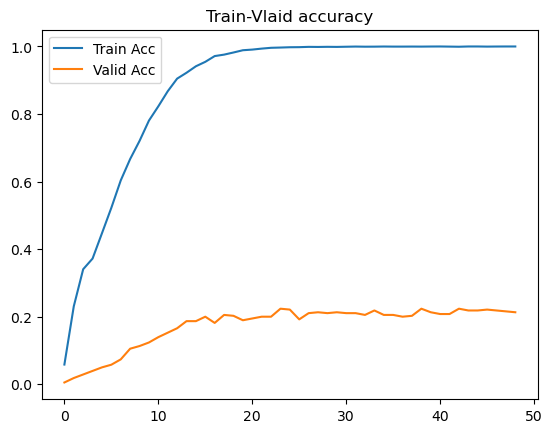

epoch 49 loss: 0.0254:   1%|▌                                        | 1/80 [00:04<05:34,  4.23s/it]

111
222
111


epoch 49 loss: 0.0253:   2%|█                                        | 2/80 [00:04<02:24,  1.86s/it]

222


epoch 49 loss: 0.0252:   4%|█▌                                       | 3/80 [00:04<01:25,  1.11s/it]

111
222
111
222


epoch 49 loss: 0.0250:   6%|██▌                                      | 5/80 [00:05<00:40,  1.85it/s]

111
222
111
222


epoch 49 loss: 0.0248:   9%|███▌                                     | 7/80 [00:08<01:38,  1.35s/it]

111
222
111
222


epoch 49 loss: 0.0246:  11%|████▌                                    | 9/80 [00:09<01:00,  1.18it/s]

111
222
111
222


epoch 49 loss: 0.0246:  14%|█████▌                                  | 11/80 [00:09<00:35,  1.97it/s]

111
222
111
222


epoch 49 loss: 0.0244:  16%|██████▌                                 | 13/80 [00:12<01:17,  1.16s/it]

111
222
111
222


epoch 49 loss: 0.0242:  19%|███████▌                                | 15/80 [00:13<00:50,  1.28it/s]

111
222
111
222


epoch 49 loss: 0.0241:  21%|████████▌                               | 17/80 [00:13<00:30,  2.08it/s]

111
222
111
222


epoch 49 loss: 0.0240:  24%|█████████▌                              | 19/80 [00:16<01:09,  1.14s/it]

111
222
111
222


epoch 49 loss: 0.0238:  26%|██████████▌                             | 21/80 [00:17<00:44,  1.33it/s]

111
222
111
222


epoch 49 loss: 0.0237:  29%|███████████▌                            | 23/80 [00:17<00:26,  2.15it/s]

111
222
111
222


epoch 49 loss: 0.0234:  31%|████████████▌                           | 25/80 [00:21<01:02,  1.13s/it]

111
222
111
222


epoch 49 loss: 0.0233:  34%|█████████████▌                          | 27/80 [00:21<00:40,  1.30it/s]

111
222
111
222


epoch 49 loss: 0.0231:  36%|██████████████▌                         | 29/80 [00:22<00:24,  2.11it/s]

111
222
111
222


epoch 49 loss: 0.0230:  39%|███████████████▌                        | 31/80 [00:25<00:55,  1.13s/it]

111
222
111
222


epoch 49 loss: 0.0228:  41%|████████████████▌                       | 33/80 [00:25<00:35,  1.31it/s]

111
222
111
222


epoch 49 loss: 0.0226:  44%|█████████████████▌                      | 35/80 [00:26<00:21,  2.13it/s]

111
222
111
222


epoch 49 loss: 0.0225:  46%|██████████████████▌                     | 37/80 [00:29<00:50,  1.18s/it]

111
222
111
222


epoch 49 loss: 0.0223:  49%|███████████████████▌                    | 39/80 [00:30<00:28,  1.46it/s]

111
222


epoch 49 loss: 0.0223:  50%|████████████████████                    | 40/80 [00:30<00:22,  1.76it/s]

111
222


epoch 49 loss: 0.0222:  51%|████████████████████▌                   | 41/80 [00:30<00:17,  2.19it/s]

111
222
111
222


epoch 49 loss: 0.0220:  54%|█████████████████████▌                  | 43/80 [00:33<00:43,  1.18s/it]

111
222
111
222


epoch 49 loss: 0.0219:  56%|██████████████████████▌                 | 45/80 [00:34<00:23,  1.48it/s]

111
222


epoch 49 loss: 0.0218:  57%|███████████████████████                 | 46/80 [00:34<00:21,  1.60it/s]

111
222


epoch 49 loss: 0.0217:  59%|███████████████████████▌                | 47/80 [00:34<00:16,  2.00it/s]

111
222
111
222


epoch 49 loss: 0.0215:  61%|████████████████████████▌               | 49/80 [00:37<00:34,  1.13s/it]

111
222
111
222


epoch 49 loss: 0.0214:  64%|█████████████████████████▌              | 51/80 [00:38<00:18,  1.53it/s]

111
222


epoch 49 loss: 0.0213:  65%|██████████████████████████              | 52/80 [00:38<00:18,  1.55it/s]

111
222


epoch 49 loss: 0.0213:  66%|██████████████████████████▌             | 53/80 [00:39<00:13,  1.95it/s]

111
222
111
222


epoch 49 loss: 0.0213:  69%|███████████████████████████▌            | 55/80 [00:41<00:27,  1.11s/it]

111
222
111
222


epoch 49 loss: 0.0212:  71%|████████████████████████████▌           | 57/80 [00:42<00:14,  1.55it/s]

111
222


epoch 49 loss: 0.0211:  72%|█████████████████████████████           | 58/80 [00:43<00:14,  1.50it/s]

111
222


epoch 49 loss: 0.0210:  74%|█████████████████████████████▌          | 59/80 [00:43<00:11,  1.90it/s]

111
222
111
222


epoch 49 loss: 0.0210:  76%|██████████████████████████████▌         | 61/80 [00:46<00:21,  1.11s/it]

111
222
111
222


epoch 49 loss: 0.0209:  79%|███████████████████████████████▌        | 63/80 [00:46<00:10,  1.55it/s]

111
222


epoch 49 loss: 0.0210:  80%|████████████████████████████████        | 64/80 [00:47<00:10,  1.52it/s]

111
222


epoch 49 loss: 0.0209:  81%|████████████████████████████████▌       | 65/80 [00:47<00:07,  1.93it/s]

111
222
111
222


epoch 49 loss: 0.0209:  84%|█████████████████████████████████▌      | 67/80 [00:50<00:14,  1.11s/it]

111
222
111
222


epoch 49 loss: 0.0208:  86%|██████████████████████████████████▌     | 69/80 [00:50<00:07,  1.54it/s]

111
222


epoch 49 loss: 0.0207:  88%|███████████████████████████████████     | 70/80 [00:51<00:06,  1.49it/s]

111
222


epoch 49 loss: 0.0208:  89%|███████████████████████████████████▌    | 71/80 [00:51<00:04,  1.89it/s]

111
222
111
222


epoch 49 loss: 0.0207:  91%|████████████████████████████████████▌   | 73/80 [00:54<00:08,  1.18s/it]

111
222
111
222


epoch 49 loss: 0.0206:  94%|█████████████████████████████████████▌  | 75/80 [00:55<00:03,  1.50it/s]

111
222


epoch 49 loss: 0.0205:  95%|██████████████████████████████████████  | 76/80 [00:55<00:02,  1.64it/s]

111
222
111


epoch 49 loss: 0.0206:  96%|██████████████████████████████████████▌ | 77/80 [00:55<00:01,  2.08it/s]

222
111
222


epoch 49 loss: 0.0204:  99%|███████████████████████████████████████▌| 79/80 [00:58<00:00,  1.00it/s]

111
222
111
222


epoch 49 loss: 0.0206: 100%|████████████████████████████████████████| 80/80 [00:58<00:00,  1.36it/s]

333
train accuracy = 0.99987
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 49 loss: 4.1939: 100%|████████████████████████████████████████| 38/38 [00:02<00:00, 12.96it/s]


validation accuracy = 0.21579
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]


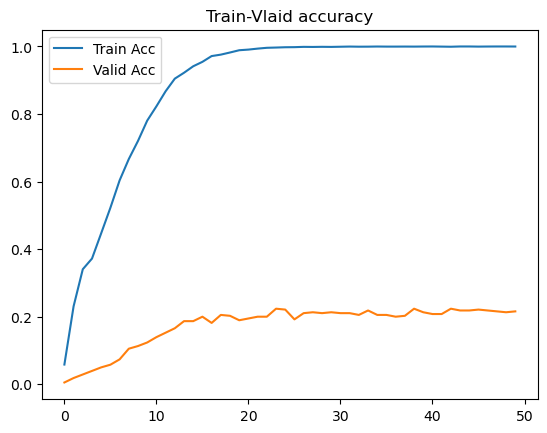

time : 0:51:53
Best Epoch : 23/ 50
Best Train Accuracy : 0.99684
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 54  1]
 [ 0  0  0 ...  0  0 55]]
Best Valid Accuracy : 0.22368
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


In [9]:
%run classification_train_efficientnet.ipynb

In [ ]:
#for train, val separately

In [2]:
#cecum = 1, else = 0

true_path = '/Data/data/data_gsun/Cecum/experiment/train/cecum/'
false_path = '/Data/data/data_gsun/Cecum/experiment/train/non_cecum/'

In [3]:
true_dir = [true_path + x for x in os.listdir(true_path) if '.txt' not in x]
false_dir = [false_path + x for x in os.listdir(false_path) if '.txt' not in x]

In [4]:
random.shuffle(true_dir)
random.shuffle(false_dir)

In [5]:
print(len(true_dir))

1274


In [6]:
true_label = [1]*int(len(true_dir))

In [7]:
print(true_label[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [8]:
print(len(true_label))

1274


In [9]:
print(len(false_dir))

15000


In [10]:
false_label = [0]*int(len(false_dir))

In [11]:
print(false_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
print(len(false_label))

15000


In [13]:
whole_dir = true_dir + false_dir

In [14]:
whole_label = true_label + false_label

In [15]:
print(len(whole_dir))

16274


In [16]:
print(len(whole_label))

16274


In [17]:
trn_df = pd.DataFrame(whole_dir, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = whole_label
train = trn_df
train

,image_id,dir,label
0,V0480_0024.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
1,V0376_0079.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
2,V0670_0048.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
3,V0307_0073.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
4,V0612_0022.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
...,...,...,...
16269,V1743_2021_0293_000738.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16270,V1485_2021_0035_001495.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16271,V1880_2021_0430_003530.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16272,V1732_2021_0282_003544.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0


In [18]:
train.label.value_counts()

0    15000
1     1274
Name: label, dtype: int64

In [19]:
#cecum = 1, else = 0

true_val_path = '/Data/data/data_gsun/Cecum/experiment/val/cecum/'
false_val_path = '/Data/data/data_gsun/Cecum/experiment/val/non_cecum/'

In [20]:
true_val_dir = [true_val_path + x for x in os.listdir(true_val_path) if '.txt' not in x]
false_val_dir = [false_val_path + x for x in os.listdir(false_val_path) if '.txt' not in x]

In [21]:
random.shuffle(true_val_dir)
random.shuffle(false_val_dir)

In [22]:
print(len(true_val_dir))

71


In [23]:
true_val_label = [1]*int(len(true_val_dir))

In [24]:
print(true_val_label[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [25]:
print(len(true_val_label))

71


In [26]:
print(len(false_val_dir))

639


In [27]:
false_val_label = [0]*int(len(false_val_dir))

In [28]:
print(false_val_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
print(len(false_val_label))

639


In [30]:
whole_val_dir = true_val_dir + false_val_dir

In [31]:
whole_val_label = true_val_label + false_val_label

In [32]:
print(len(whole_val_dir))

710


In [33]:
print(len(whole_val_label))

710


In [34]:
val_df = pd.DataFrame(whole_val_dir, columns=['image_id'])
val_df['dir'] = val_df['image_id'].apply(lambda x: os.path.dirname(x))
val_df['image_id'] = val_df['image_id'].apply(lambda x: os.path.basename(x))
val_df['label'] = whole_val_label
val = val_df
val

,image_id,dir,label
0,V1824_2021_0374_000004.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
1,V1533_2021_0083_000723.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
2,V1533_2021_0083_000742.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
3,V1434_2020_1204_000377.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
4,V1533_2021_0083_000750.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
...,...,...,...
705,V1434_2020_1204_001067.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
706,V0042_2019_0042_002852.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
707,V1373_2020_1143_002984.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
708,V0042_2019_0042_003166.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0


In [35]:
val.label.value_counts()

0    639
1     71
Name: label, dtype: int64

In [36]:
project_name = 'cecum_classification'
user = 'honbul'
run_name = 'cecum_classification_efficientnet_lite0_size192'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


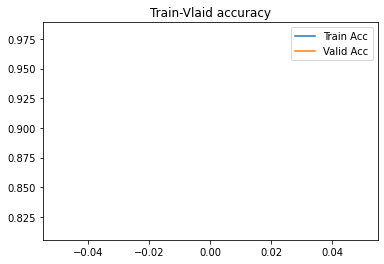

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


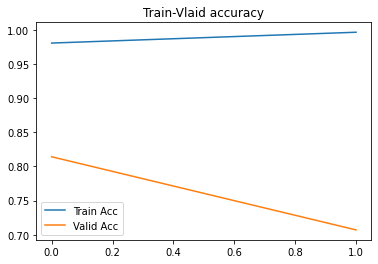

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


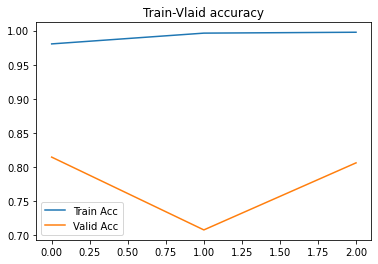

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


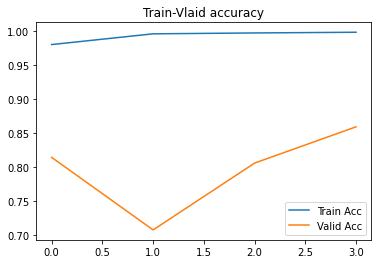

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


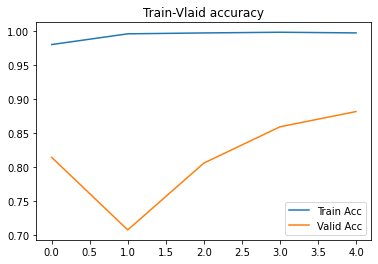

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb